Assignment 2: 

Name:

UID: 

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 


In [46]:
## Import necessary libraries here (You can add libraries you want to use here)

import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [47]:

# Download Data -- run this cell only one time per runtime
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']
print(X0.shape)


Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 82.0MB/s]
Archive:  /content/part1_images.zip
replace /content/part1_images/hotel.seq41.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_image

## Helper Functions

In [48]:
import numpy as np
from scipy.ndimage import sobel, gaussian_filter
import cv2
from tqdm import tqdm
out_points=[]
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)
def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x.ravel()
  track_y[:,0] = pt_y.ravel()

  for t in tqdm(range(nim-1)):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y 

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 




## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

In [49]:
from IPython.core.display import Image

from google.colab.patches import cv2_imshow
import collections
import itertools


def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints

  '''
  pts=[]
  image_copy=img.copy()
  window_size=5
  kernel = np.ones((3, 3), np.uint8)
  #Convert to gray_scale
  gray_scale=cv2.cvtColor(image_copy,cv2.COLOR_BGR2GRAY)
  #Find the gradient
  Iy,Ix=np.gradient(gray_scale)
  Ixx=np.square(Ix)
  Iyy=np.square(Iy)
  Ixy=Ix*Iy
  Ixx=gaussian_filter(Ixx,sigma=5)
  Iyy=gaussian_filter(Iyy,sigma=5)
  Ixy=gaussian_filter(Ixy,sigma=5)
  offset=int(window_size/2)
  x_range=img.shape[0]-offset
  y_range=img.shape[1]-offset


  Sxx = Ixx
  Sxy = Ixy
  Syy = Iyy
  det = (Sxx * Syy) - (Sxy**2)
  trace = Sxx + Syy
  #Harris score function
  r=det-0.08*np.square(trace)
  corners=dict()
  #Non-maxima supression in a window of 5x5
  for i in tqdm(range(offset,x_range)):
    for j in range(offset,y_range):
      lower_limit_i=i-offset
      upper_limit_i=i+offset+1
      lower_limit_j=j-offset
      upper_limit_j=j+offset+1
      window=r[lower_limit_i:upper_limit_i,lower_limit_j:upper_limit_j]
      x,y = np.unravel_index(window.argmax(), window.shape)
  
      #Taking the corners which are around the center of the given window
      if x==2 and y==2 and window[x][y]>10:
       corners[r[i,j]]=(x+i,y+j)
      

  return corners


k=getKeypoints(im[0],5)

100%|██████████| 476/476 [00:01<00:00, 366.97it/s]


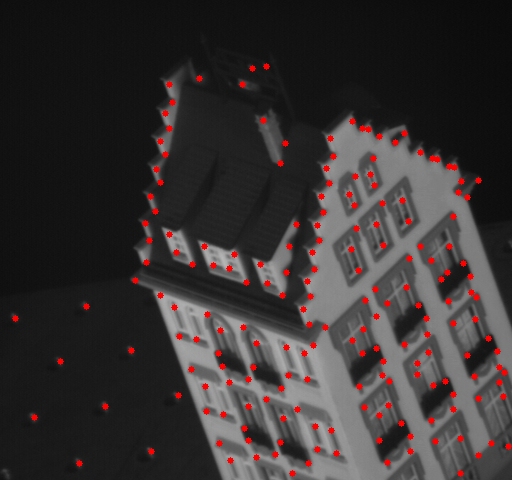

Corners display


In [50]:
img=im[0].copy()
key_pts=collections.OrderedDict(reversed(sorted(k.items())))

out = dict(itertools.islice(key_pts.items(),450))
corner_points=[]
for p in out.values():
  
  i,j=p
  corner_points.append((i,j))
  cv2.circle(img, (j,i), 3, (0, 0, 255), -1)
cv2_imshow(img)
print("Corners display")





In [51]:
corner_points=np.array(corner_points)

x1=corner_points[:,0]
y1=corner_points[:,1]




### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**

Here we are using haris corner detection. First step of the algorithm is to get the gray scale image. Then we find the gradient along x axis and y axis of the gray scale image. Then will define a Harris score function. Using this function and a window of any size we will determine if a point is a corner or not.

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


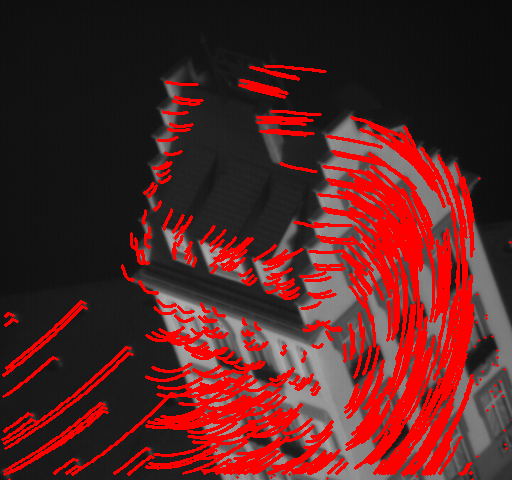

In [54]:



from tqdm import tqdm
from scipy import interpolate


def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  #Convert the images to gray_scale
  im1=cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
  im2=cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
  #Define a window 
  hw=int(ws/2)
  #No of iteration for detecting small change
  num_Iter=5
  r,c=im1.shape[0],im.shape[1]
  #Define Tracking points
  track_x=np.zeros(x.shape)
  track_y=np.zeros(y.shape)


  
  
  for j in range(x.shape[0]):
          #Define patch 1 
          Im1_patch=cv2.getRectSubPix(im1,(ws,ws),(x[j],y[j]))
          #Check if points are out of the frame
          if ((x[j]+hw)>r or (-hw+x[j])<0 or (y[j]+hw)>c or (-hw+y[j])<0):
            out_points.append(j) #Track the points going outside
            track_x[j]=x[j]
            track_y[j]=y[j]
            continue

          #Find gradient
          Iy,Ix=np.gradient(Im1_patch)
          Ixx=np.square(Ix)
          Iyy=np.square(Iy)
          Ixy=Ix*Iy
          #Find the A matrix
          A=np.array([[np.sum(Ixx),np.sum(Ixy)],[np.sum(Ixy),np.sum(Iyy)]])
          x2=x[j]
          y2=y[j]
          #Apply iterartion for detecting small changes in pixel
          for i in range(num_Iter):
            
              It=cv2.getRectSubPix(im2, (ws,ws), (x2, y2) )-Im1_patch
              #find the b matrix
              b=-np.array([[np.sum(Ix*It)],[np.sum(Iy*It)]])
              #find the velocity vector
              nu=np.matmul(np.linalg.pinv(A), b) 
              u,v=nu
              x2=x2+u
              y2=y2+v
              x2=x2[0]
              y2=y2[0]
          track_x[j]=x2
          track_y[j]=y2 




  return track_x, track_y 
ws = 15
tracked_pts = trackPoints(pt_x=X0, pt_y=Y0, im=im, ws=ws)
x,y=tracked_pts
image_=im[0].copy()
color = (0, 0, 255)
thickness=2
for i in range(x.shape[0]):
  for j in range(y.shape[1]-1):
    
    cv2.line(image_,(int(x[i][j]),int(y[i][j])),(int(x[i][j+1]),int(y[i][j+1])), color, thickness)  

cv2_imshow(image_)      




100%|██████████| 50/50 [00:01<00:00, 33.90it/s]


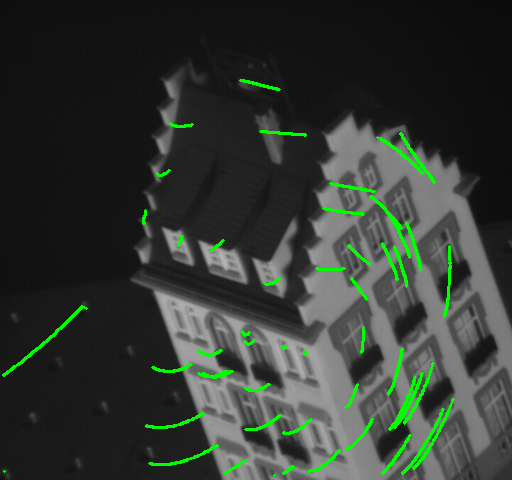

In [55]:
ws = 15
X_new=np.zeros(50)
Y_new=np.zeros(50)
for i in range(0,50):
  X_new[i]=X0[i*10]
  Y_new[i]=Y0[i*10]

tracked_pts = trackPoints(pt_x=X_new, pt_y=Y_new, im=im, ws=ws)
x,y=tracked_pts
image_=im[0].copy()
color = (0, 255, 0)
thickness=2
for i in range(x.shape[0]):
  for j in range(y.shape[1]-1):
    
    cv2.line(image_,(int(x[i][j]),int(y[i][j])),(int(x[i][j+1]),int(y[i][j+1])), color, thickness)  

cv2_imshow(image_)  

In [56]:
x_out=X0[out_points]
y_out=Y0[out_points]



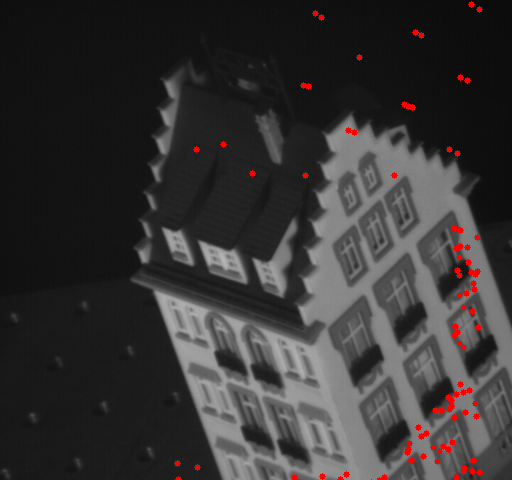

Points that are going  out of the frame


In [57]:
image_2=im[0].copy()
color = (0, 255, 0)
thickness=1
for i in range(x_out.shape[0]):

    cv2.circle(image_2, (y_out[i][0],x_out[i][0]), 3, (0, 0, 255), -1)

cv2_imshow(image_2) 
print("Points that are going  out of the frame") 

As you can see the points near to the image boundry may go out due the motion.

100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

(555, 2)


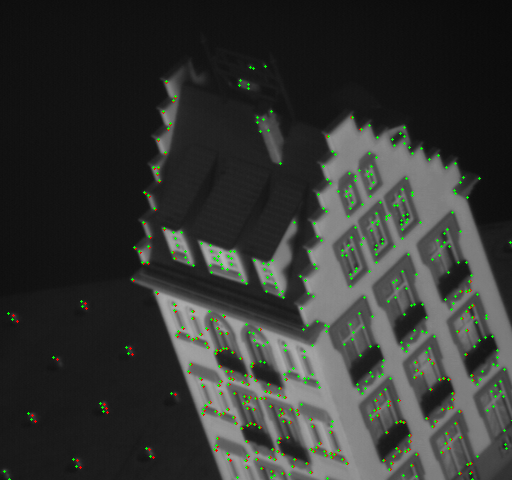

Tracked points In two frames


In [58]:
def TwoTrackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = 2
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x.ravel()
  track_y[:,0] = pt_y.ravel()

  for t in tqdm(range(nim-1)):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y 


tracked_pts = TwoTrackPoints(pt_x=X0, pt_y=Y0, im=im, ws=ws)
x,y=tracked_pts
print(x.shape)
image_3=im[0].copy()
color = (0, 255, 0)
thickness=2
for i in range(x.shape[0]):
  # for j in range(y.shape[1]):
    
    
     cv2.circle(image_3, (int(x[i][0]),int(y[i][0])), 1, (0, 0, 255), -1)
     cv2.circle(image_3, (int(x[i][1]),int(y[i][1])), 1, (0, 255, 0), -1)

cv2_imshow(image_3)    

print("Tracked points In two frames")

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





Once we have obtained the keypoints then we can use lucas kande feature tracking for tracking the corners.
Here we follow the following steps:
1. Convert the image1 and image2 to gray scale.
2. Define a window size
3. initialize track points array. This of the same size that of the intial keypoints we found in the first image.
4. Define patch 1. This patch is same as the size of the window.
5. Now for all the points see if any points are going out the window.
6. If not then find the gradient on the patch. And form that get the matrix A.
7. Then get the value of $I_t$ and get the Matrix $B$
8. Using the equation $A$$u$=B. Get $u$ the velocity of the pixels.
9. Add these velocity to the tracking points. \
We repeat this process for 50 images.

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [12]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 44.8MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [11]:

def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

## Code (15 pts)

  0%|          | 0/25 [00:00<?, ?it/s]

175.72111205105108


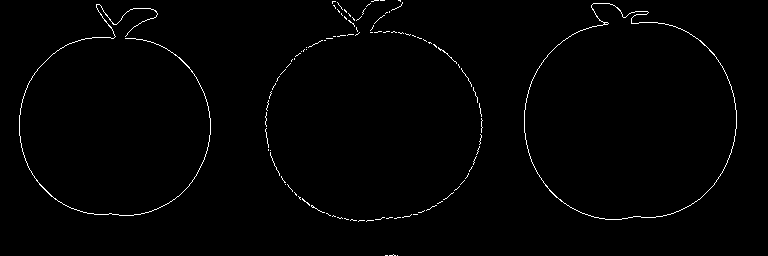

176.3665245571567


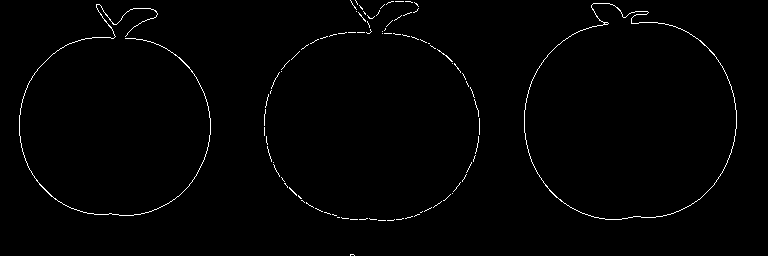

184.46677779644176


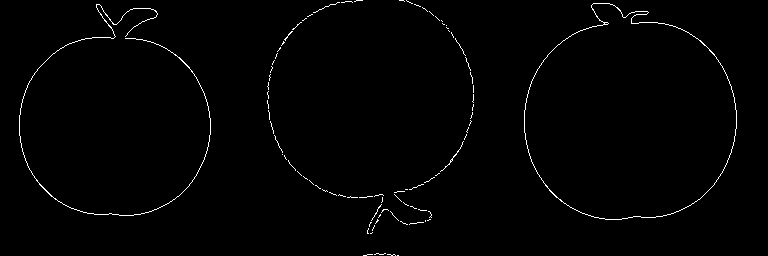

182.23514983370677


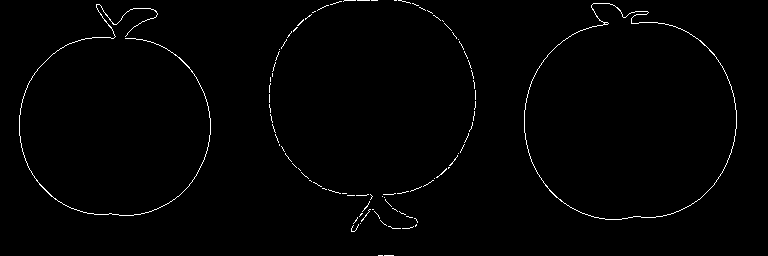

175.02574823060468


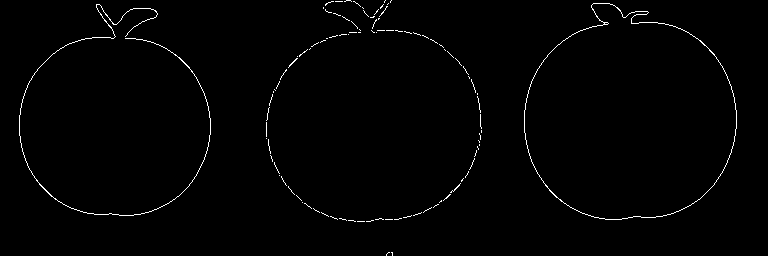

174.7855415295154


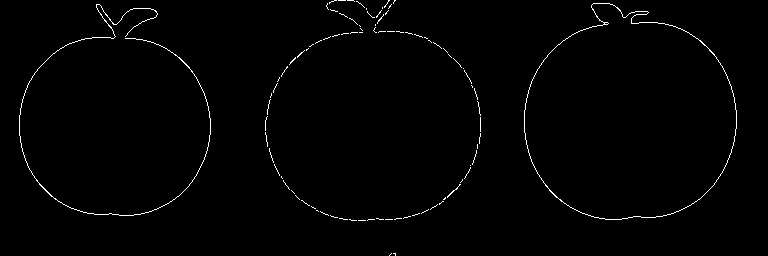

  4%|▍         | 1/25 [00:06<02:35,  6.50s/it]

Time for image 0 6.495436906814575
428.60149937088875


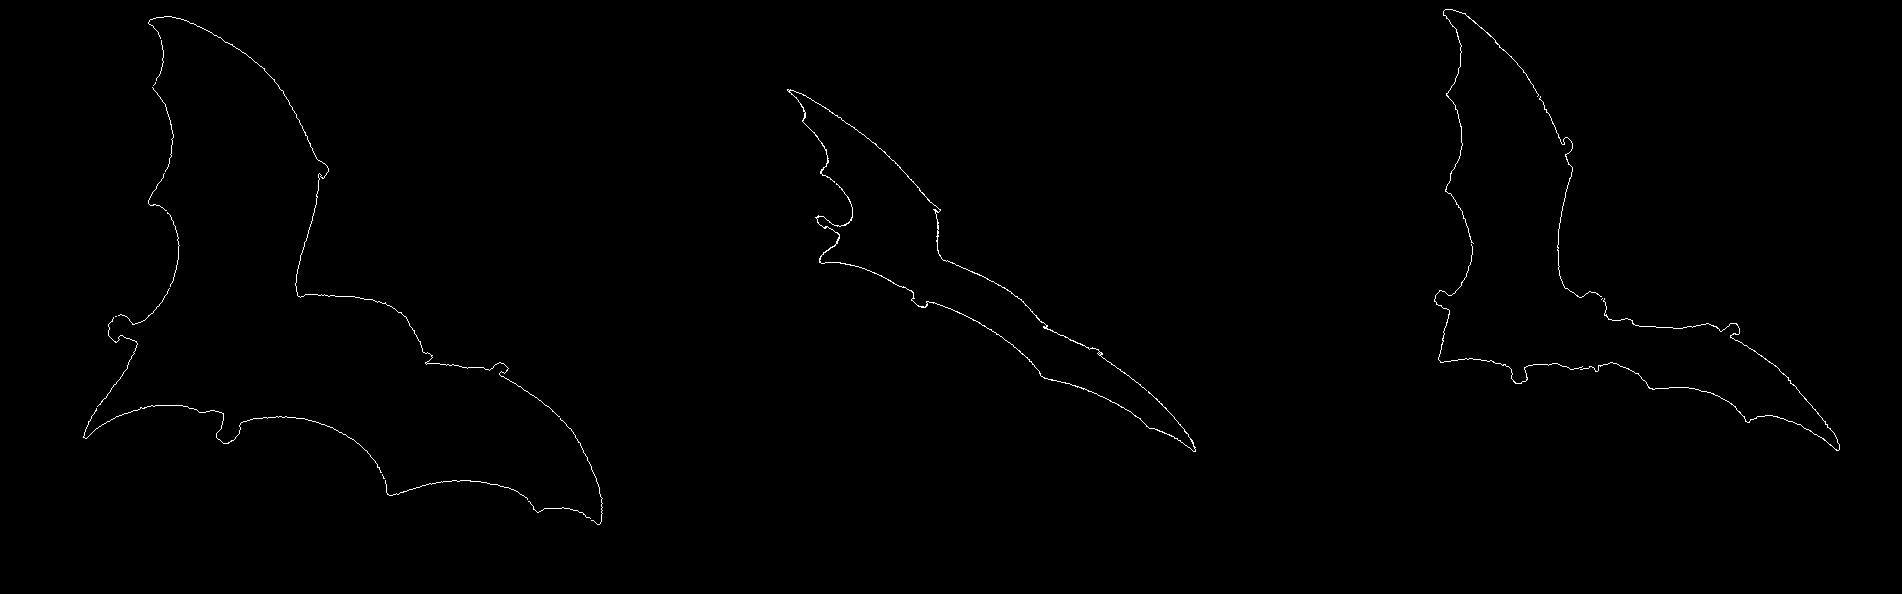

426.19476469299445


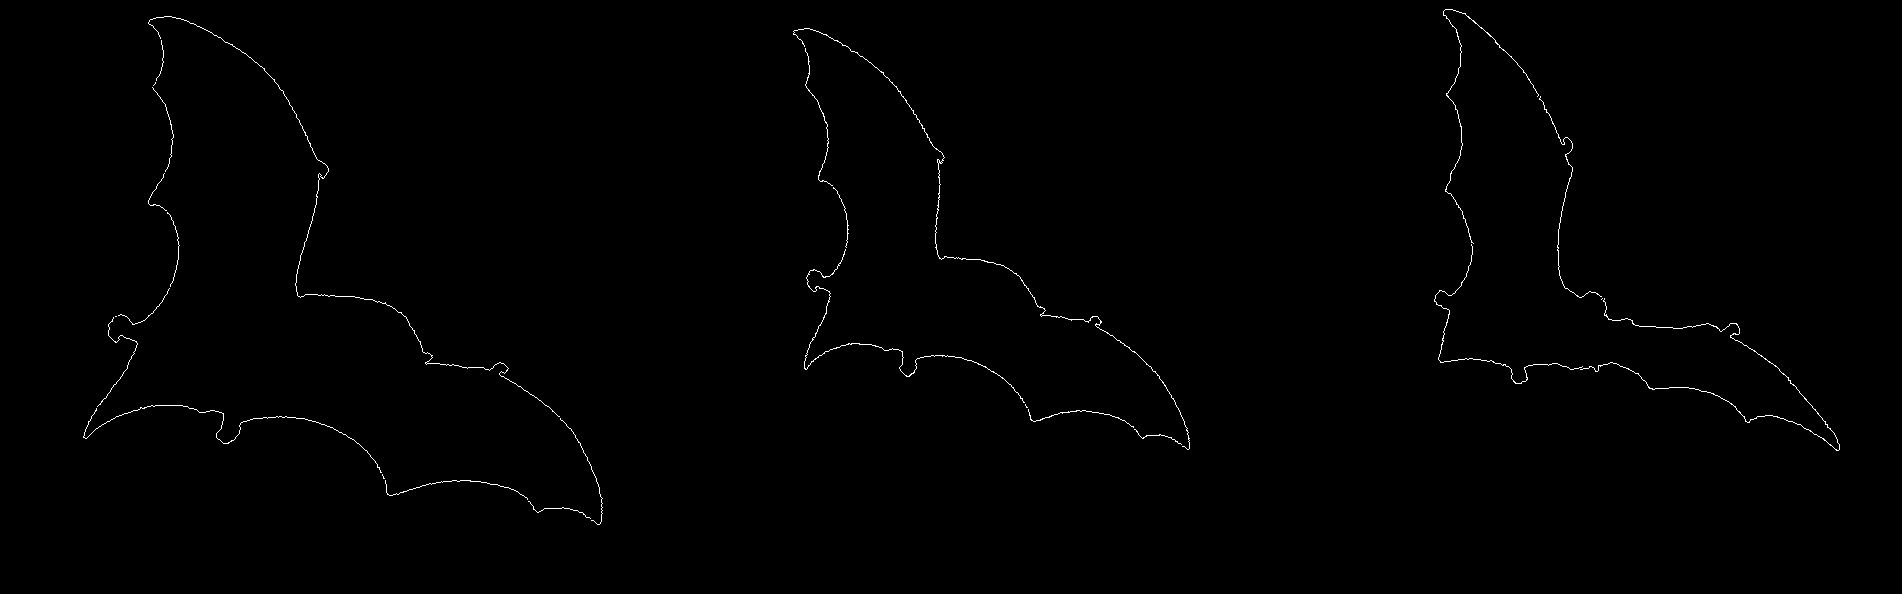

412.82226068848865


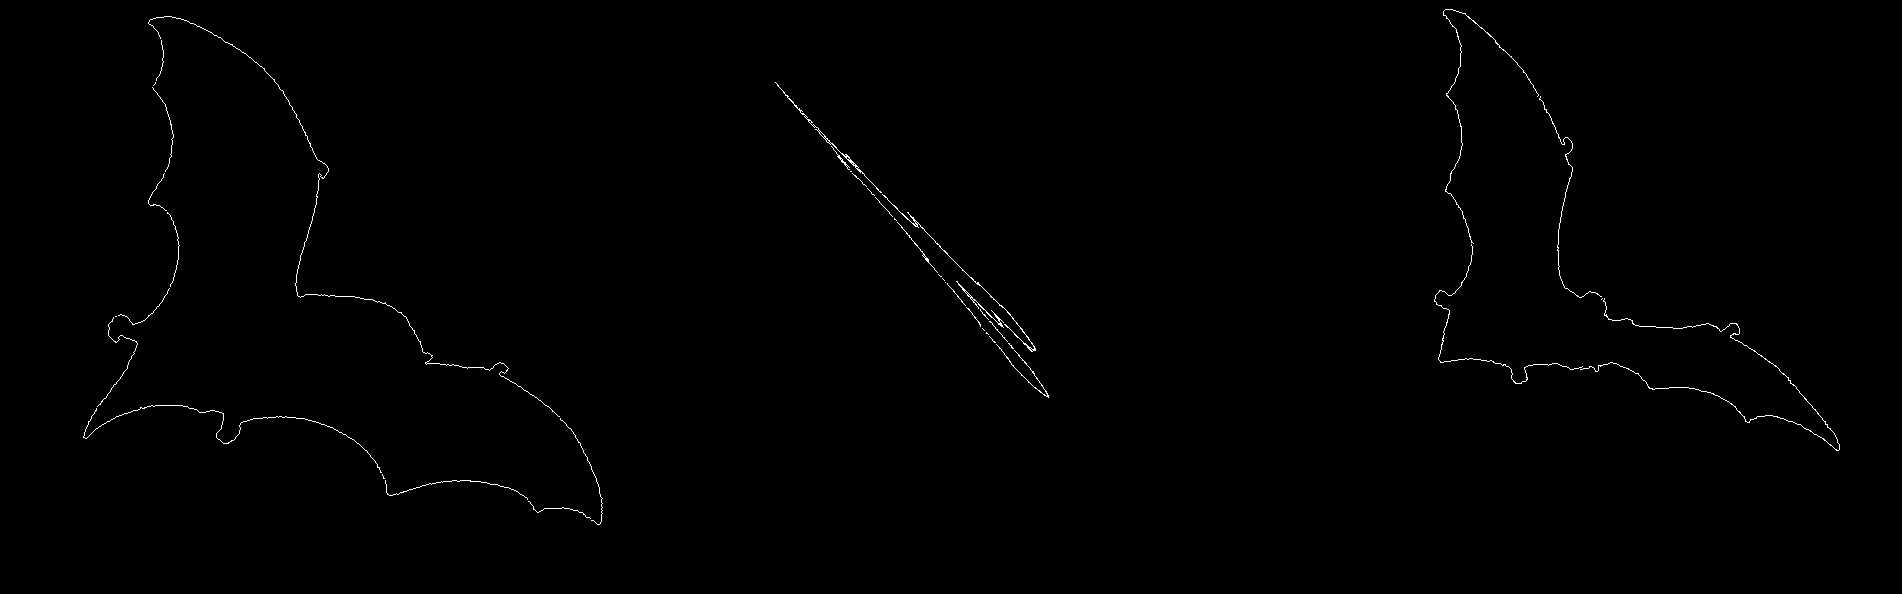

416.85784522305516


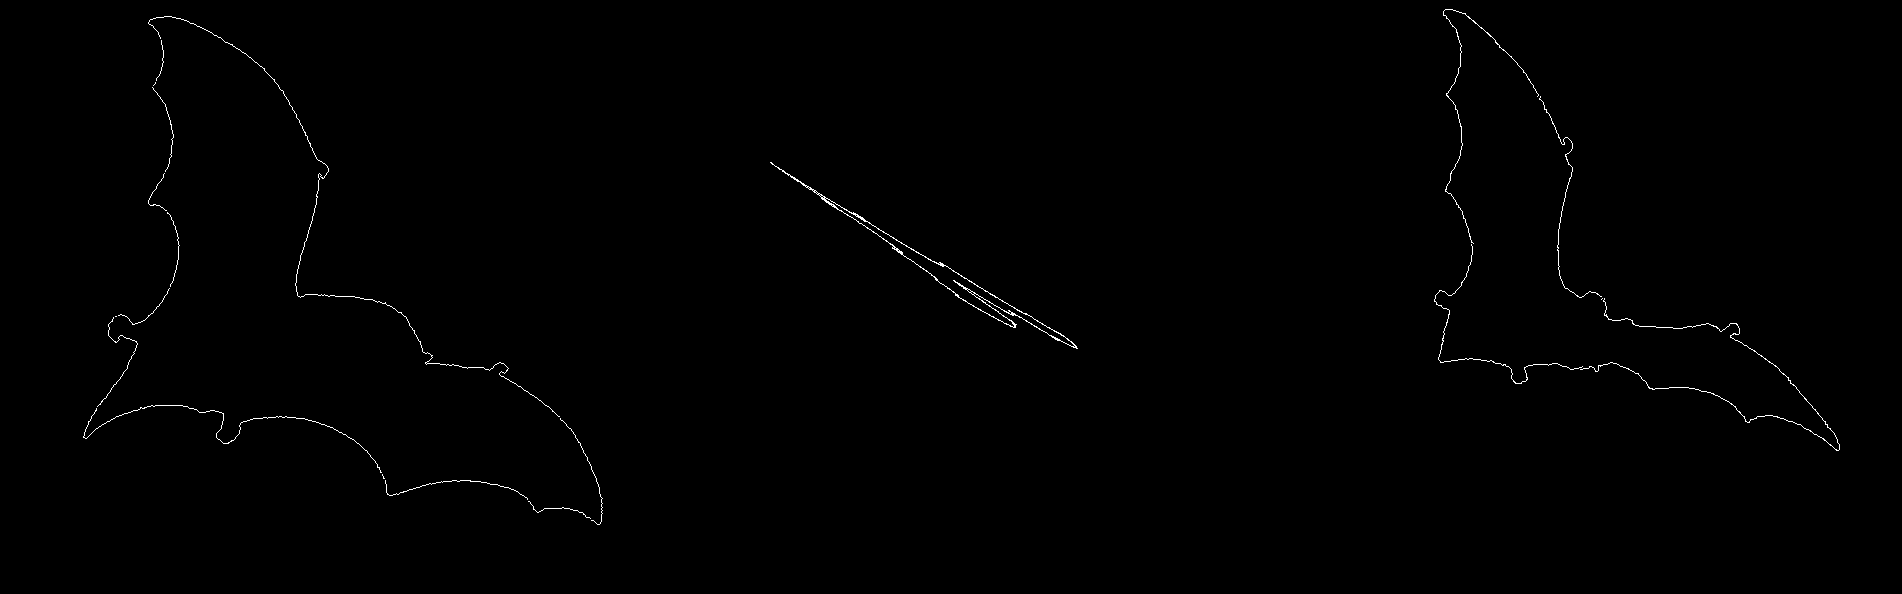

433.502221754709


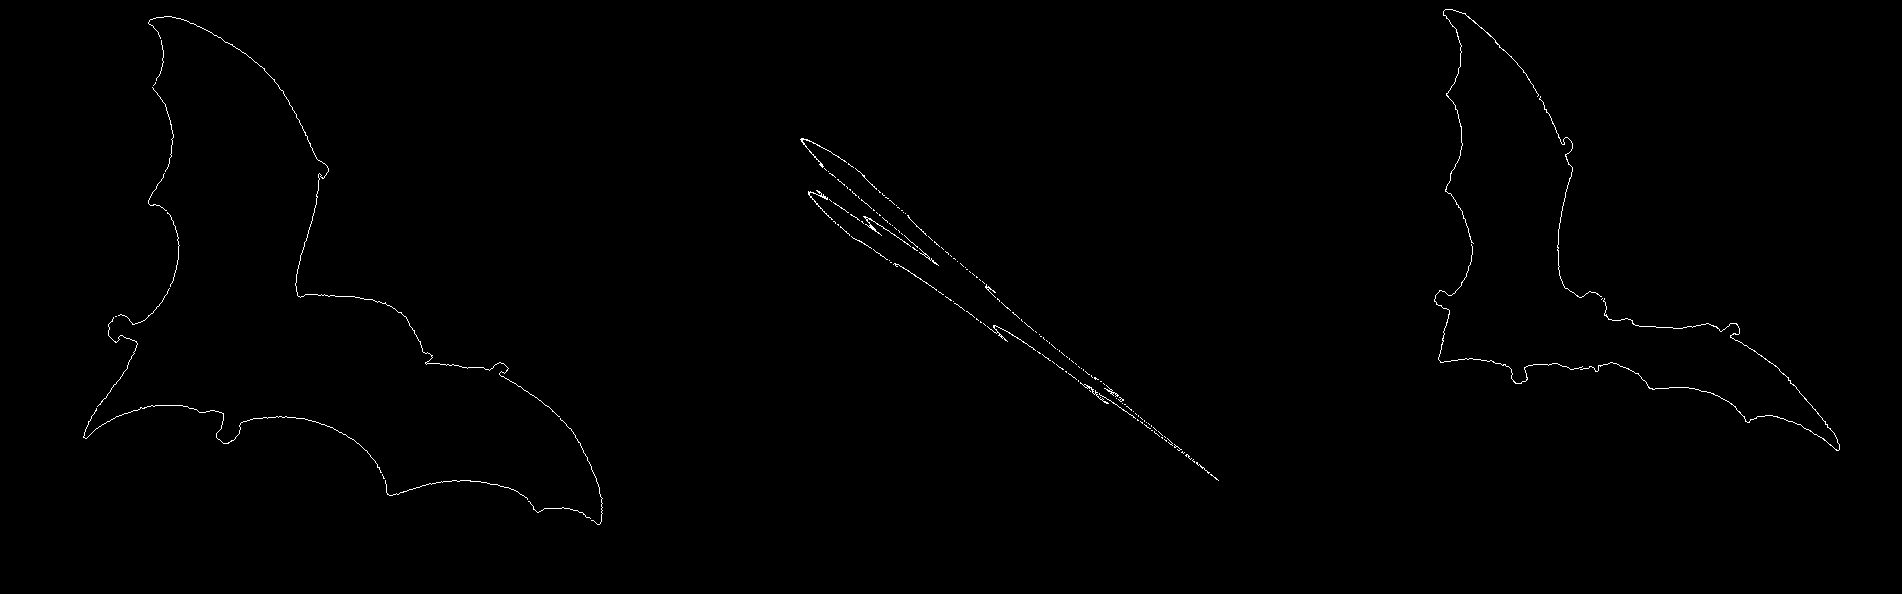

427.4451572797241


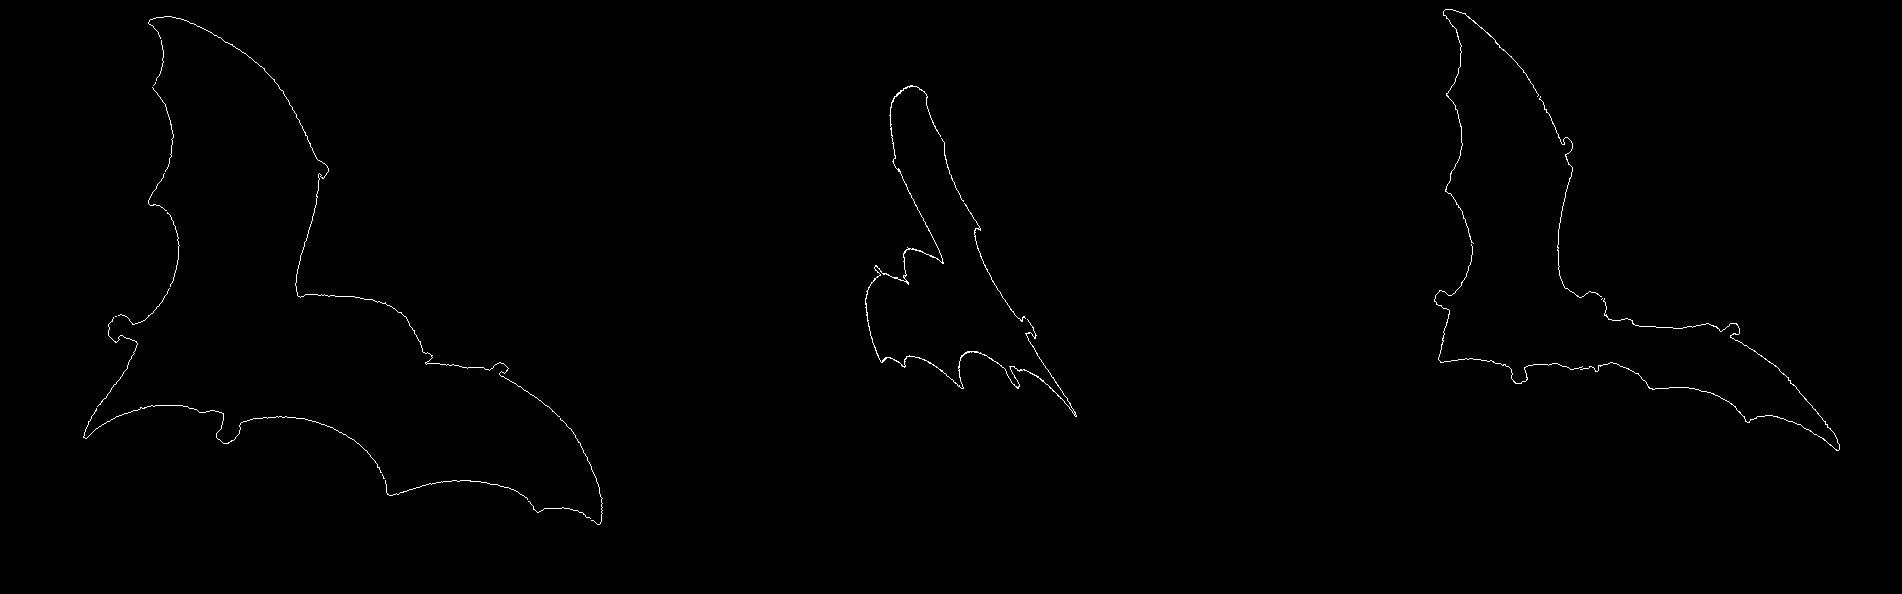

  8%|▊         | 2/25 [00:40<08:37, 22.52s/it]

Time for image 1 33.7229437828064
178.5035421000762


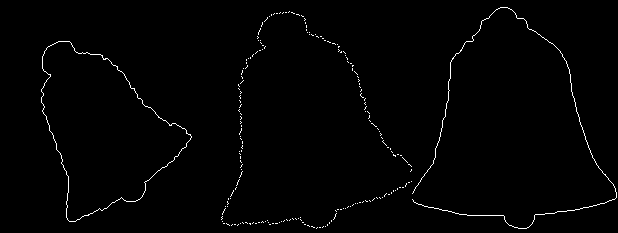

178.38133733853323


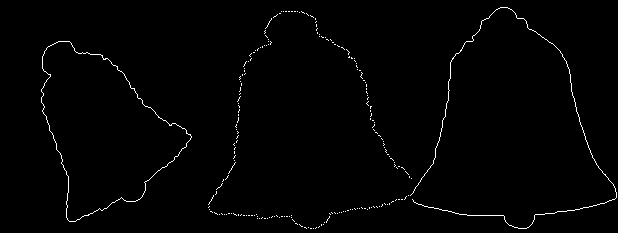

181.82857109531744


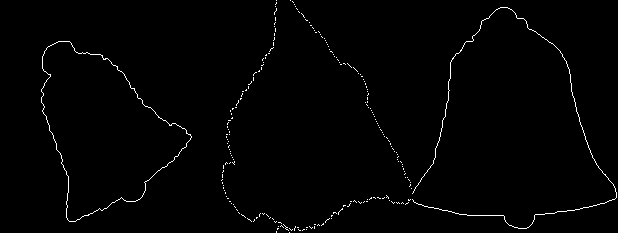

181.5707825201393


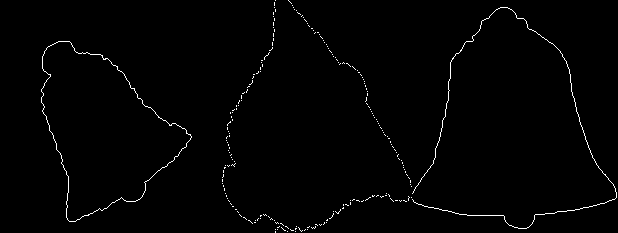

182.02395905385885


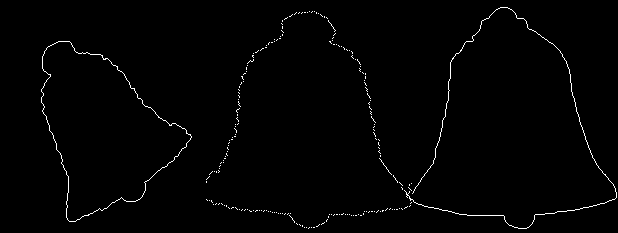

182.37804345764437


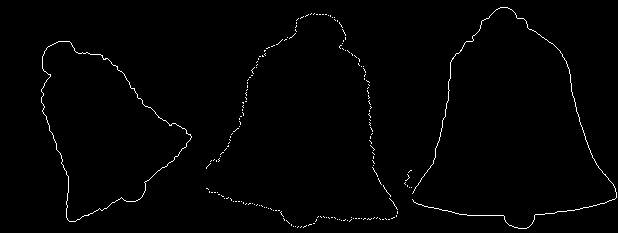

 12%|█▏        | 3/25 [00:44<05:12, 14.21s/it]

Time for image 2 4.331320762634277
235.6229505626995


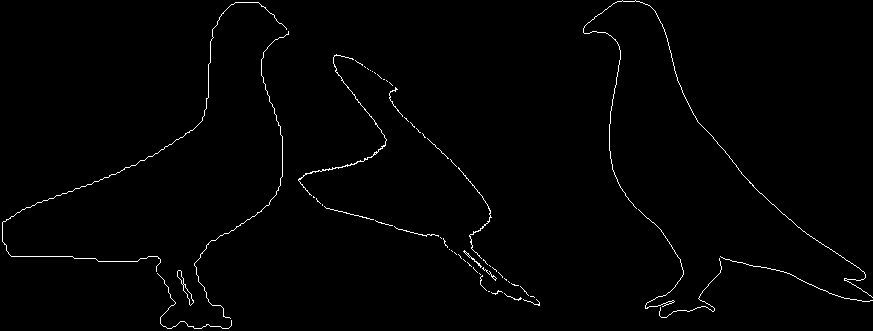

233.12722513772292


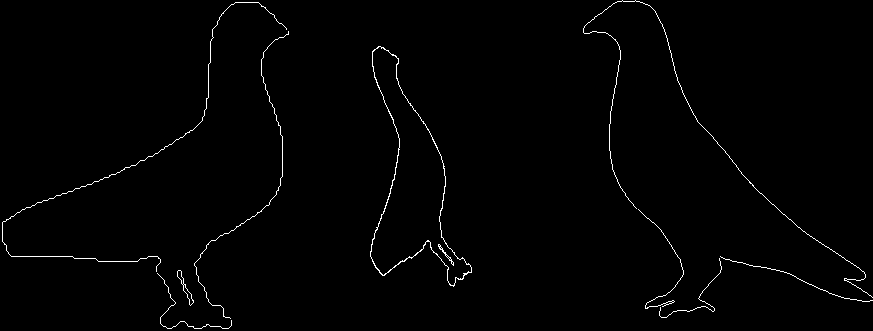

234.59823976345035


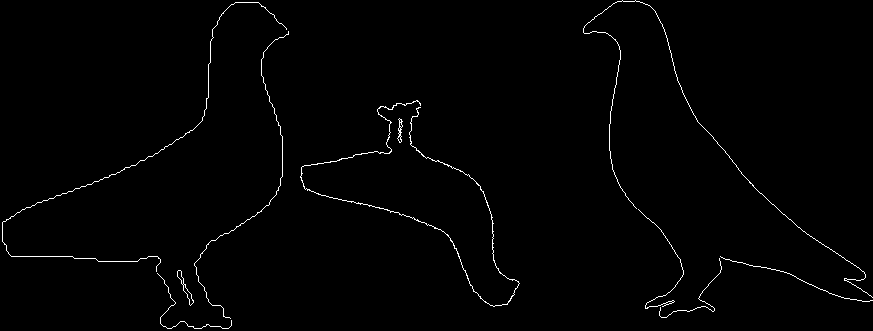

235.20324558846397


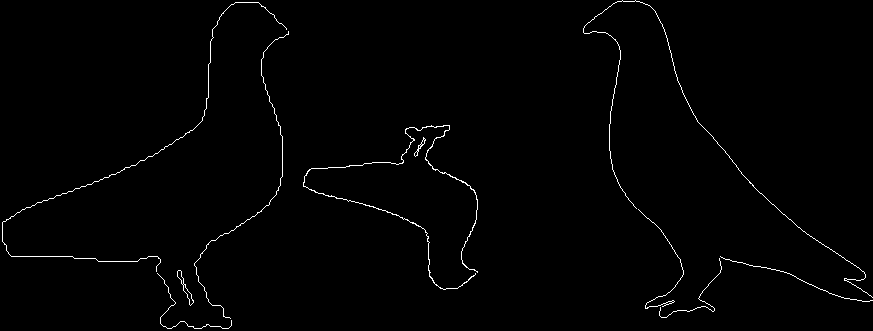

240.08262043884537


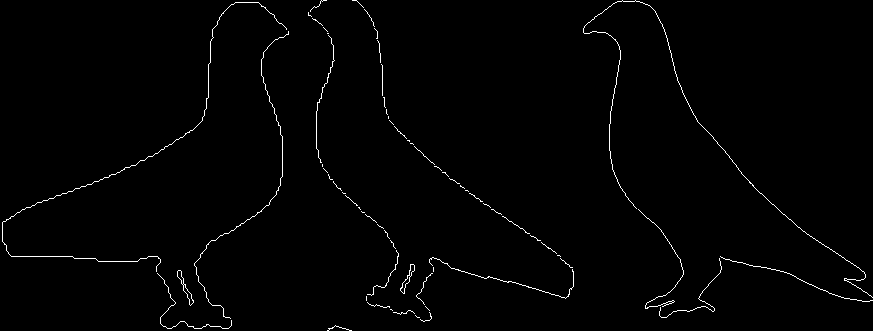

239.8076780590288


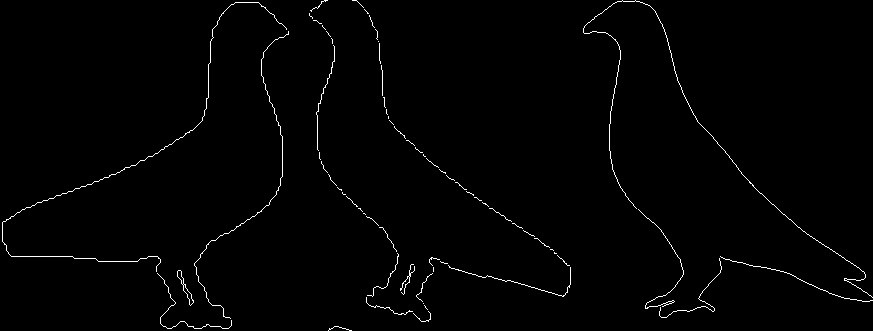

 16%|█▌        | 4/25 [01:01<05:18, 15.15s/it]

Time for image 3 16.572120904922485
300.2794768168665


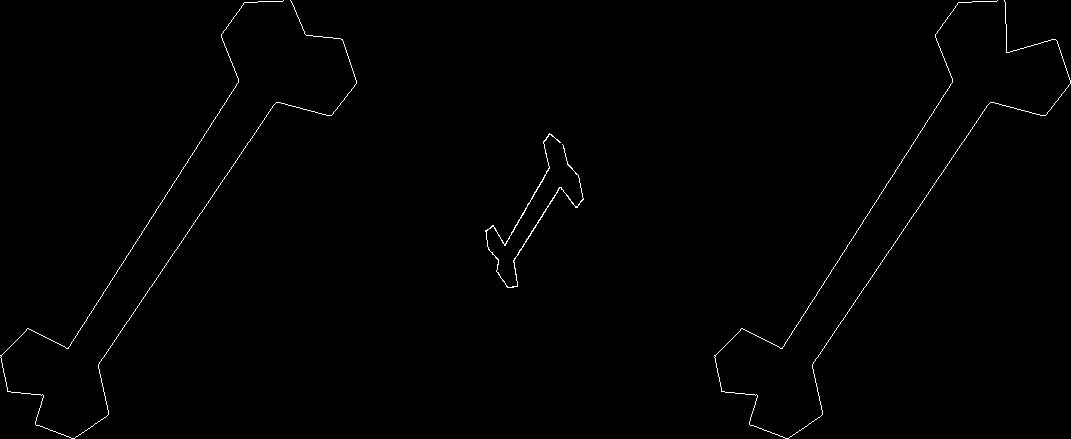

320.16399201195156


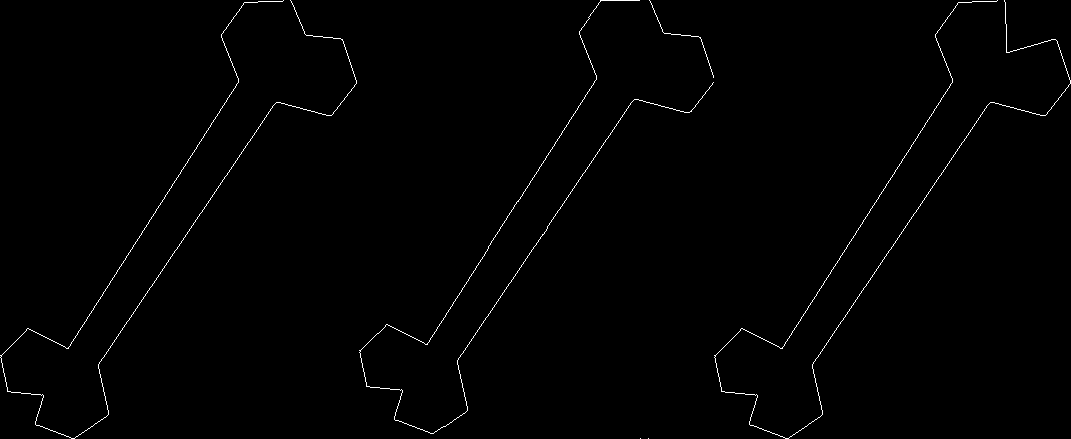

305.39322419311134


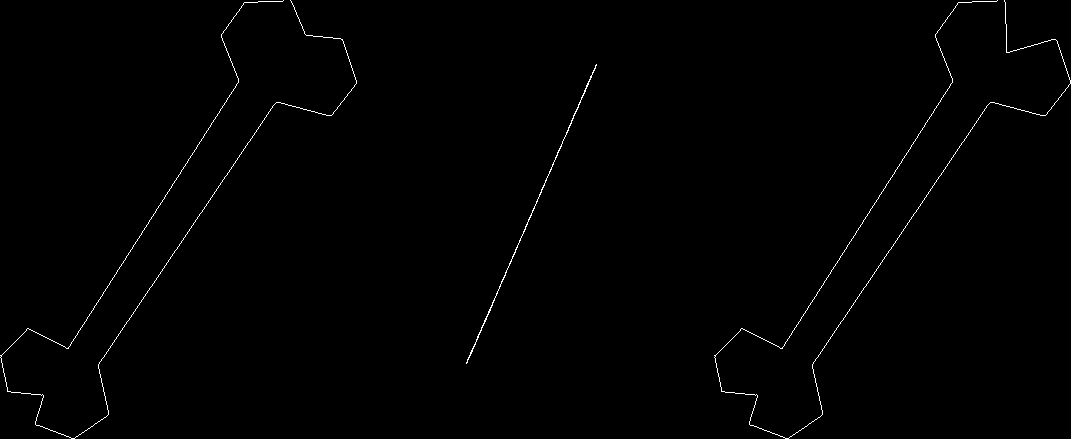

304.7407620246787


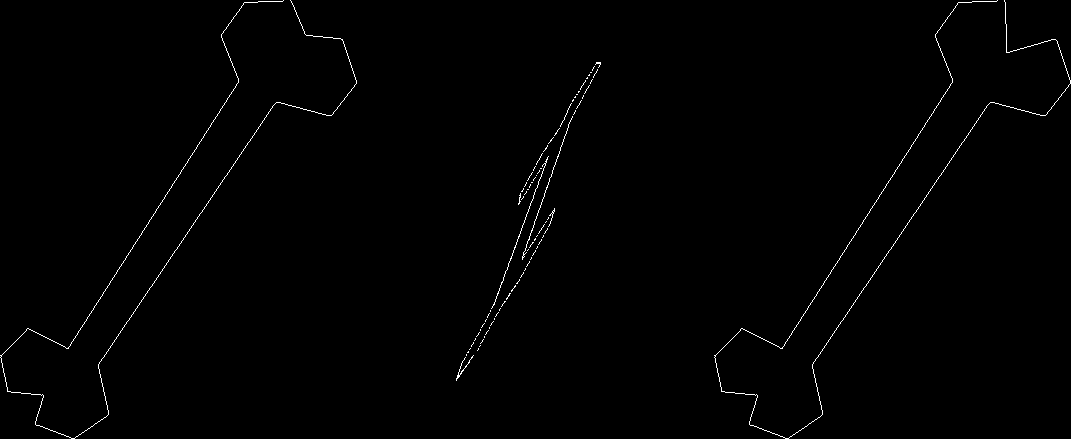

304.4362851197276


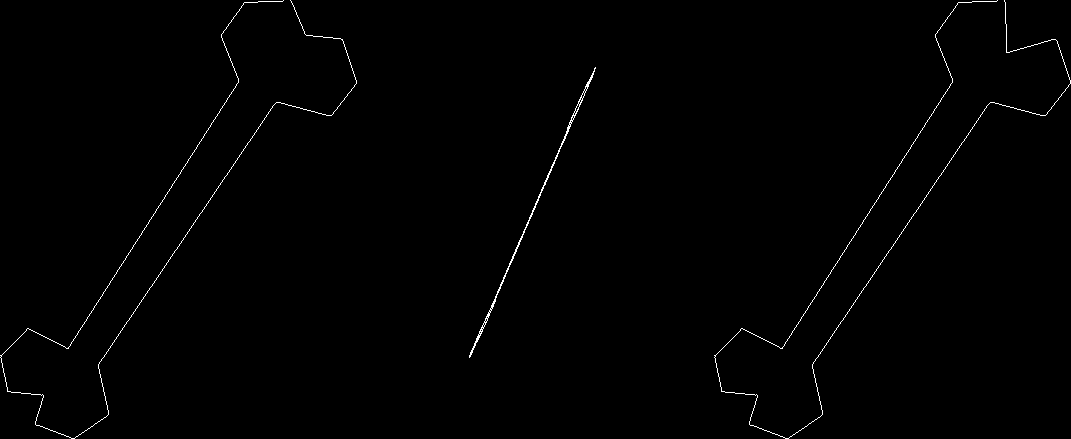

302.1198291354134


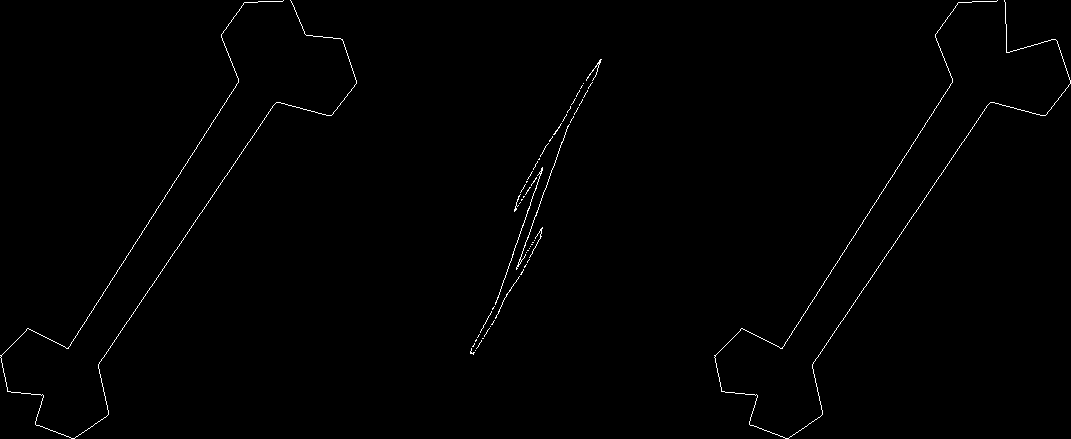

 20%|██        | 5/25 [01:18<05:19, 15.98s/it]

Time for image 4 17.441204071044922
245.493246882648


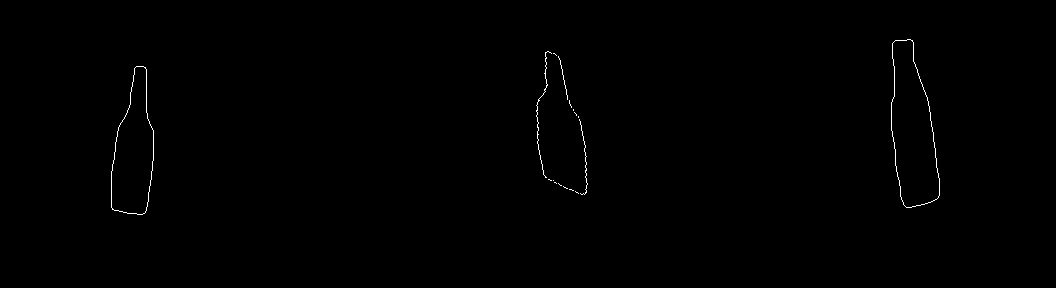

246.02385608701485


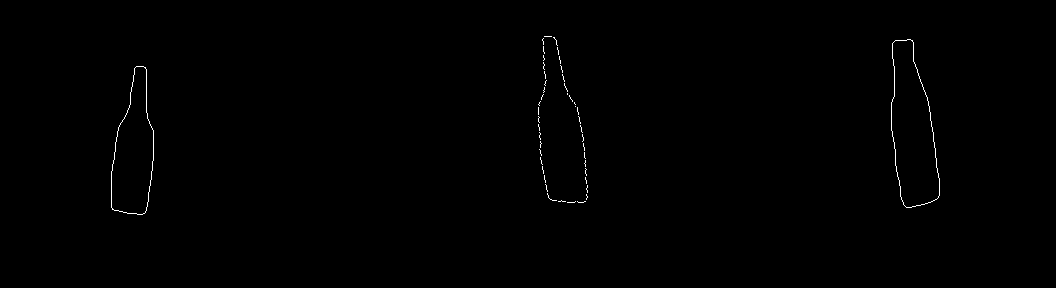

246.7742067256969


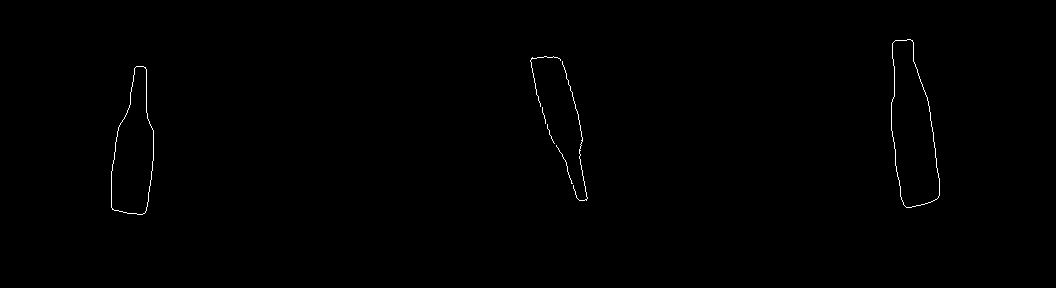

246.0838862851271


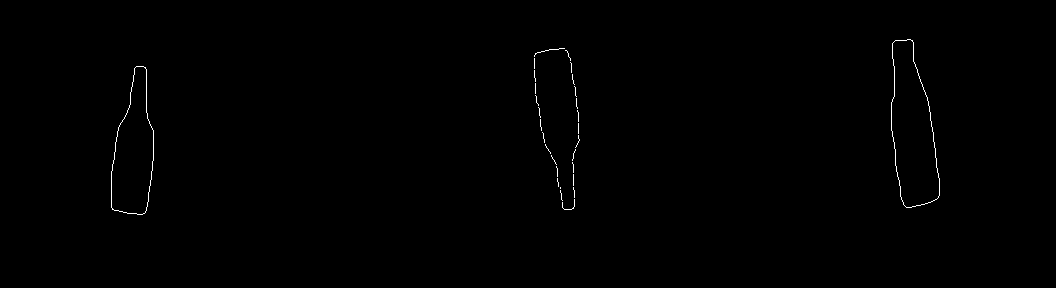

245.7329340685315


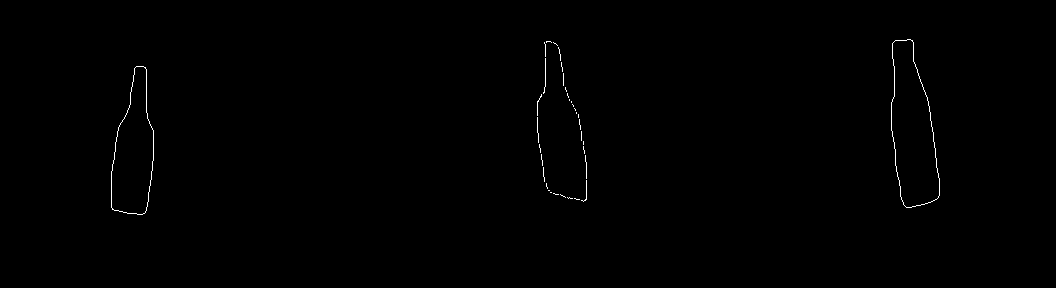

246.01740329027905


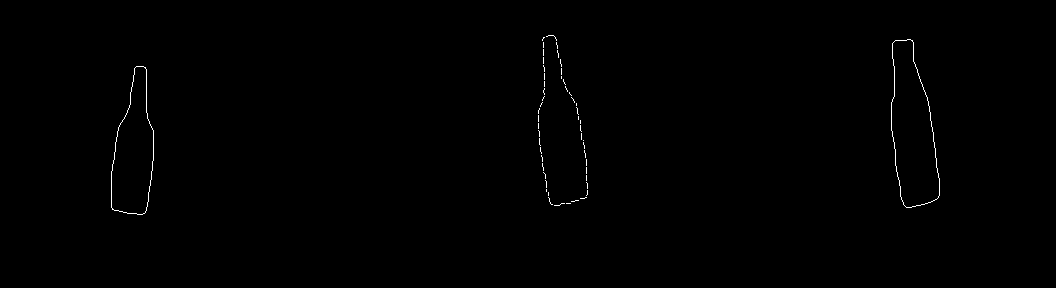

 24%|██▍       | 6/25 [01:21<03:35, 11.37s/it]

Time for image 5 2.4092087745666504
298.5067867383556


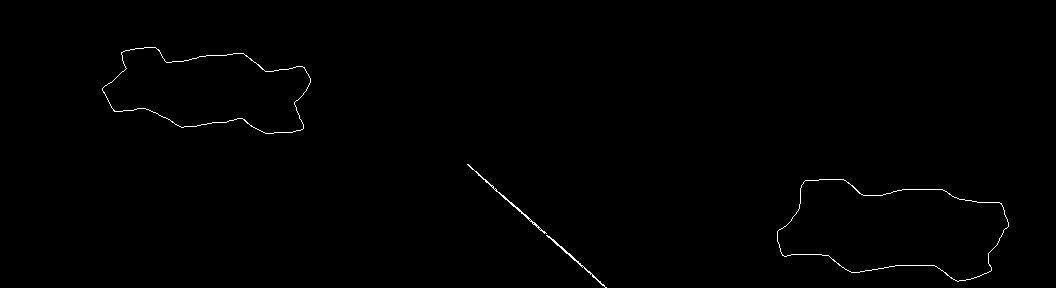

302.7984771386897


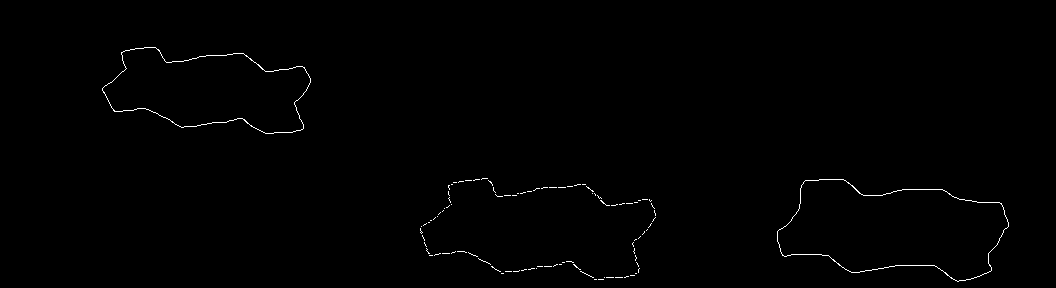

298.9840775169684


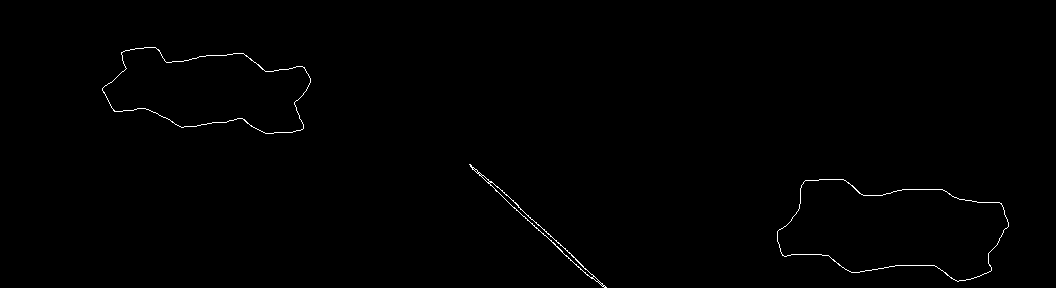

301.92524161491735


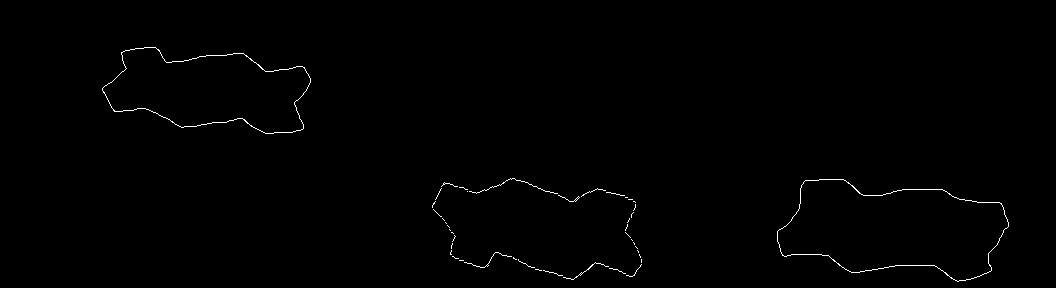

298.60472740034186


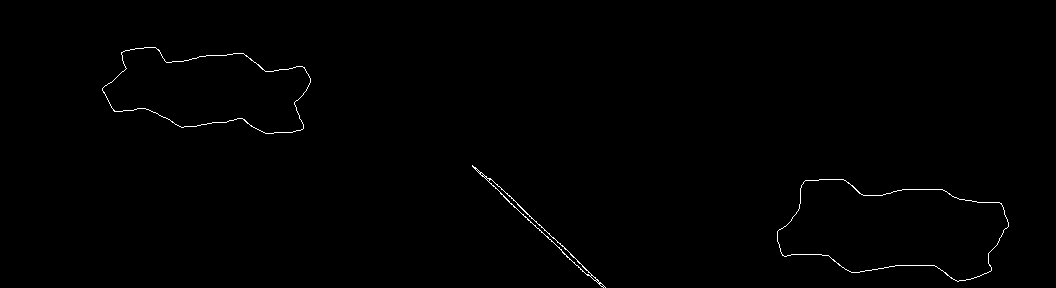

301.58626007579664


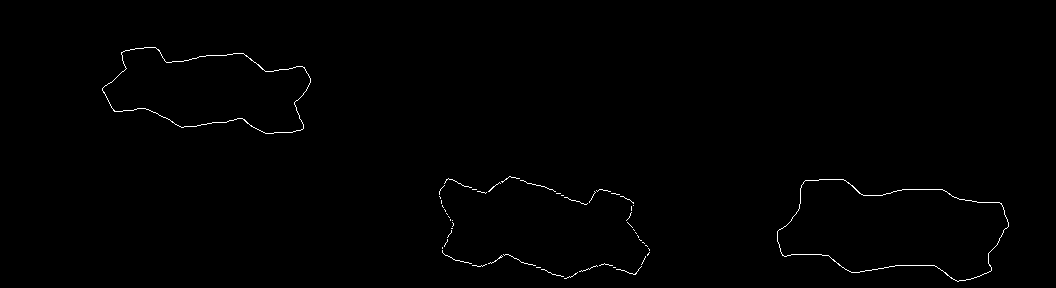

 28%|██▊       | 7/25 [01:25<02:43,  9.07s/it]

Time for image 6 4.344936847686768
217.17637806664573


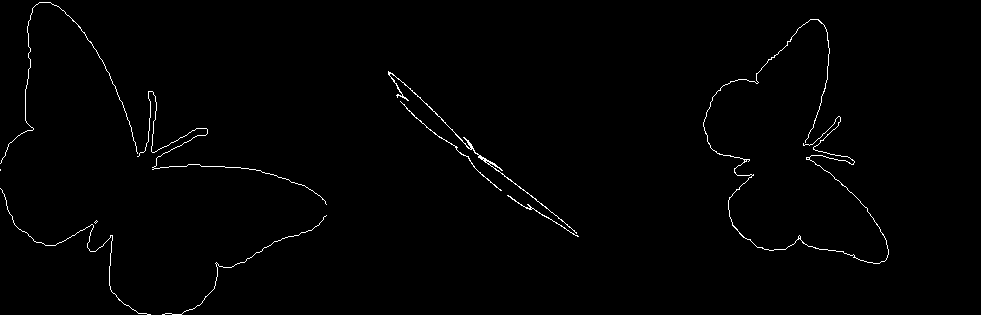

215.84572437437976


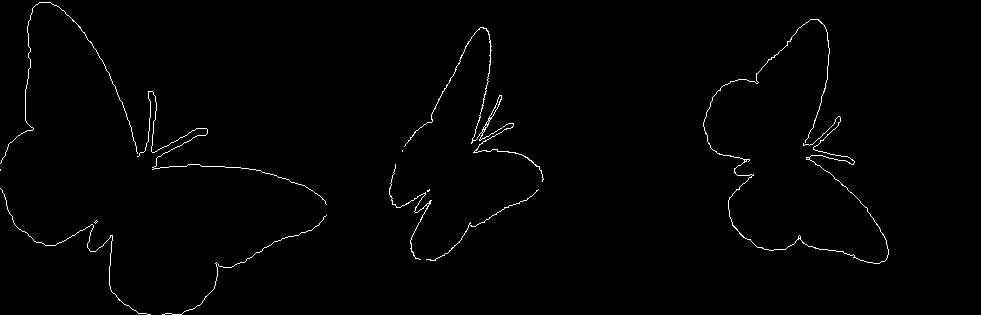

213.54288499434543


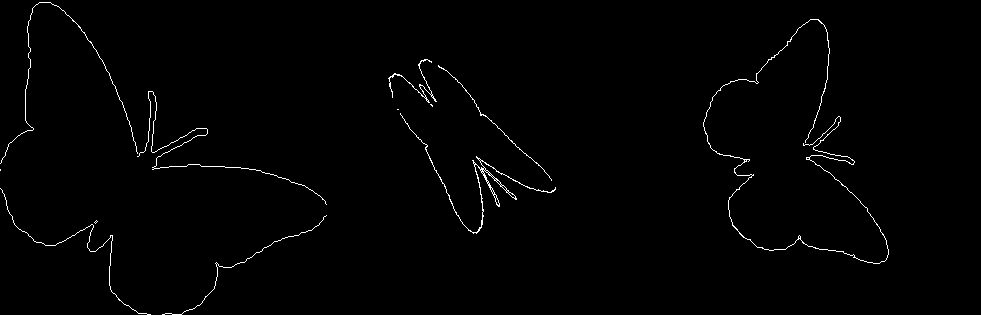

214.21465106040088


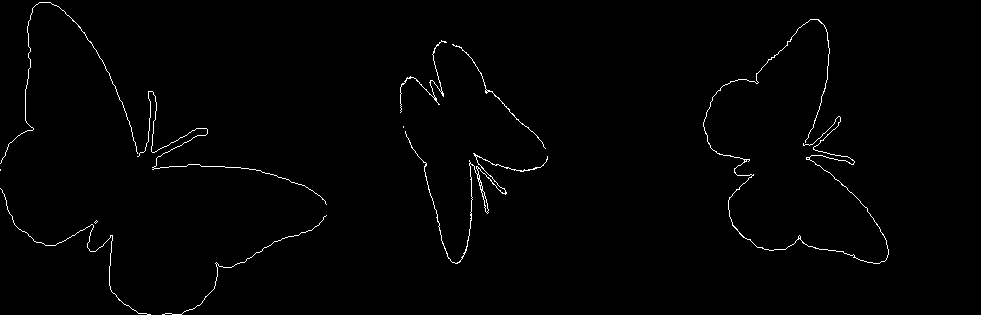

215.48481756114944


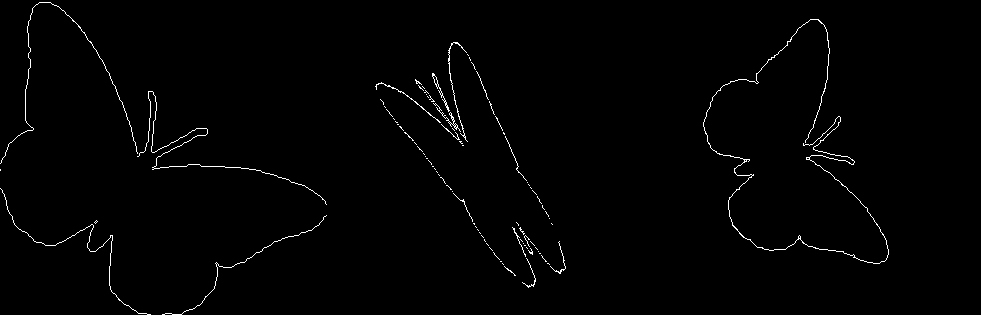

218.68256321213588


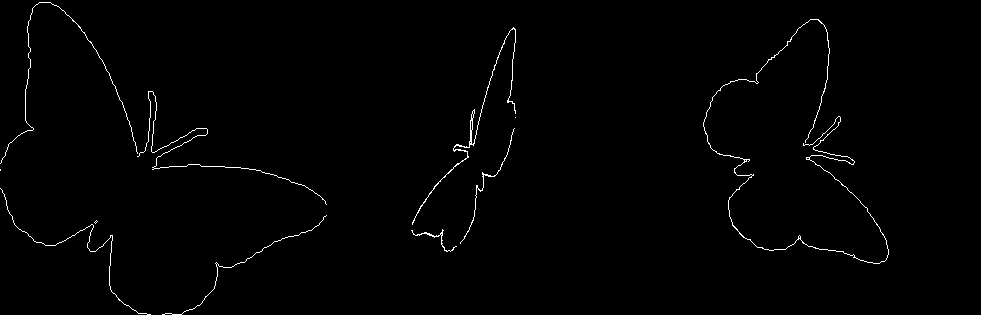

 32%|███▏      | 8/25 [01:42<03:18, 11.68s/it]

Time for image 7 17.250091791152954
270.5806569800781


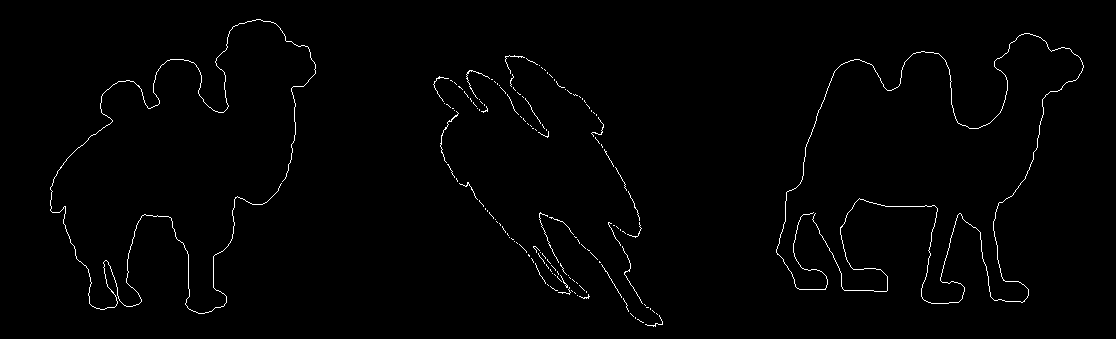

275.7971403806307


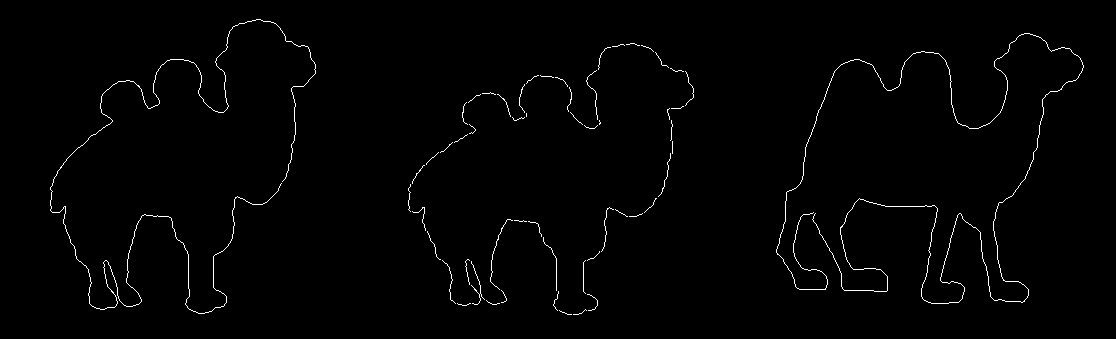

267.6657362775893


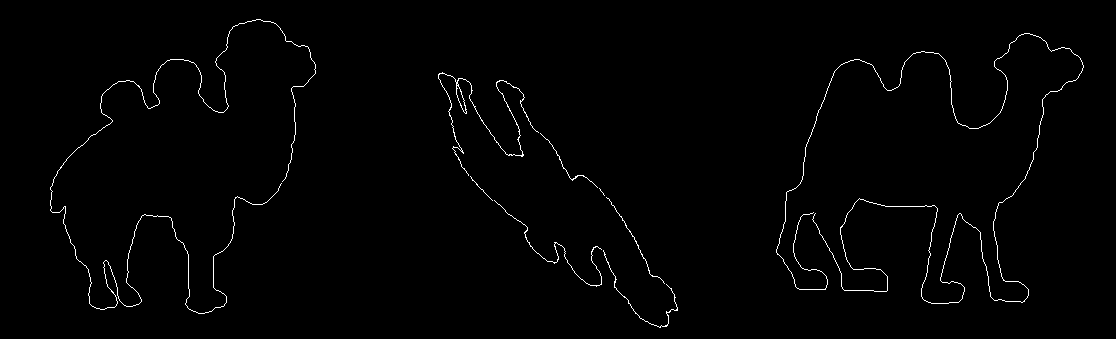

273.31067702790733


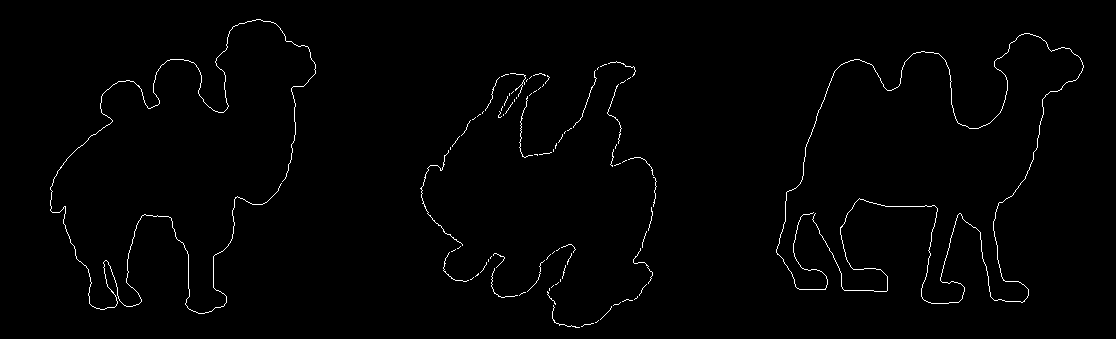

271.17052990950526


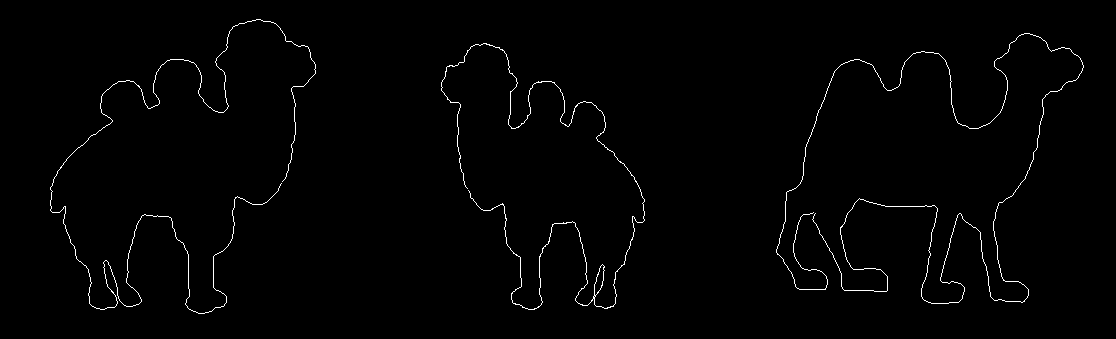

271.88311567177414


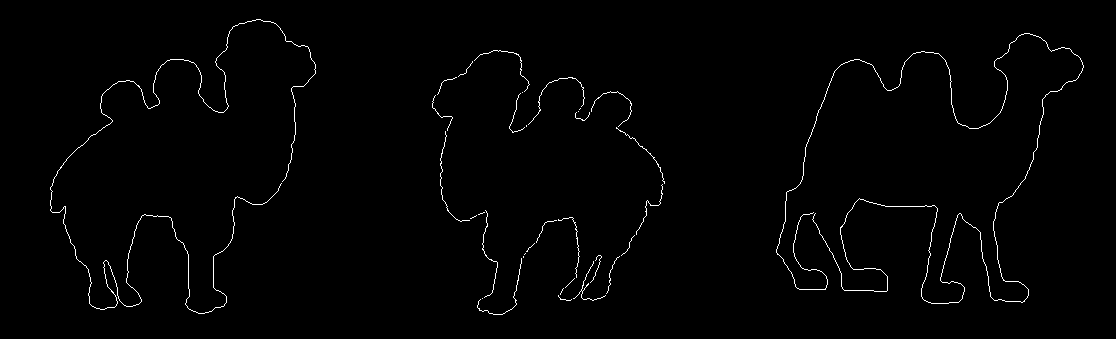

 36%|███▌      | 9/25 [02:09<04:22, 16.41s/it]

Time for image 8 26.79197645187378
238.79824330721743


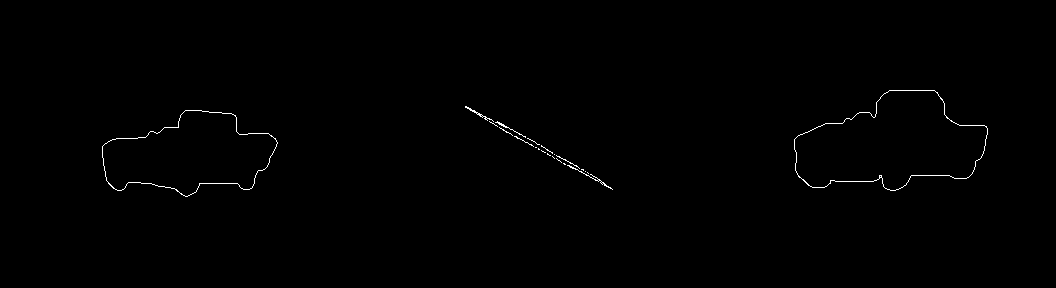

242.00133007266427


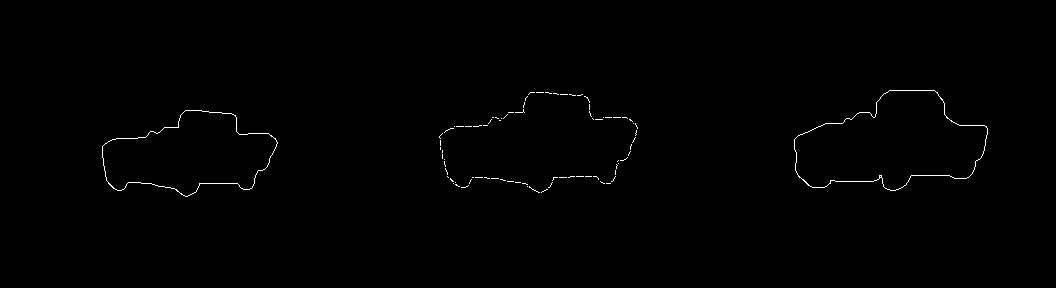

240.6594053915128


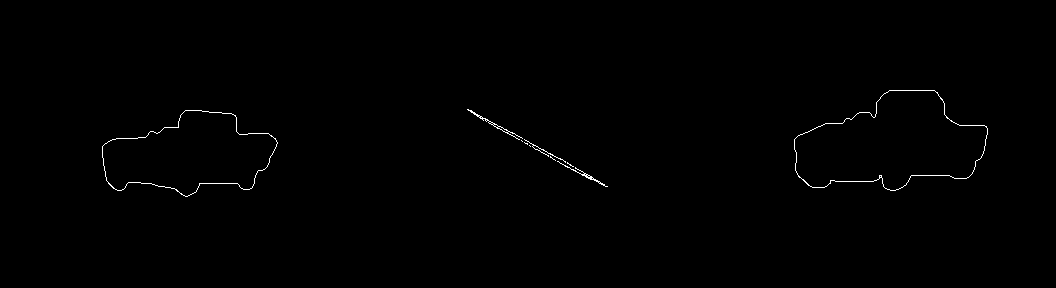

241.17784003619033


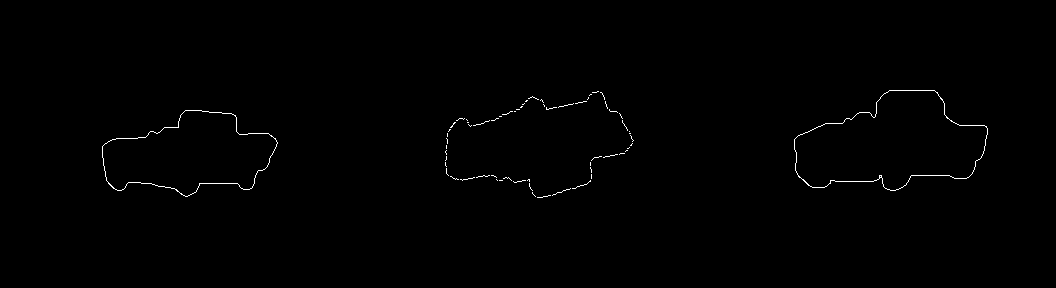

239.62578134131945


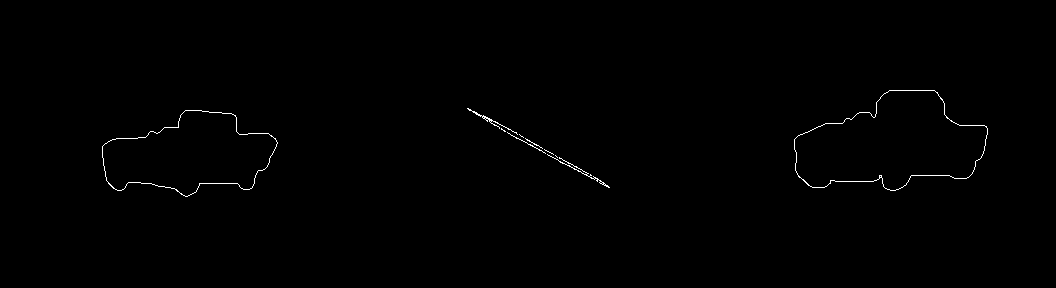

242.1662869882694


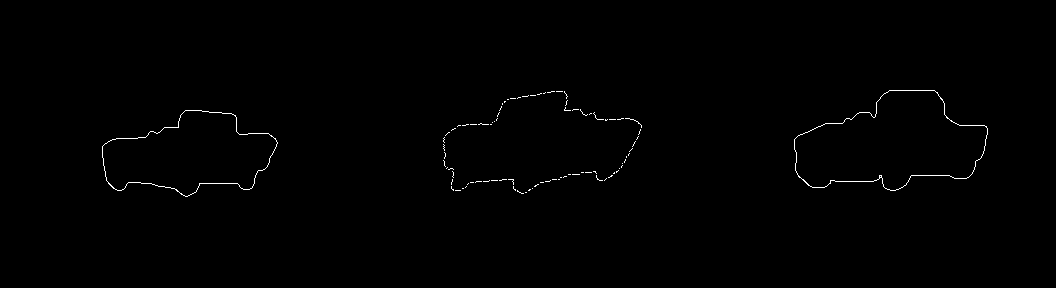

 40%|████      | 10/25 [02:13<03:07, 12.51s/it]

Time for image 9 3.784106731414795
284.0044310435636


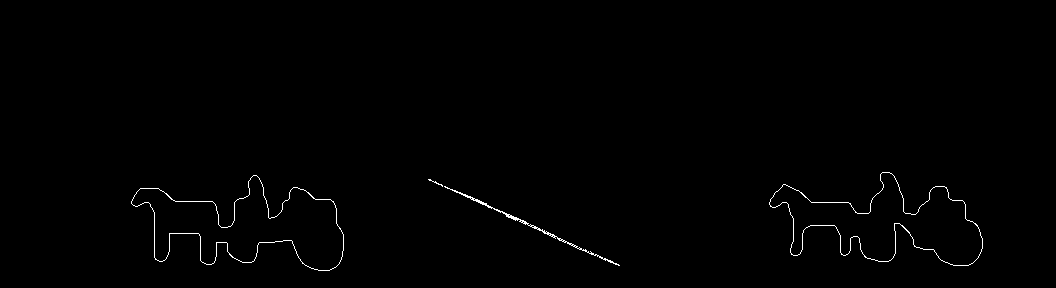

284.41209046766244


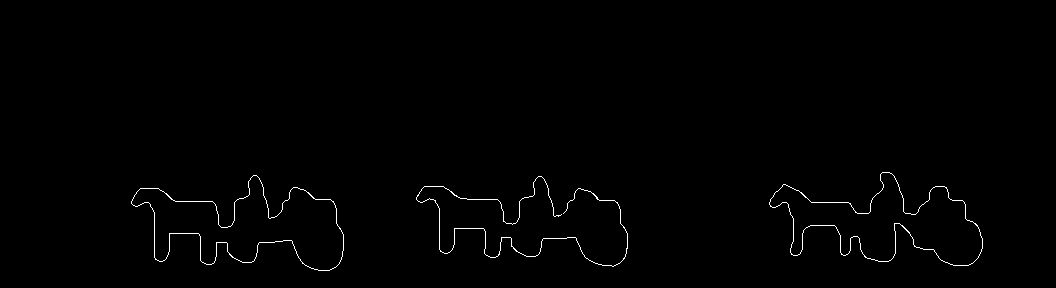

284.92303044282966


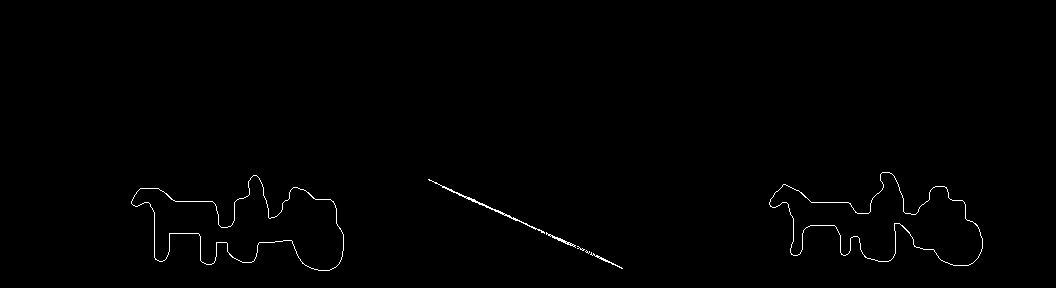

284.6922027043105


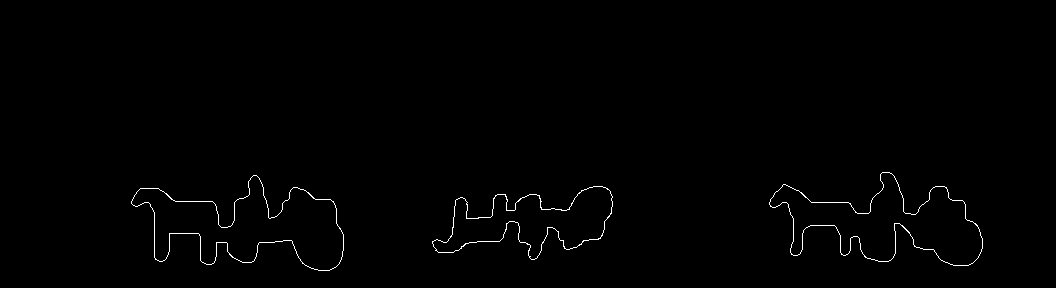

282.15638793537215


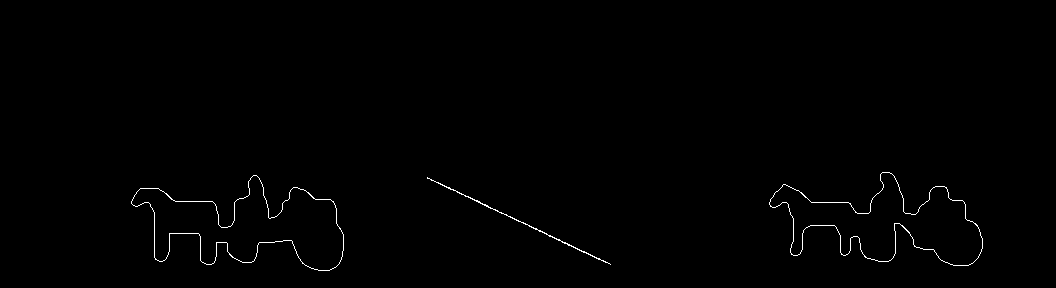

284.0769598174439


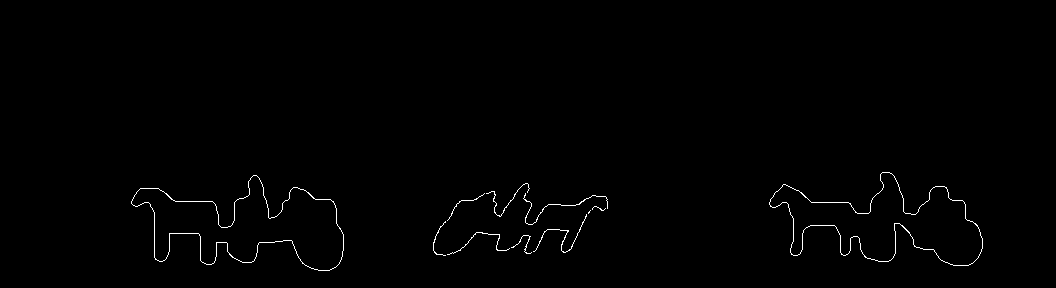

 44%|████▍     | 11/25 [02:20<02:32, 10.92s/it]

Time for image 10 7.3136961460113525
392.84408800322603


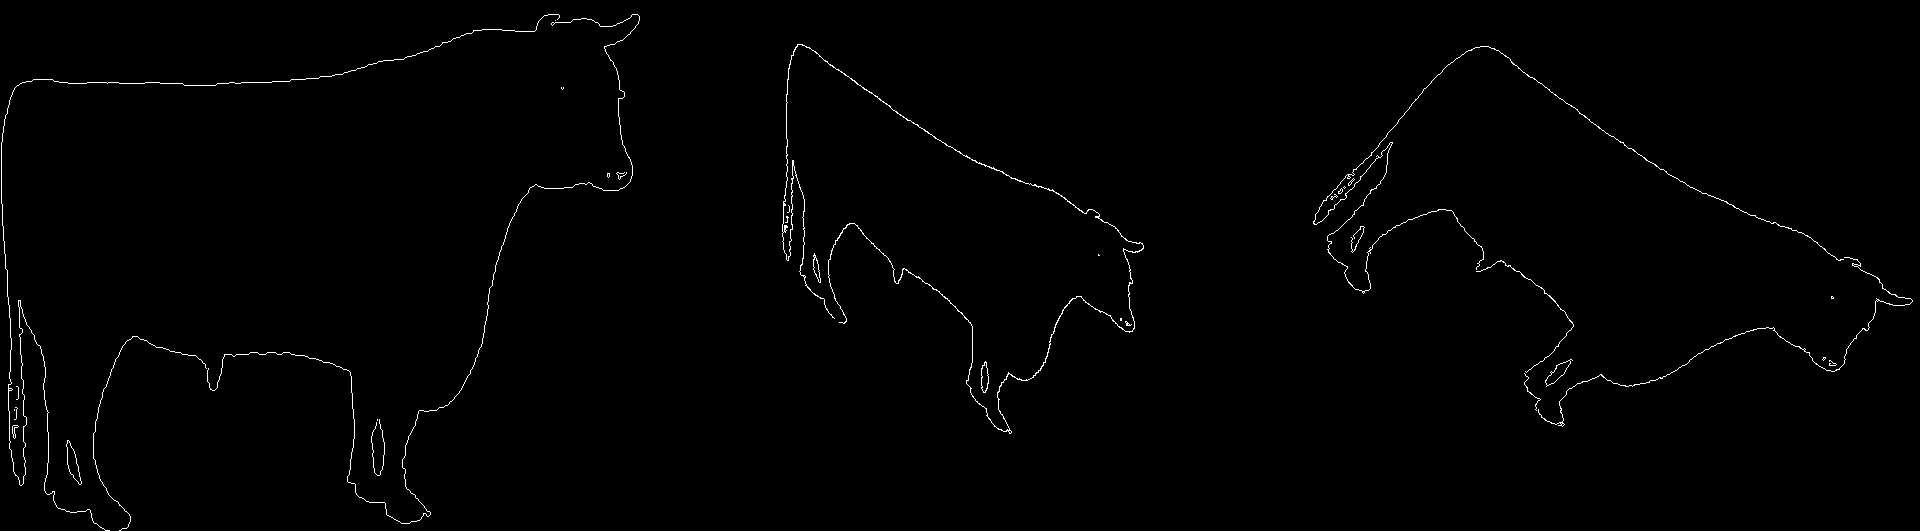

398.07233619460675


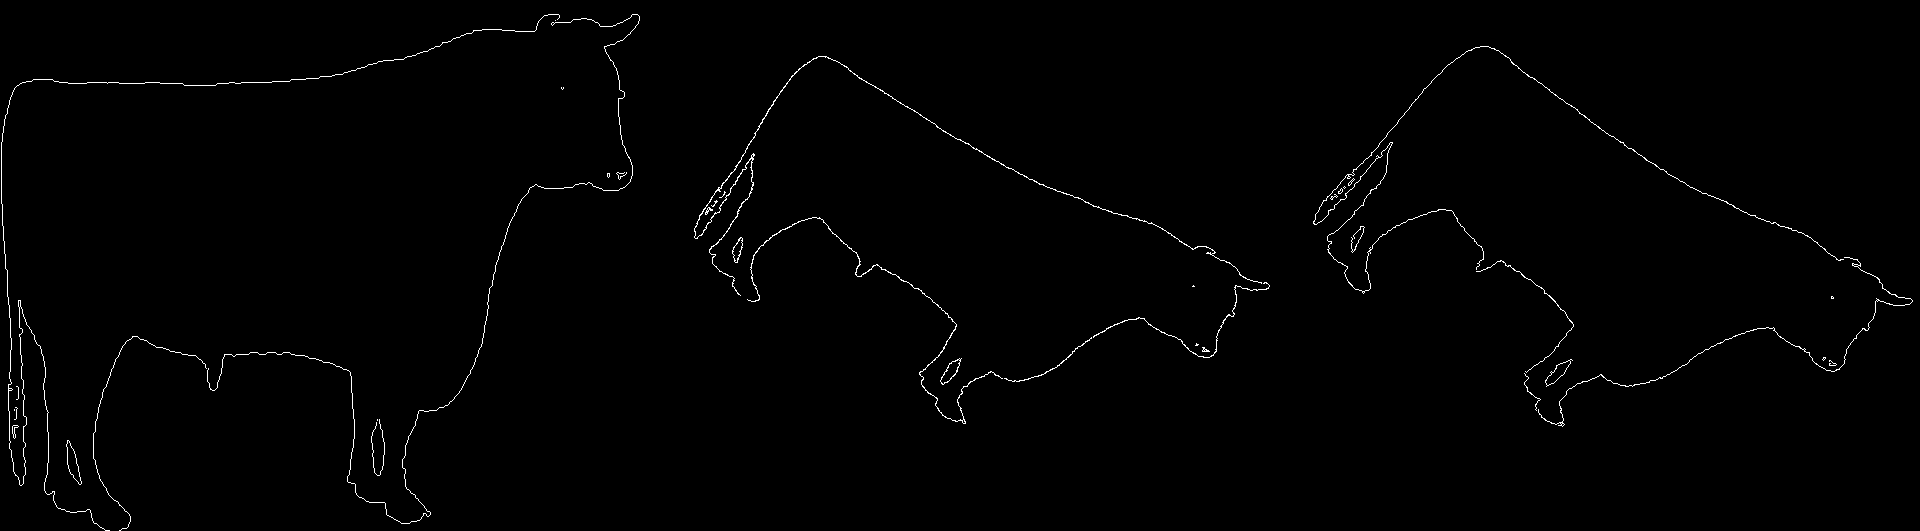

401.63713226295545


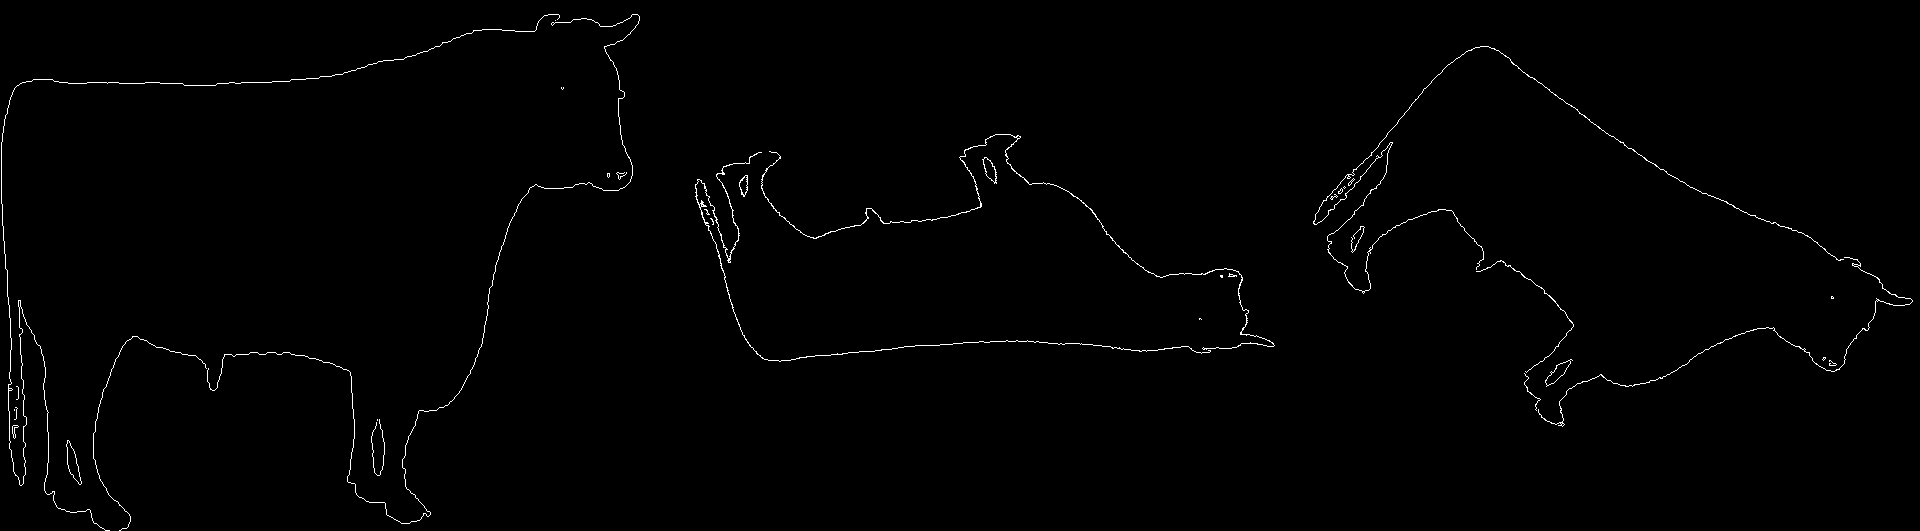

407.9380493327128


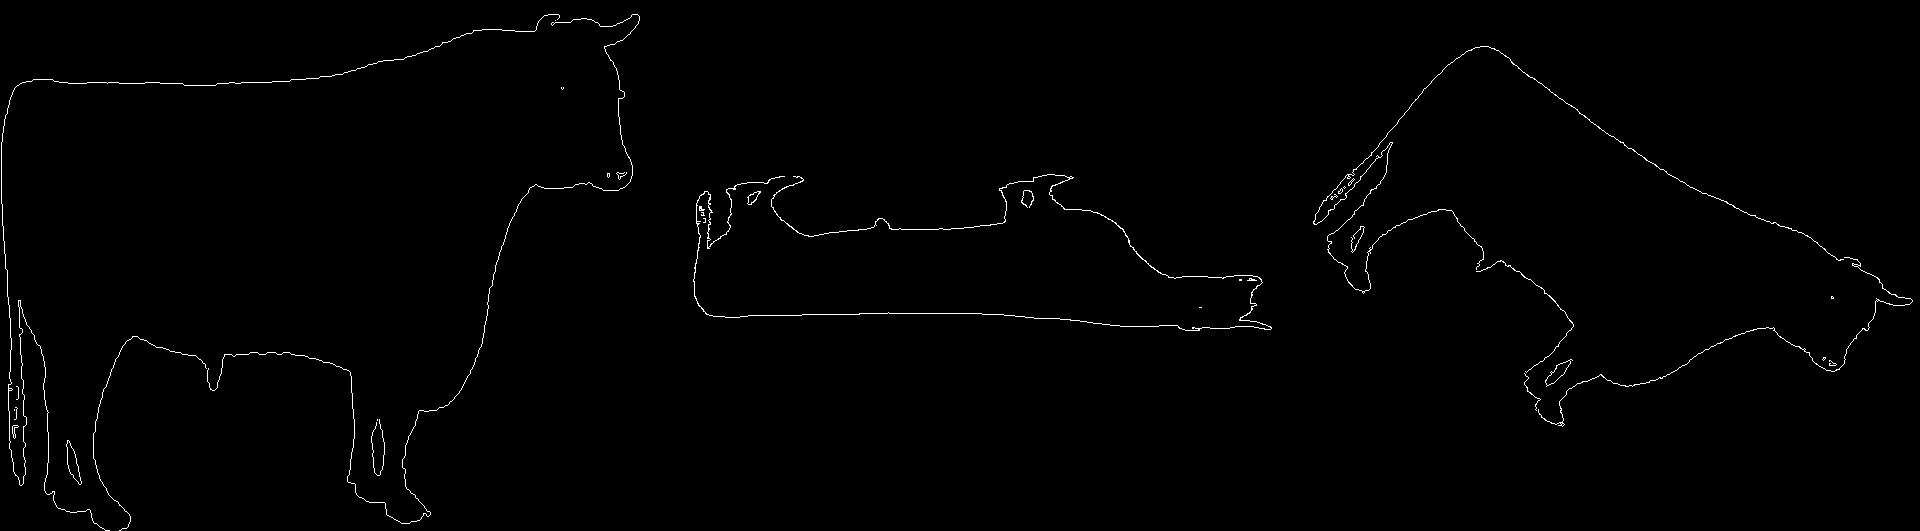

396.1278814012062


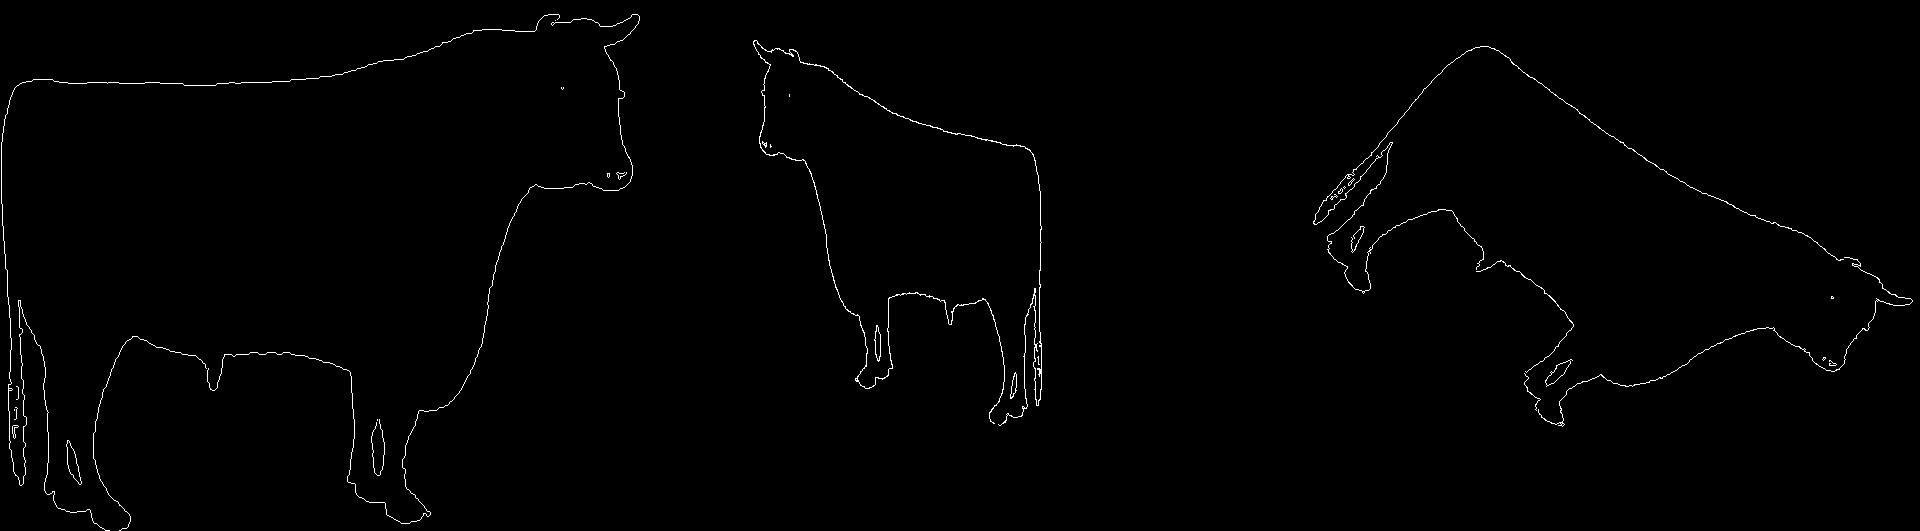

397.87460860077545


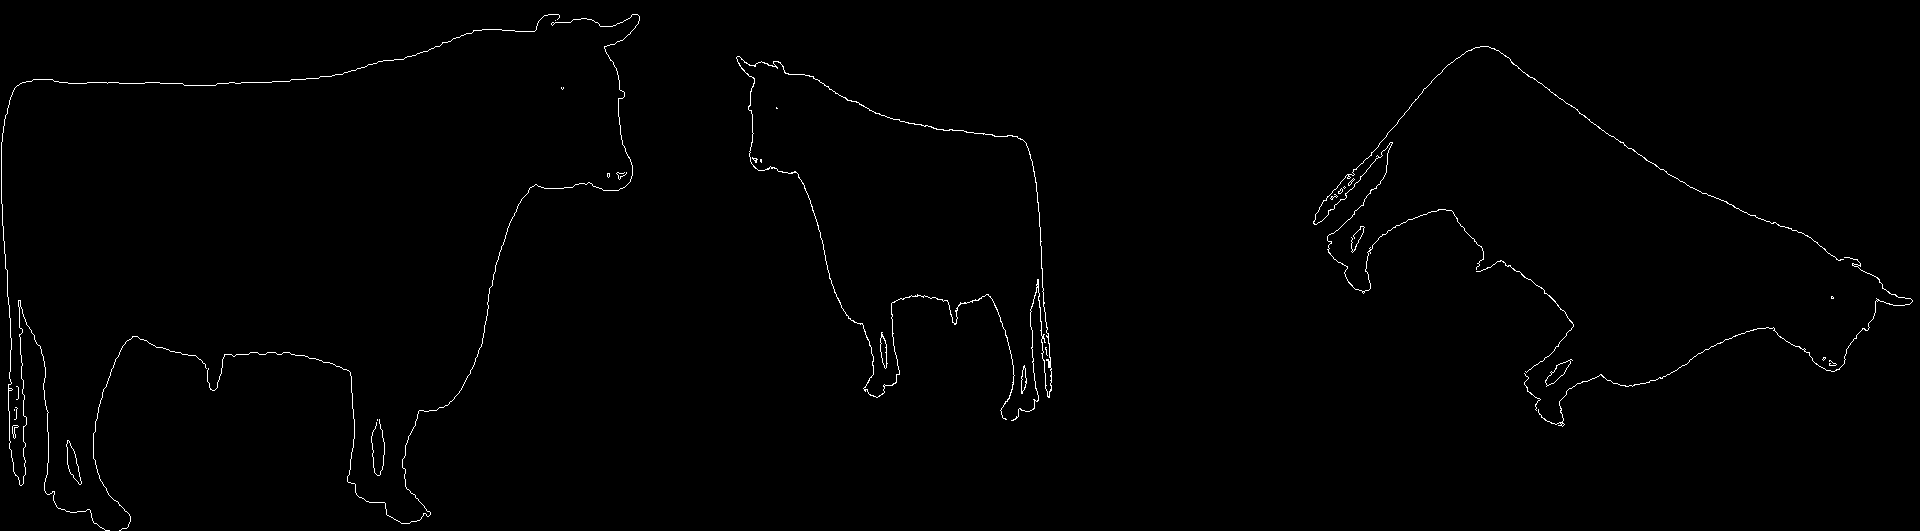

 48%|████▊     | 12/25 [03:39<06:50, 31.54s/it]

Time for image 11 78.68374800682068
259.26261132569294


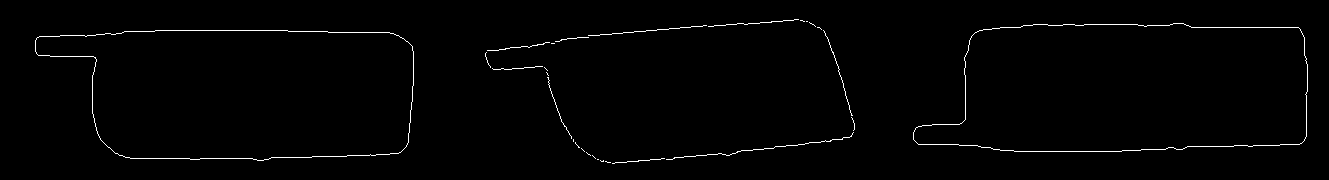

259.0020113921944


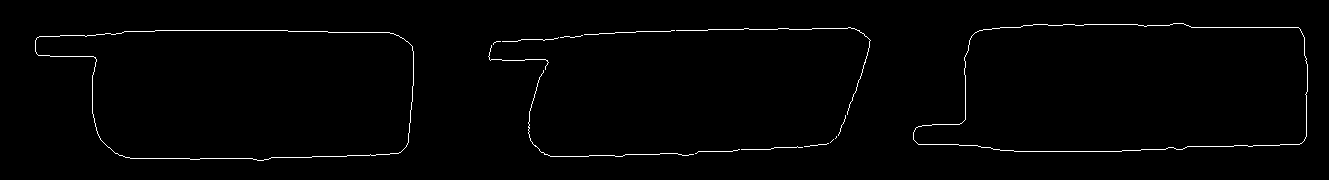

254.9788768495056


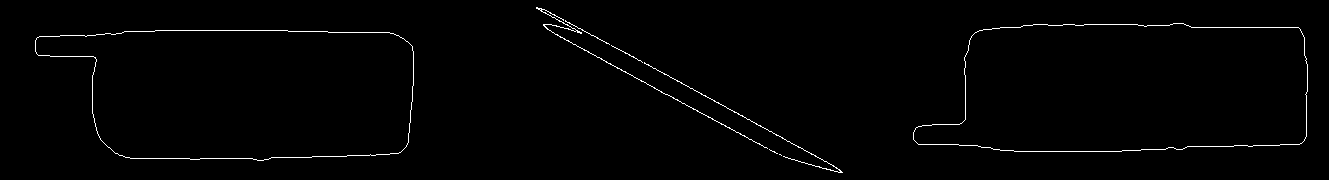

262.6570865894149


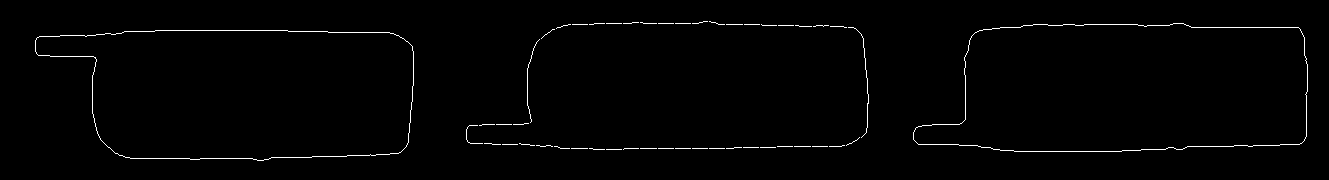

254.97662361012686


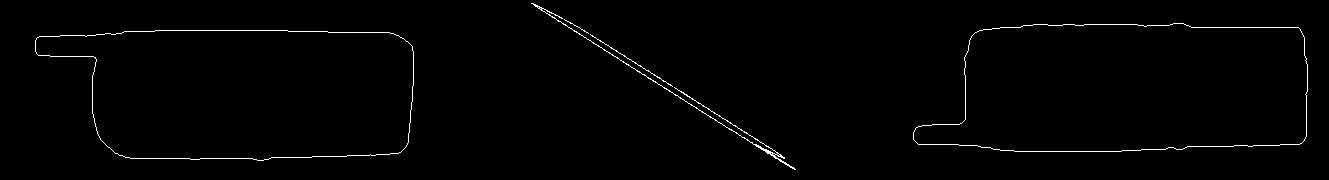

260.90864389180626


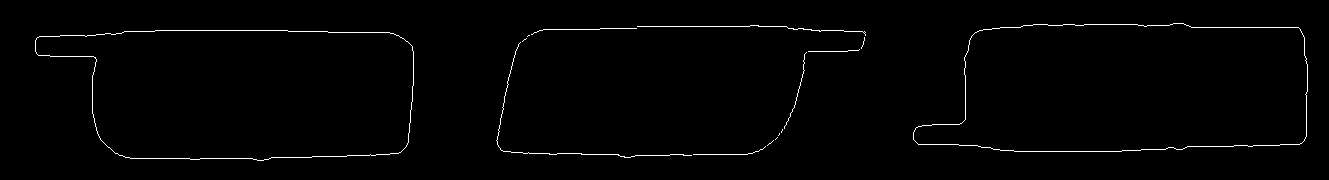

 52%|█████▏    | 13/25 [03:52<05:11, 25.99s/it]

Time for image 12 13.203478813171387
146.93648213101852


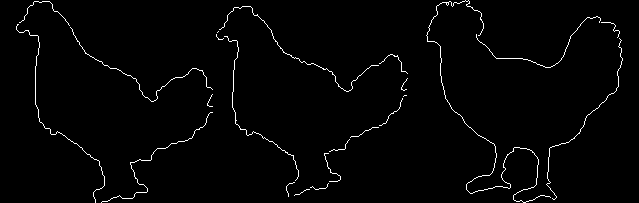

146.00872497839663


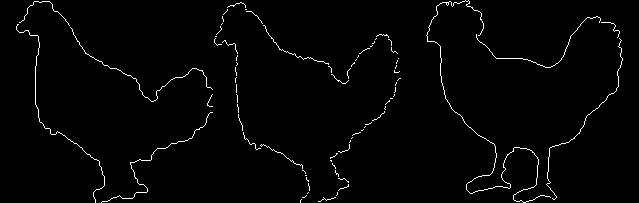

146.60282136932685


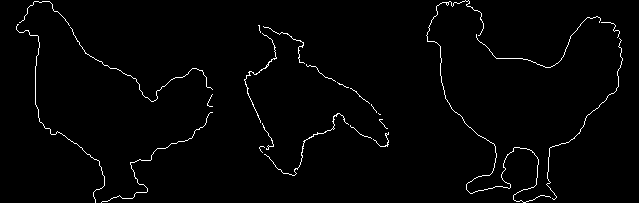

149.39464607961975


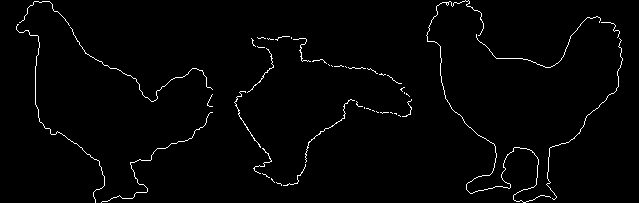

146.14883504482464


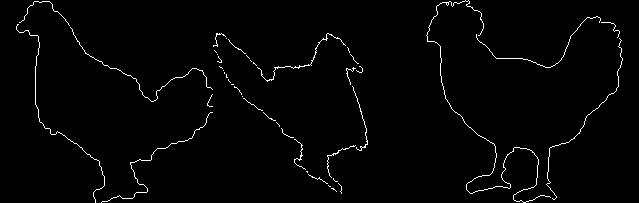

150.81737923036076


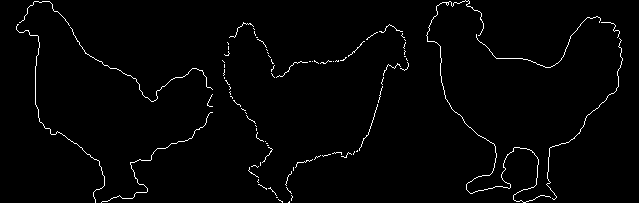

 56%|█████▌    | 14/25 [04:00<03:44, 20.43s/it]

Time for image 13 7.5595762729644775
155.6199878147043


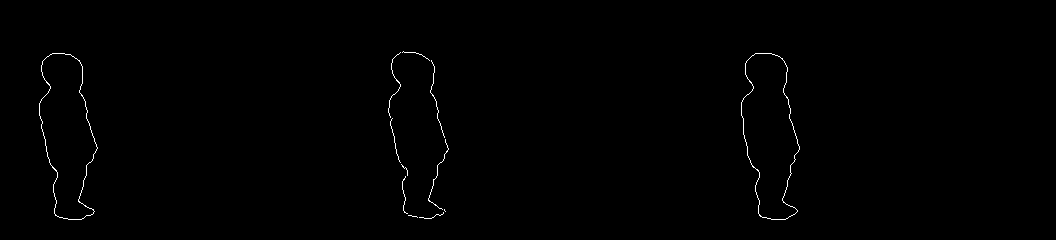

155.78388456003597


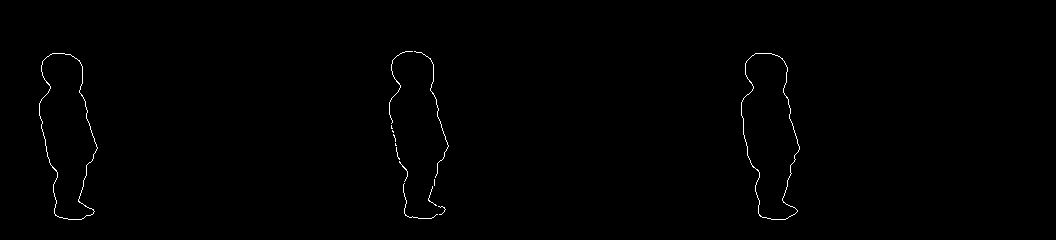

155.0654143984249


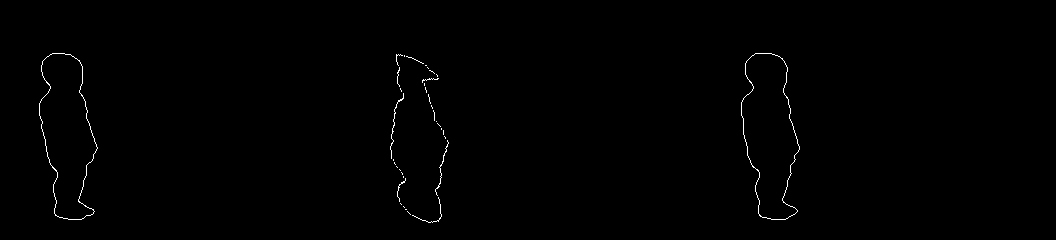

155.3471029864453


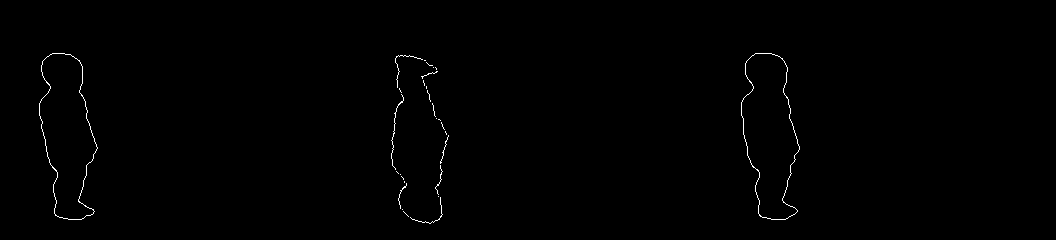

155.81404331485246


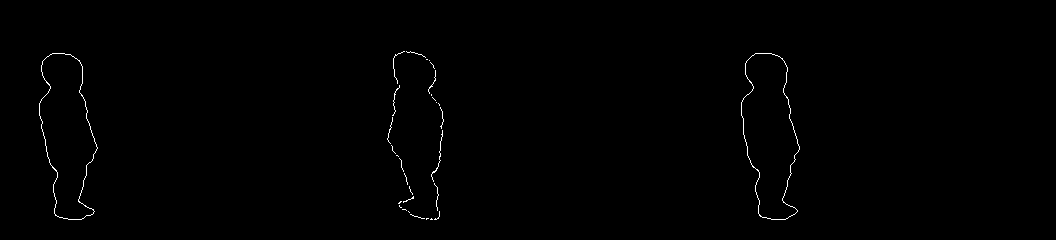

155.66769491116636


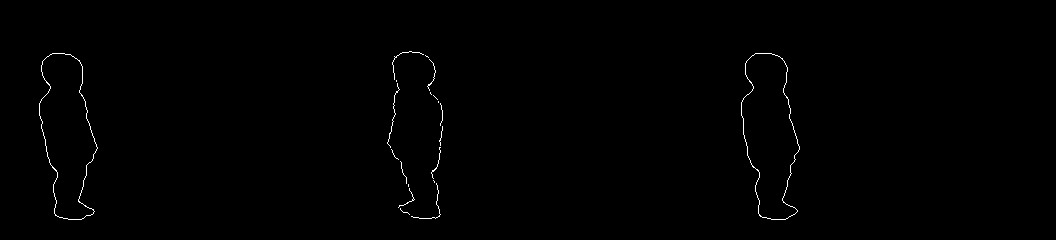

 60%|██████    | 15/25 [04:02<02:31, 15.15s/it]

Time for image 14 2.907538652420044
375.4850590947395


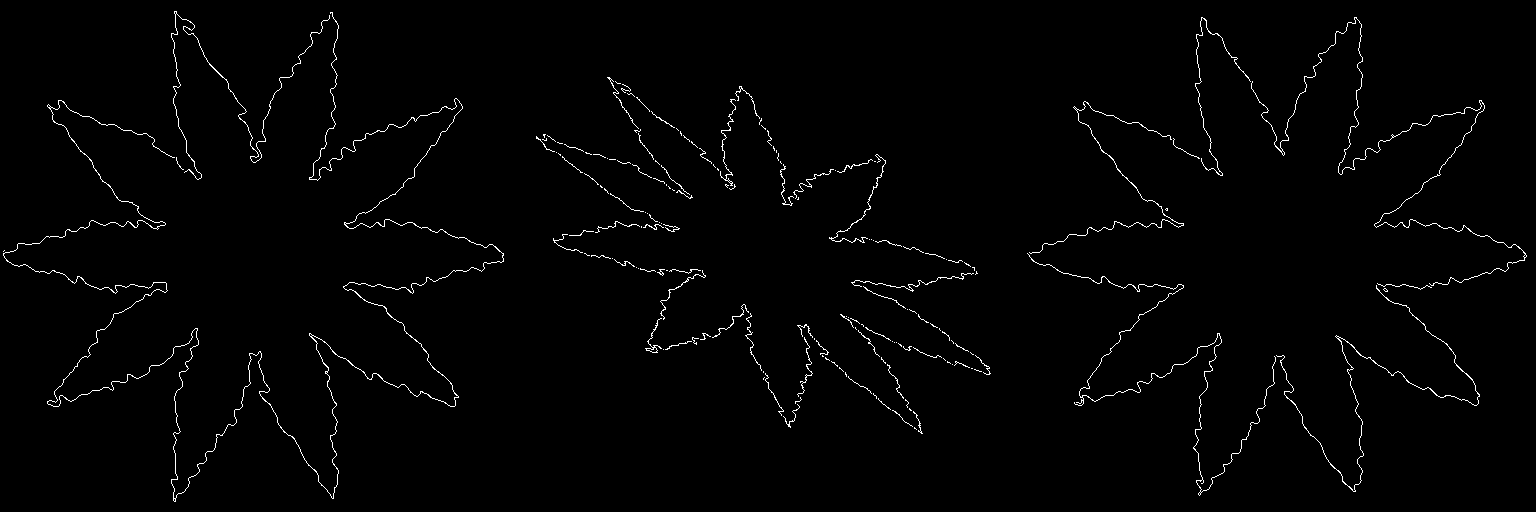

382.8540047944846


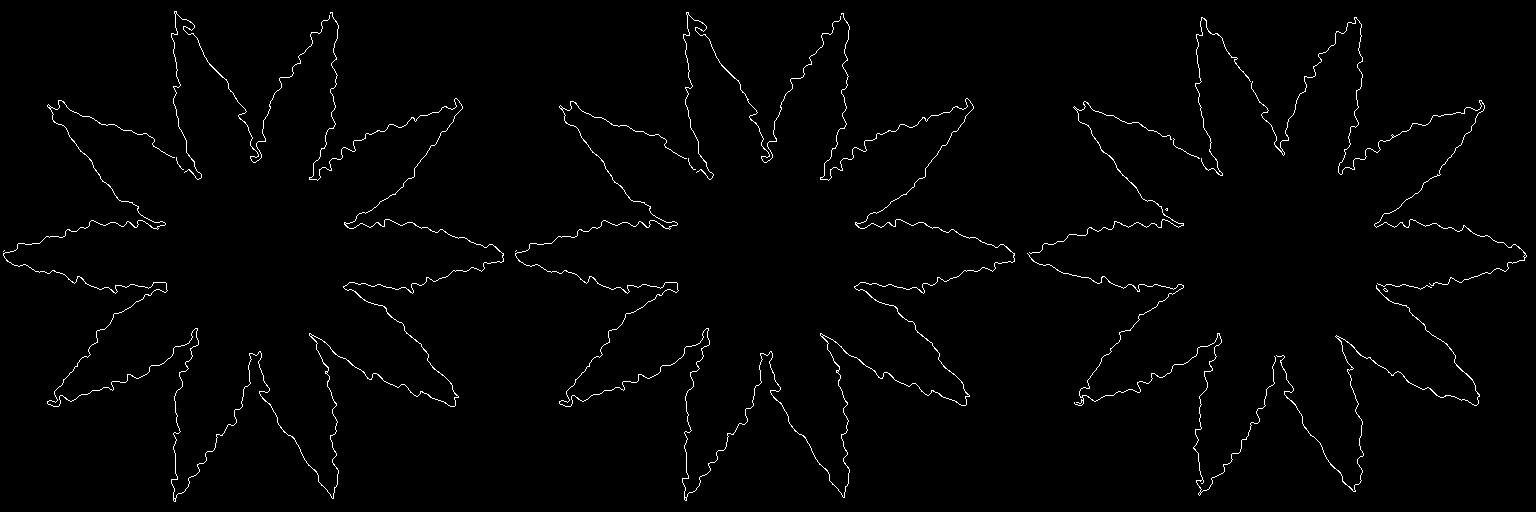

375.09335827193473


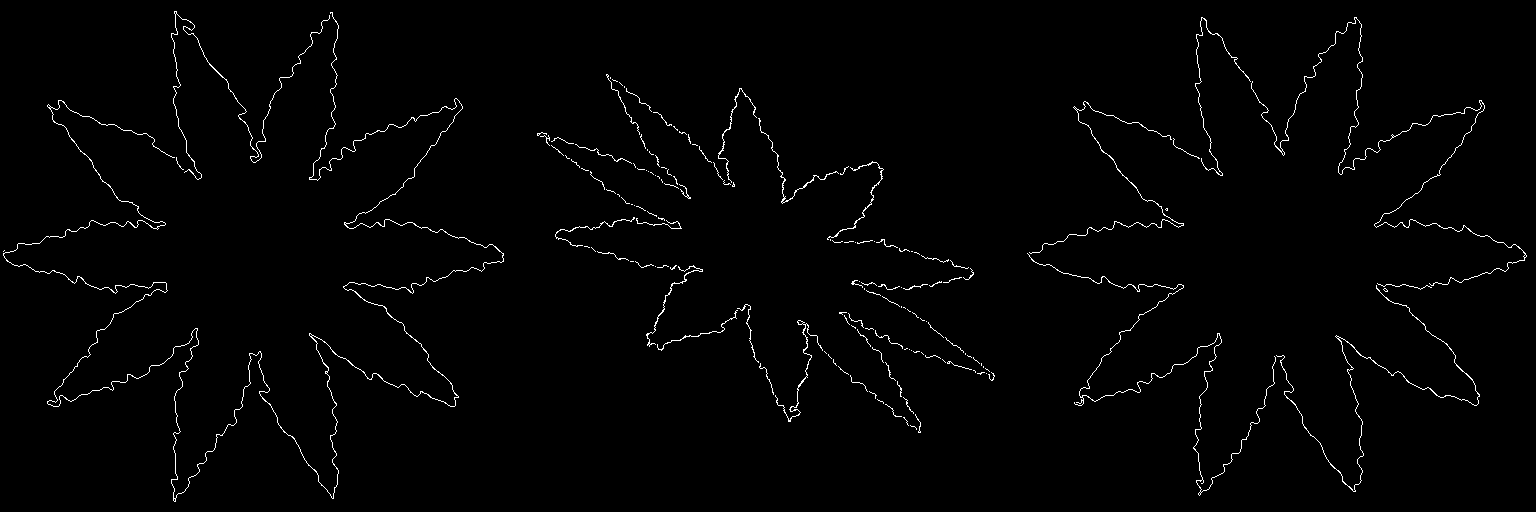

382.66834467040866


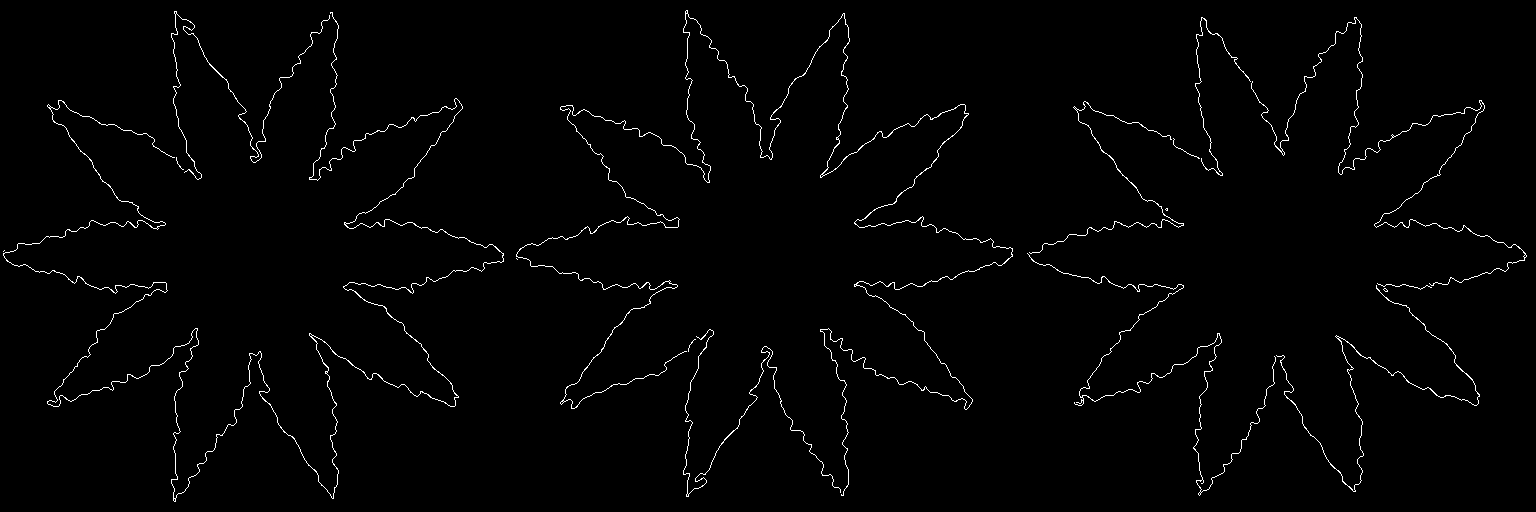

375.361158456577


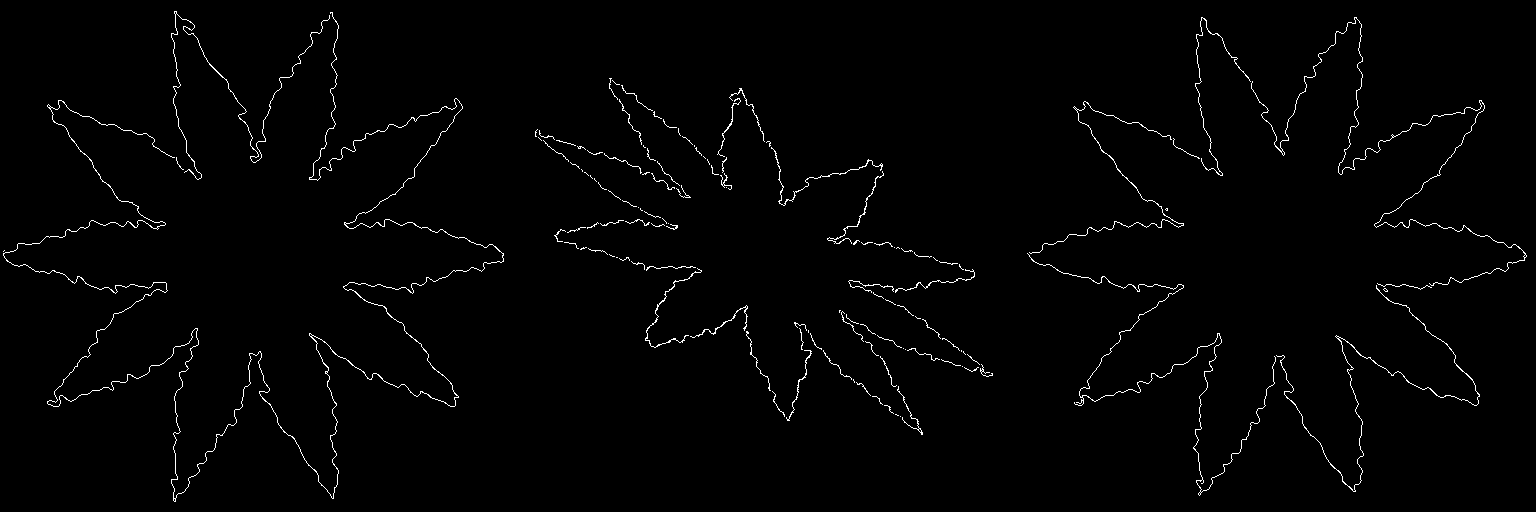

383.1034411472665


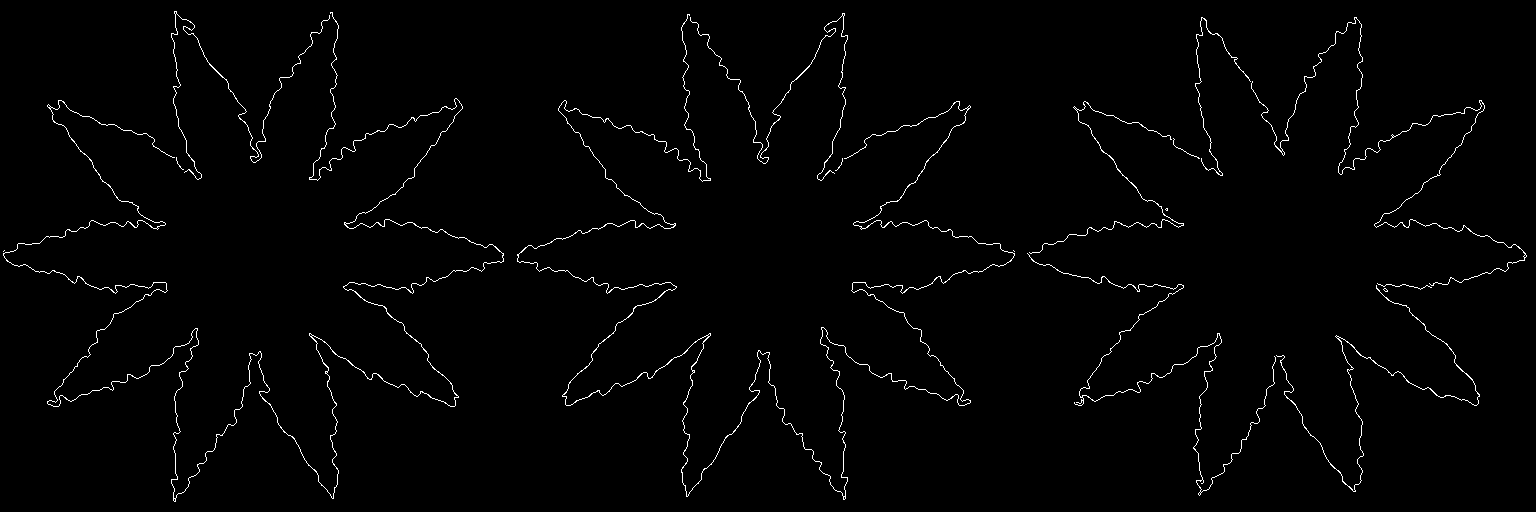

 64%|██████▍   | 16/25 [06:29<08:11, 54.57s/it]

Time for image 15 146.11135172843933
333.87902417171813


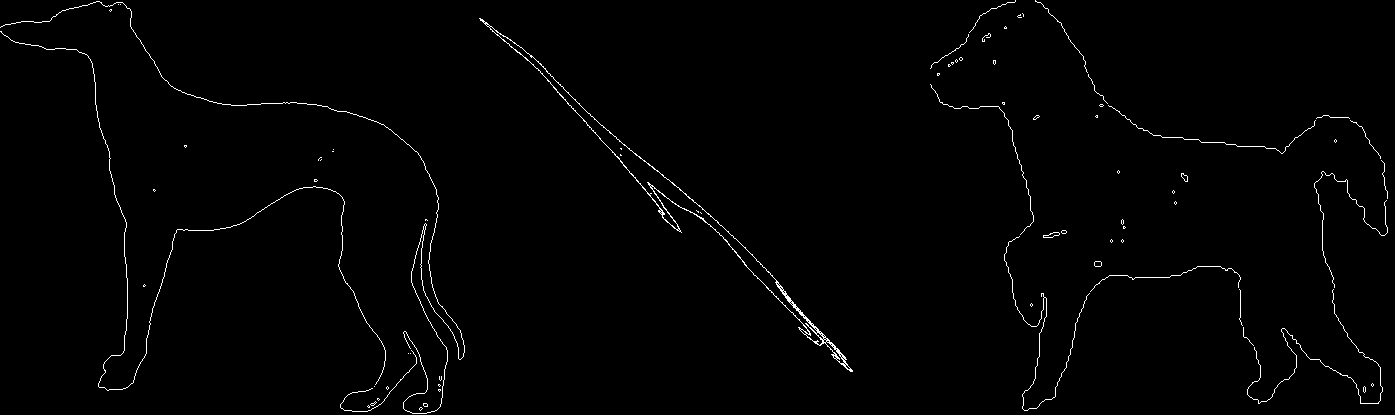

348.04220330080165


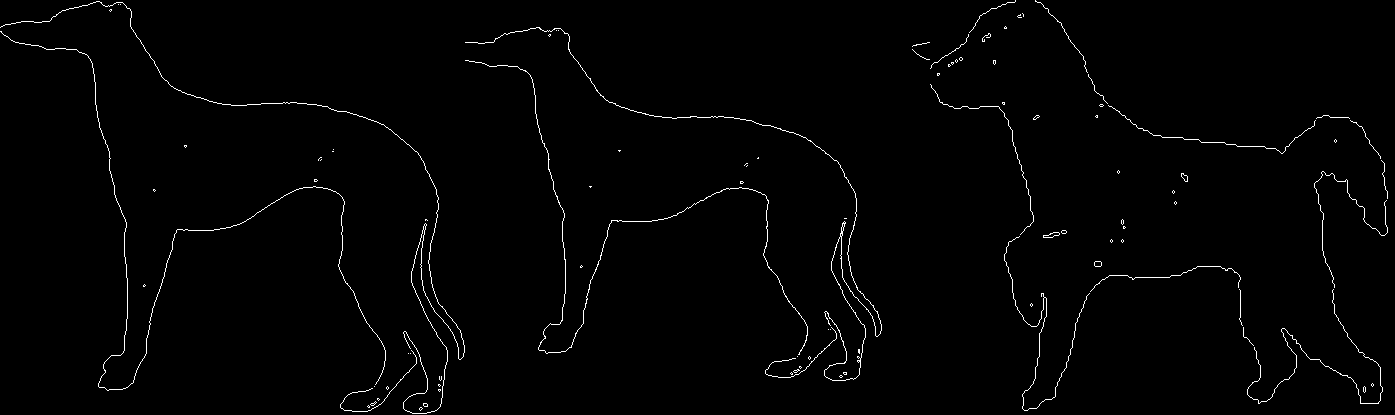

331.9641354084465


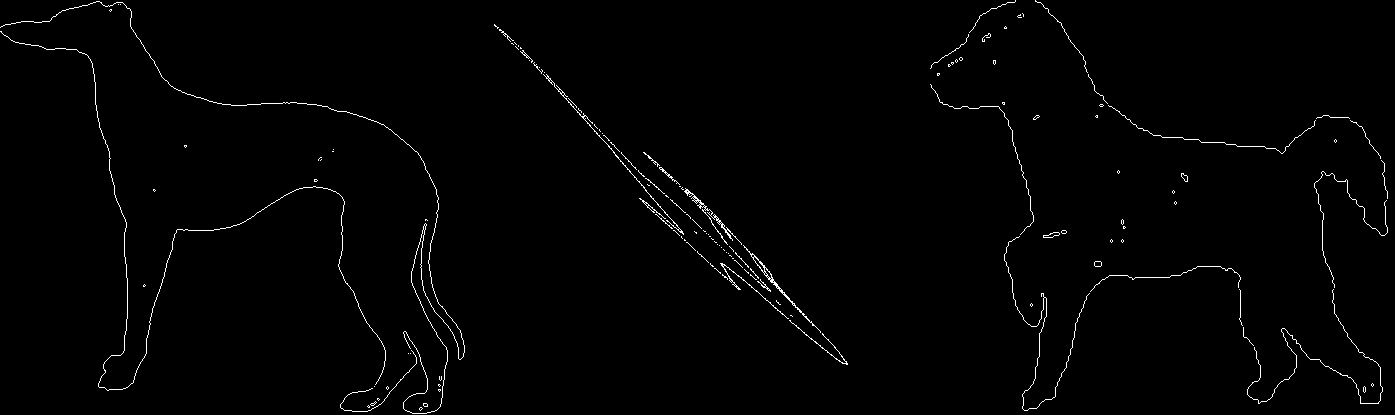

349.8999617624178


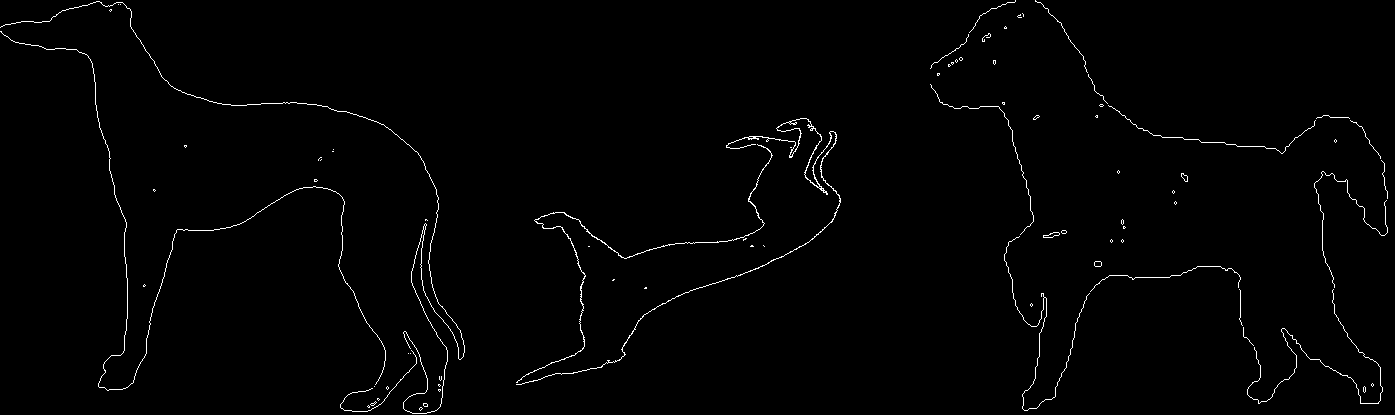

340.44331367142615


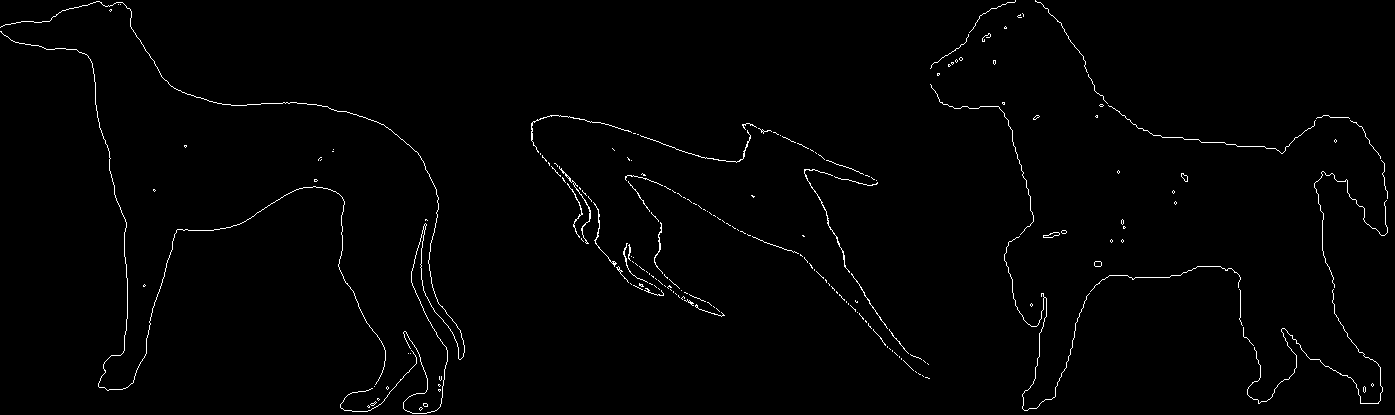

344.9187929373062


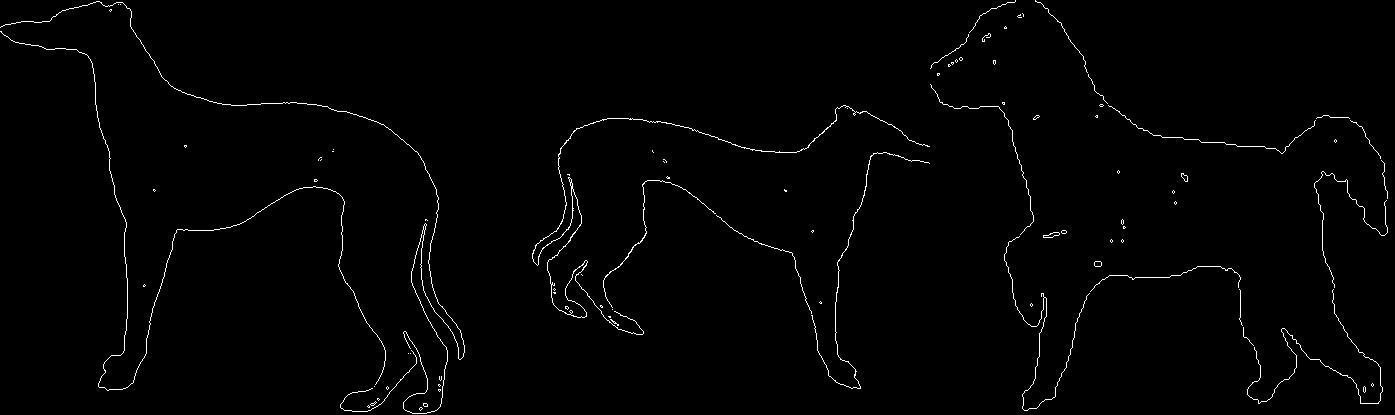

 68%|██████▊   | 17/25 [07:26<07:23, 55.48s/it]

Time for image 16 57.56915235519409
557.2935502424266


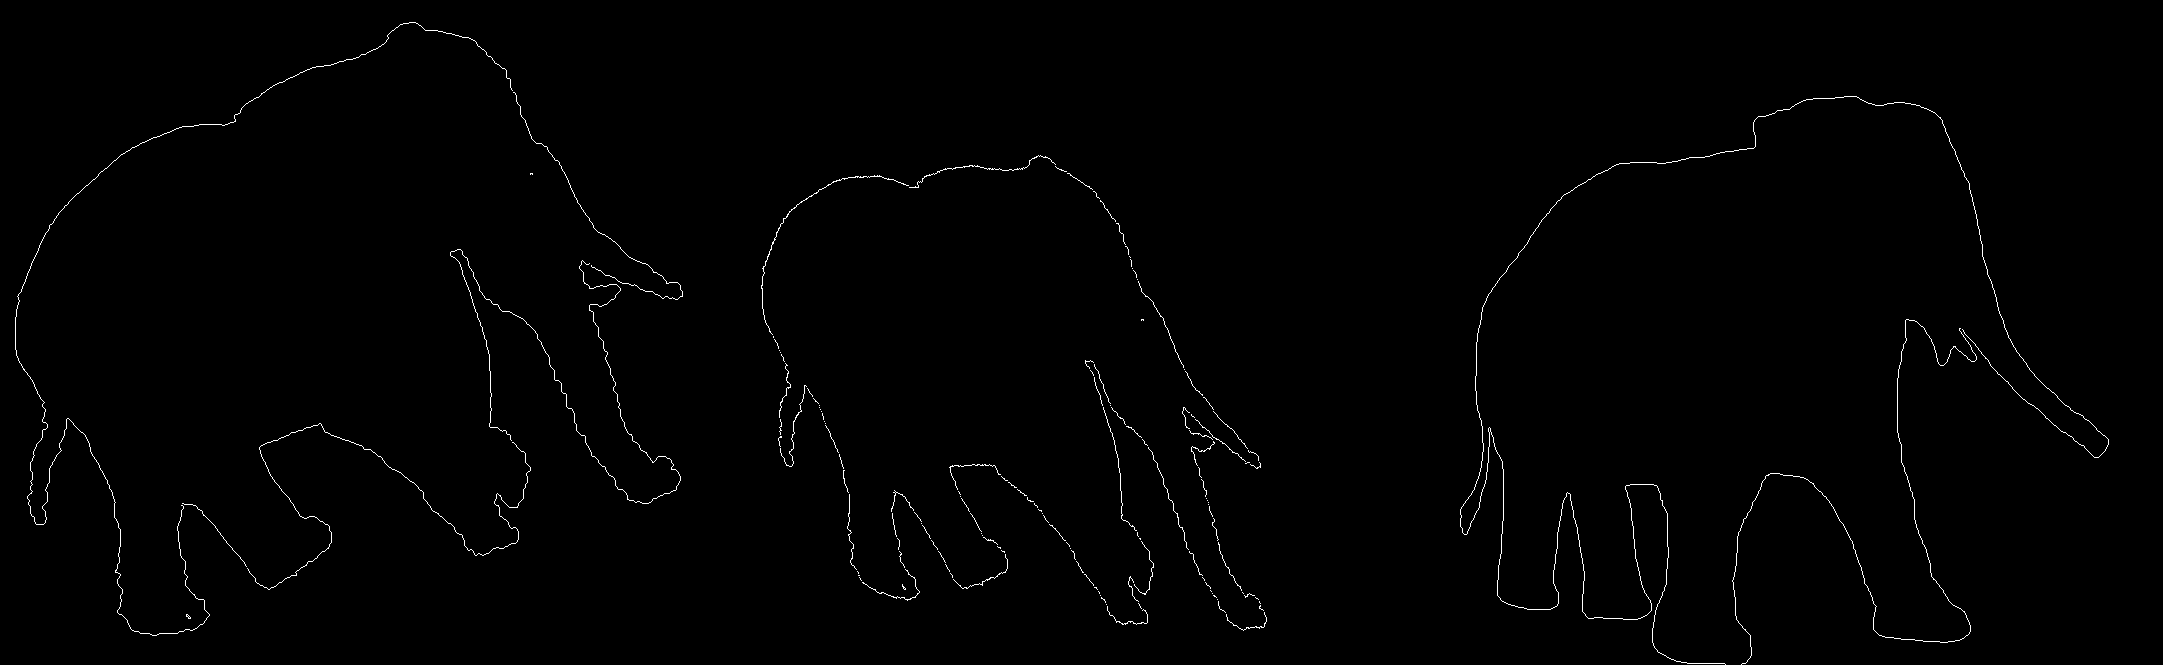

565.3689074628105


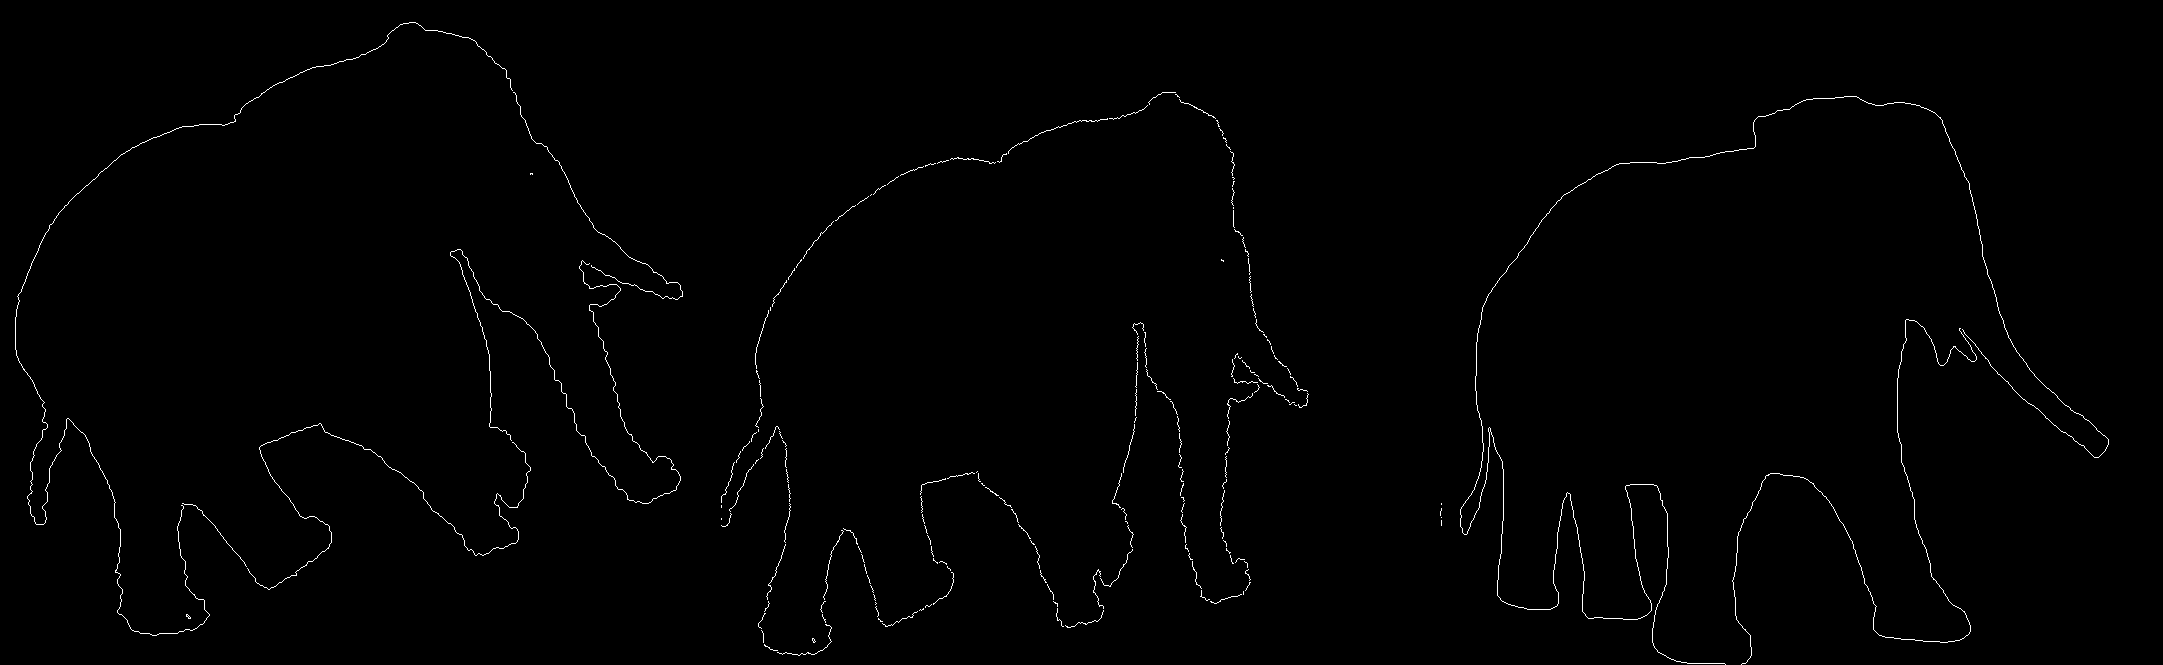

547.8564518436342


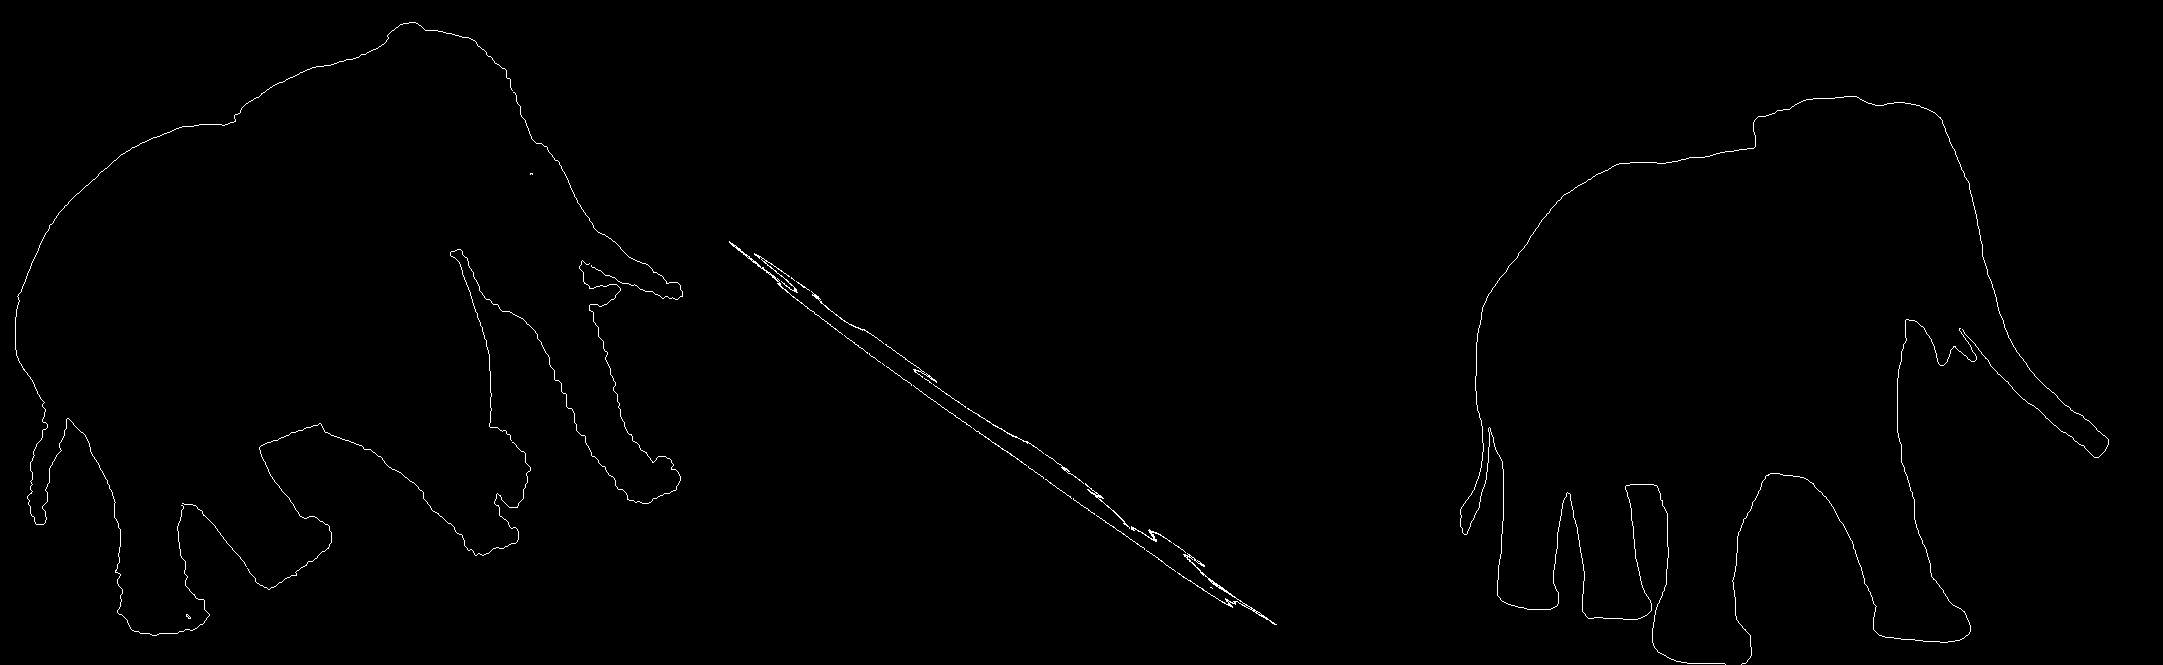

551.2901096128667


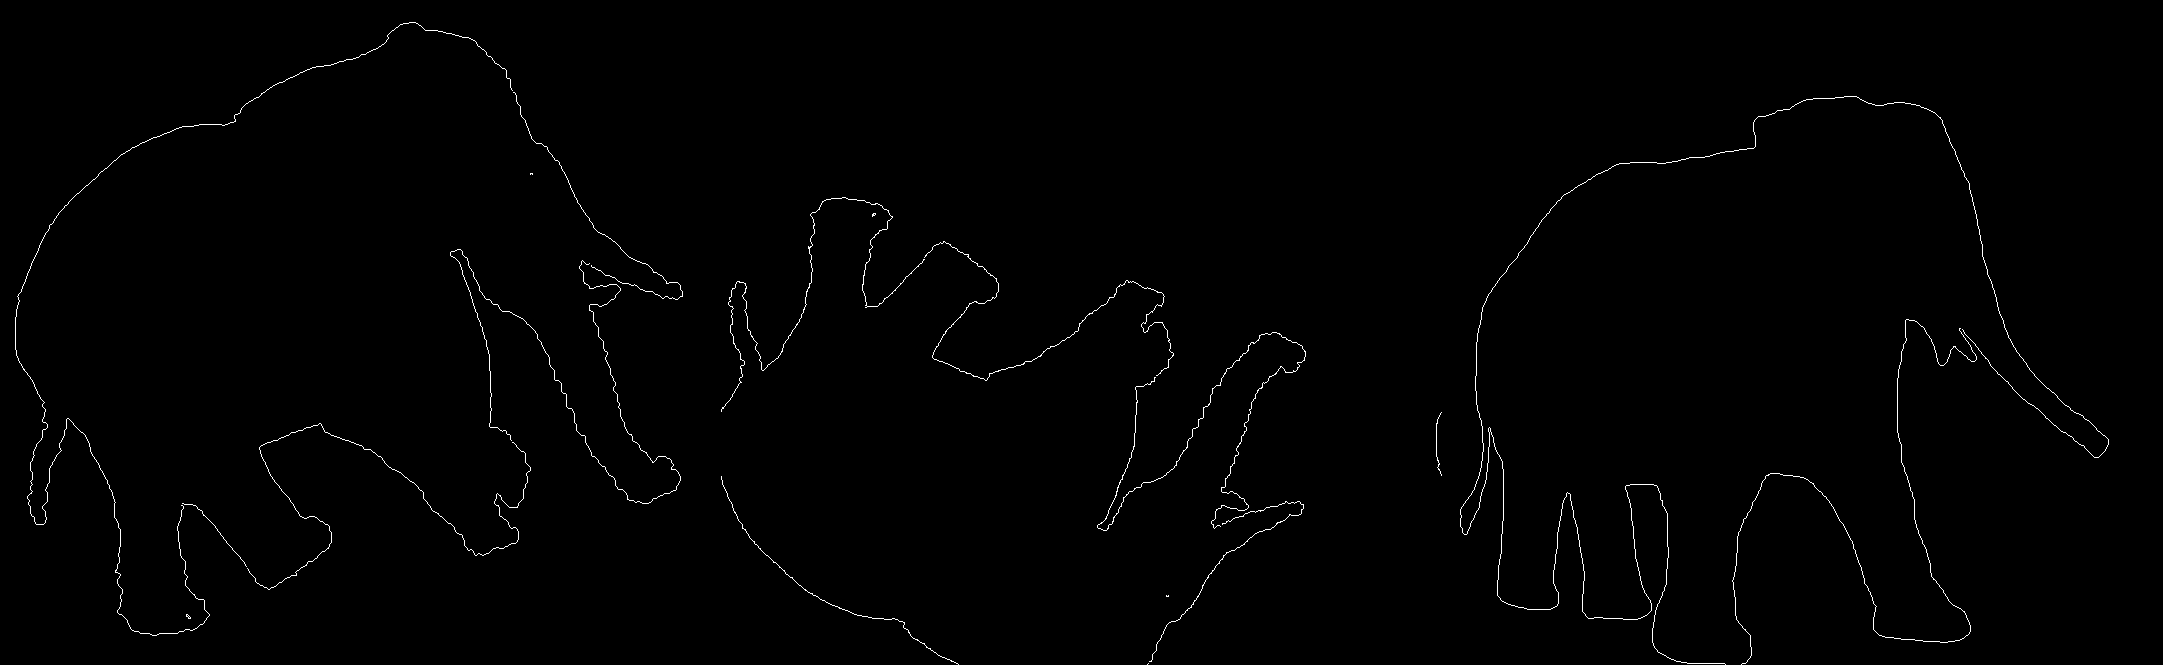

556.5787778227776


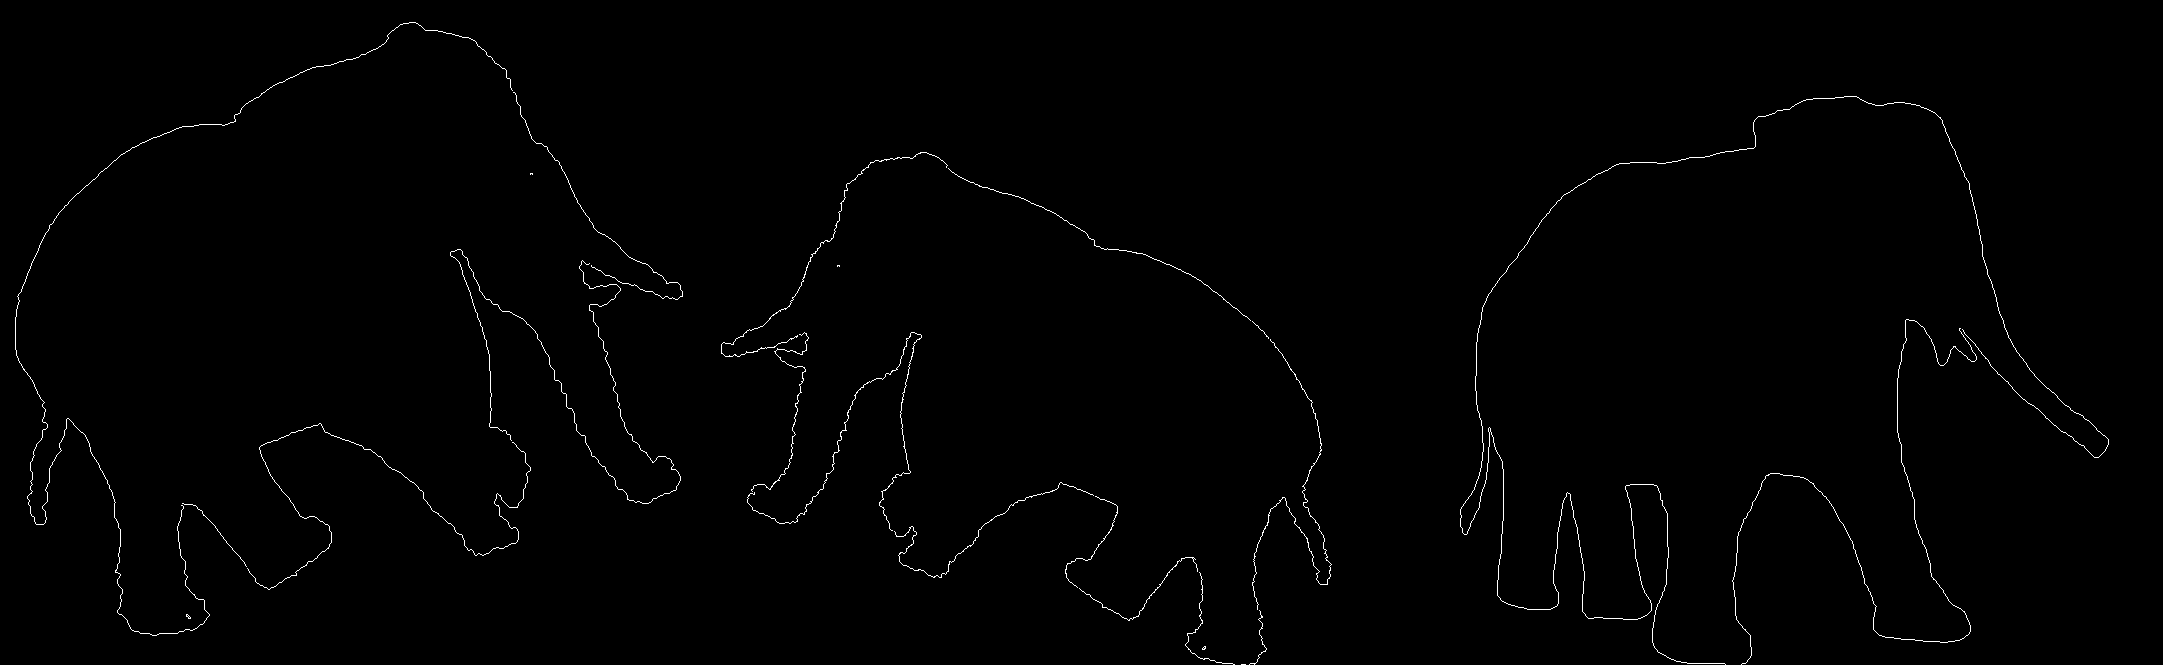

563.179121242913


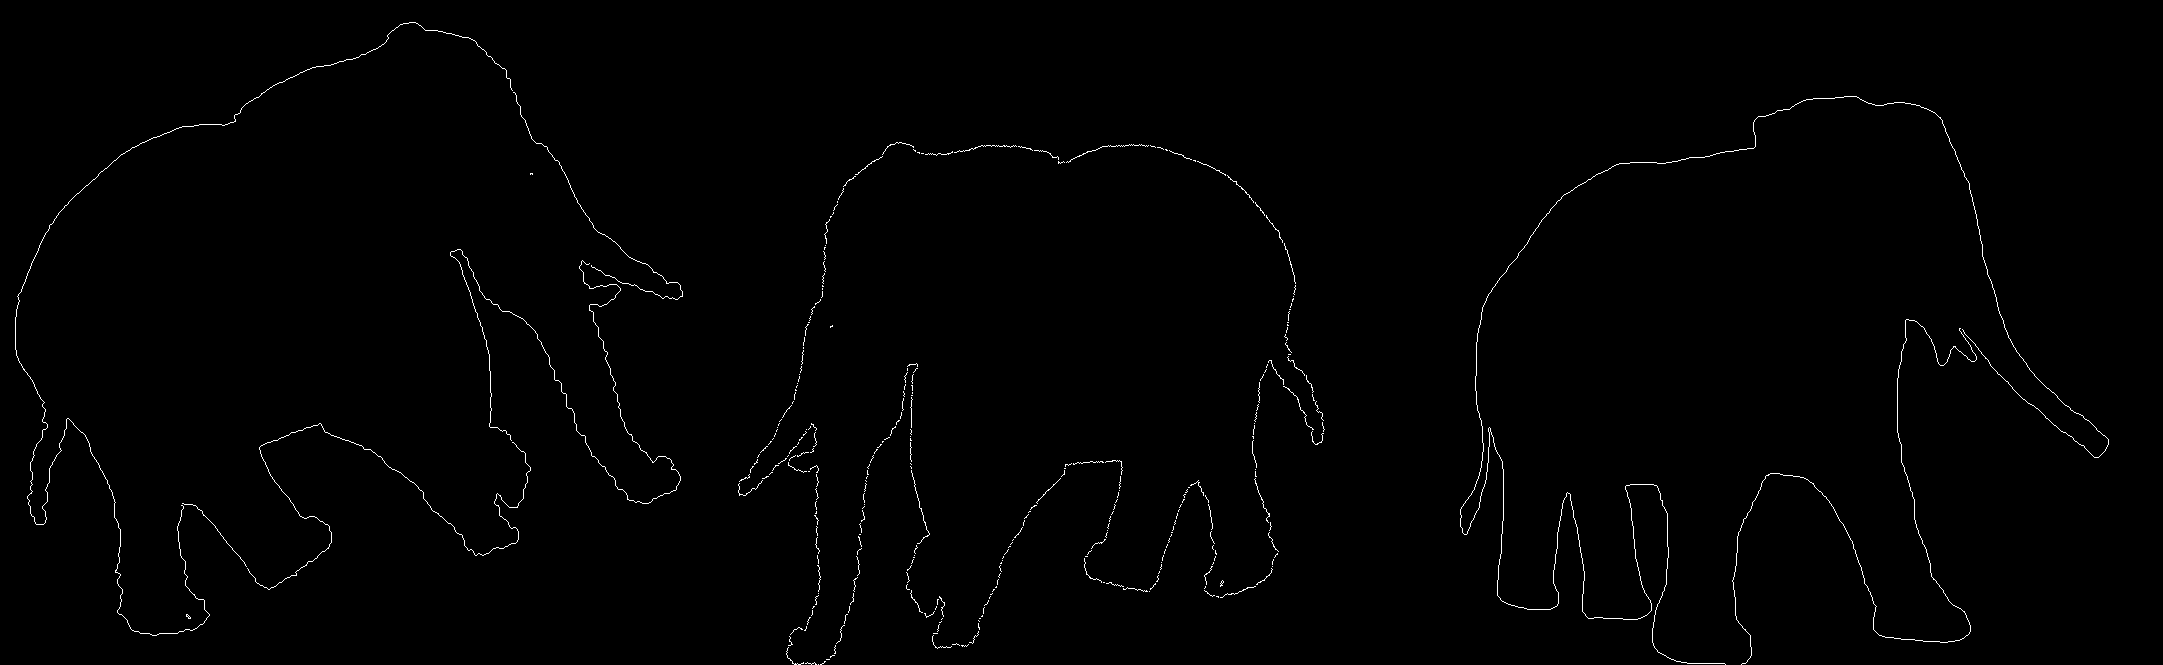

 72%|███████▏  | 18/25 [09:16<08:22, 71.82s/it]

Time for image 17 109.84483647346497
232.20273983629392


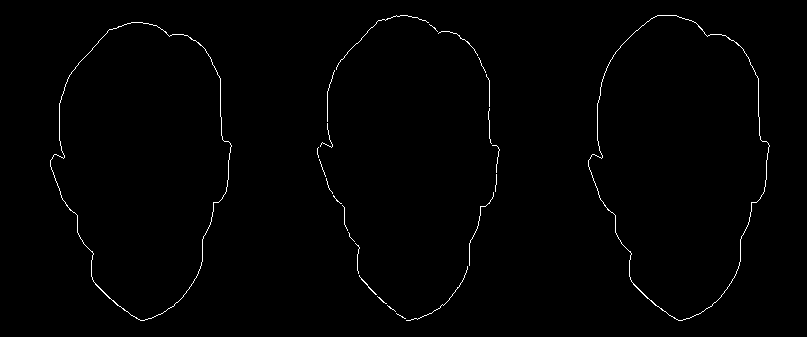

232.37727474386847


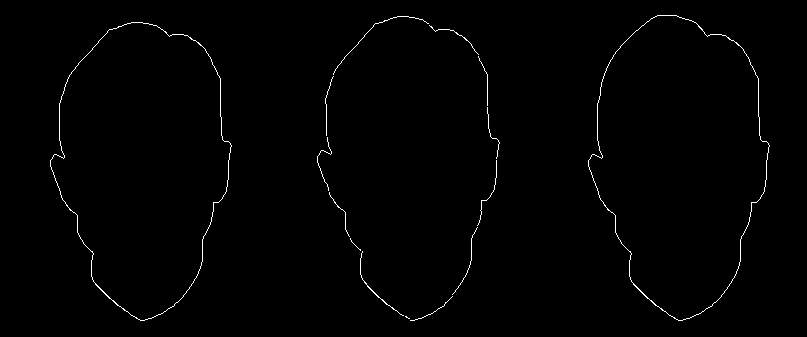

230.81793492011911


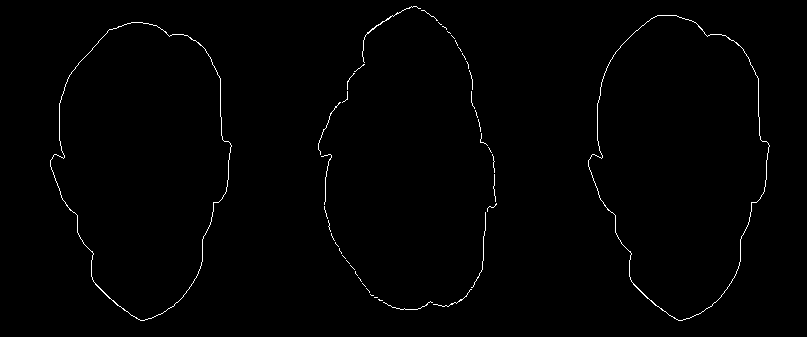

231.14061275165594


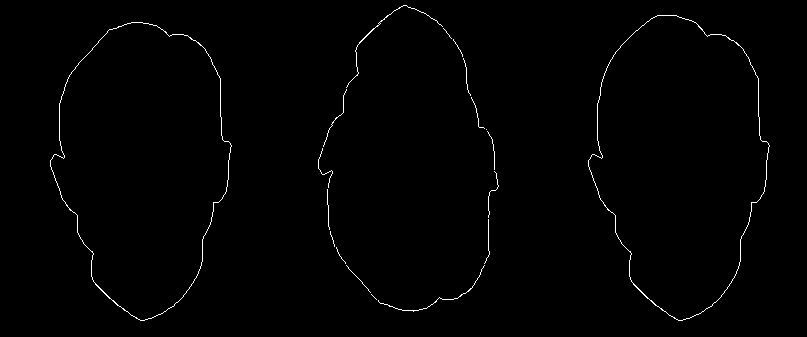

231.8852734403802


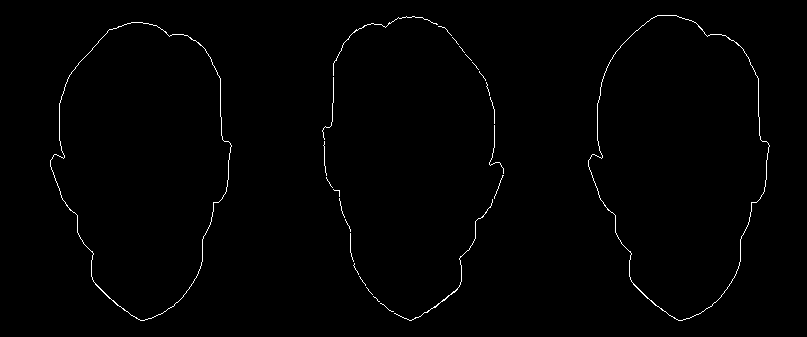

232.0532476862429


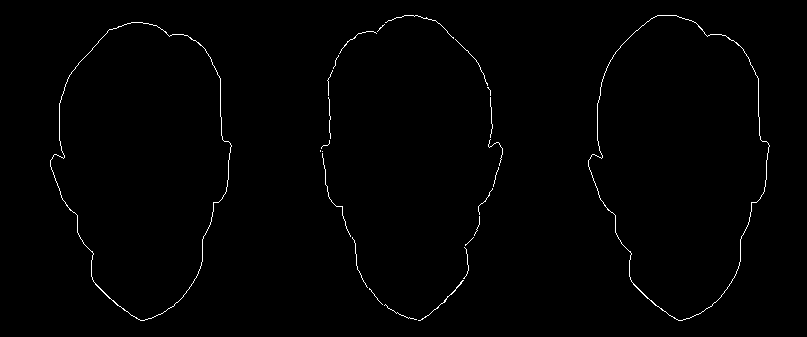

 76%|███████▌  | 19/25 [09:23<05:14, 52.37s/it]

Time for image 18 7.072615146636963
366.3336140329659


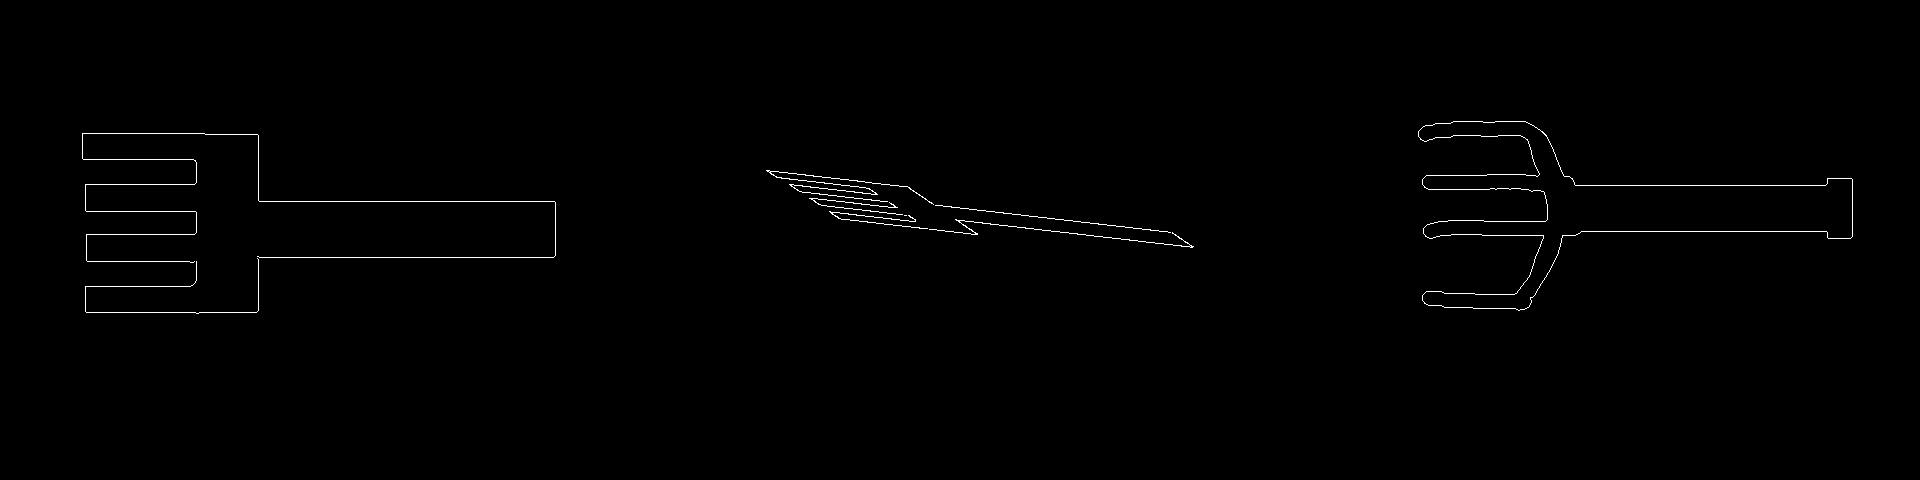

367.50637609847377


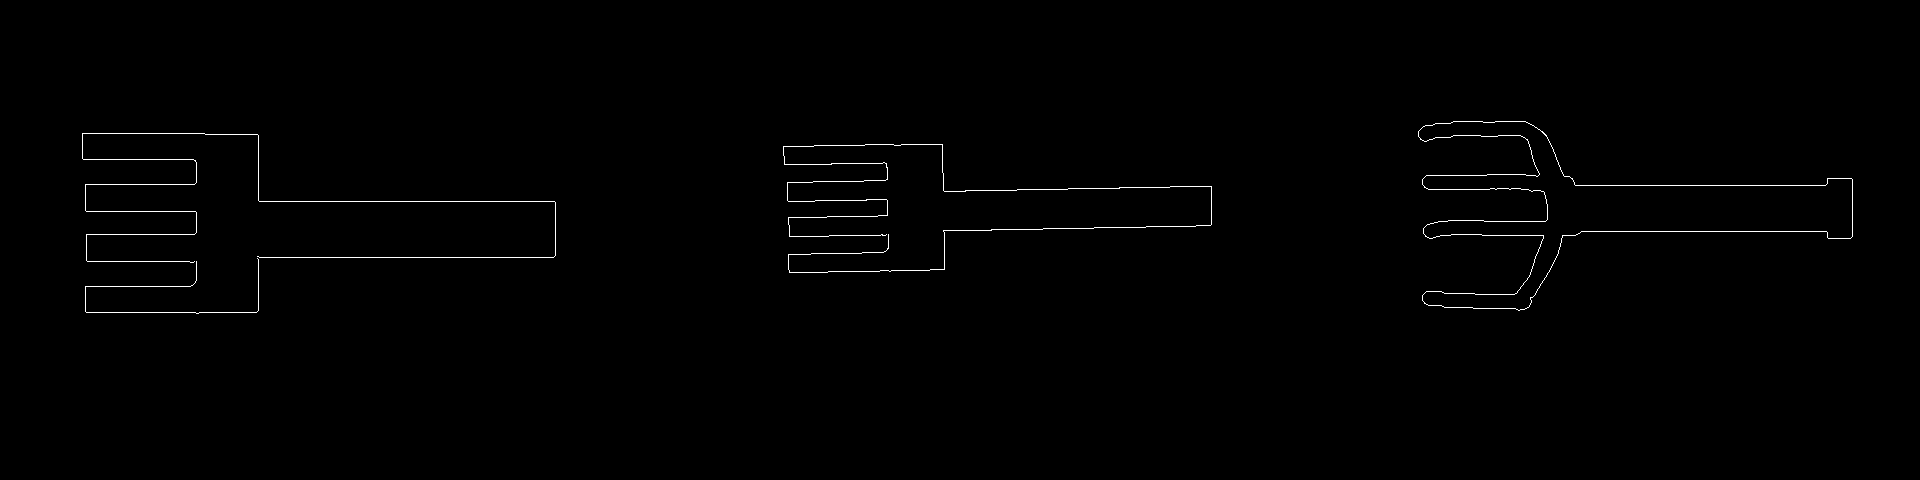

366.7834243596136


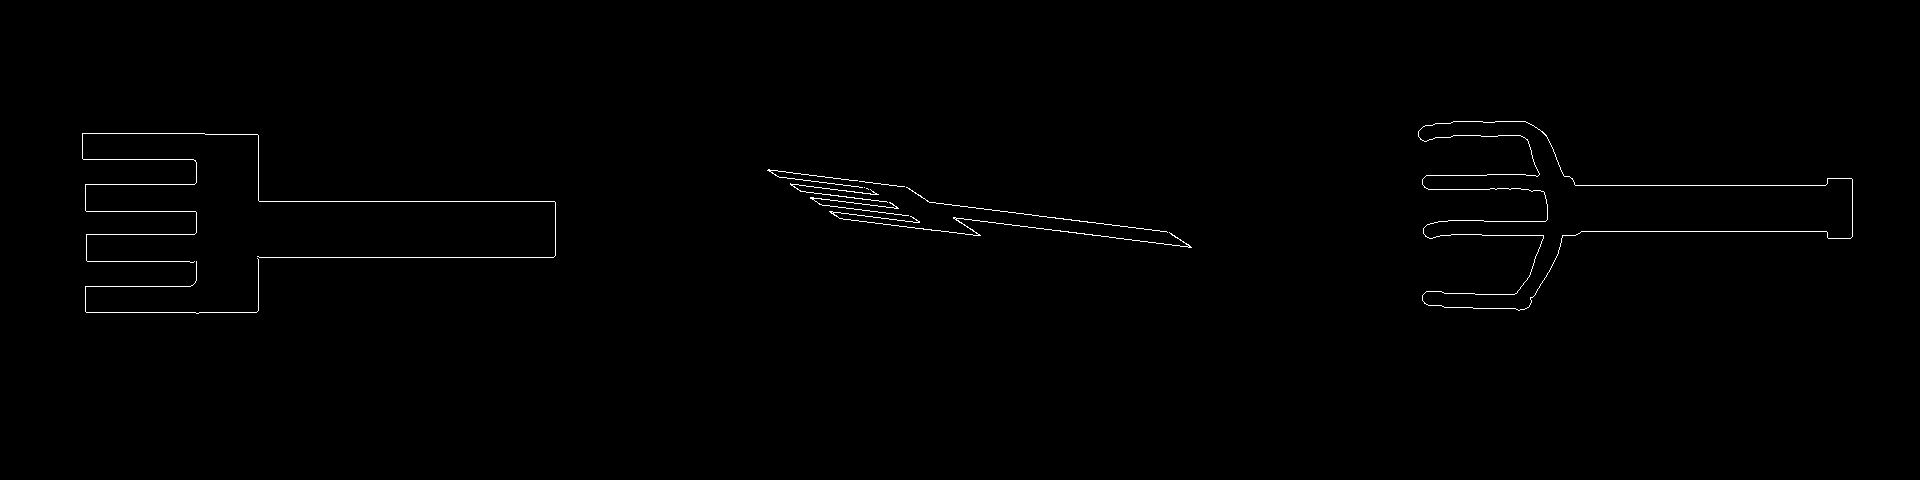

367.7117813861387


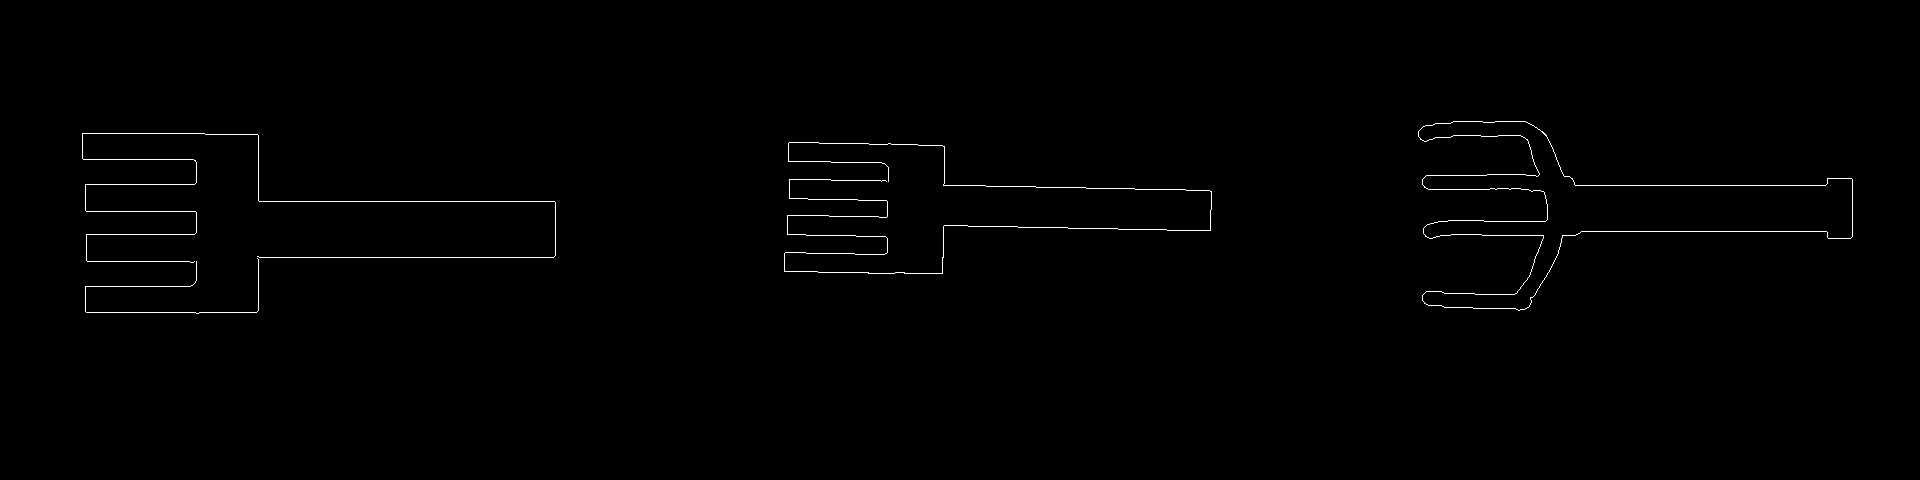

364.6806281614214


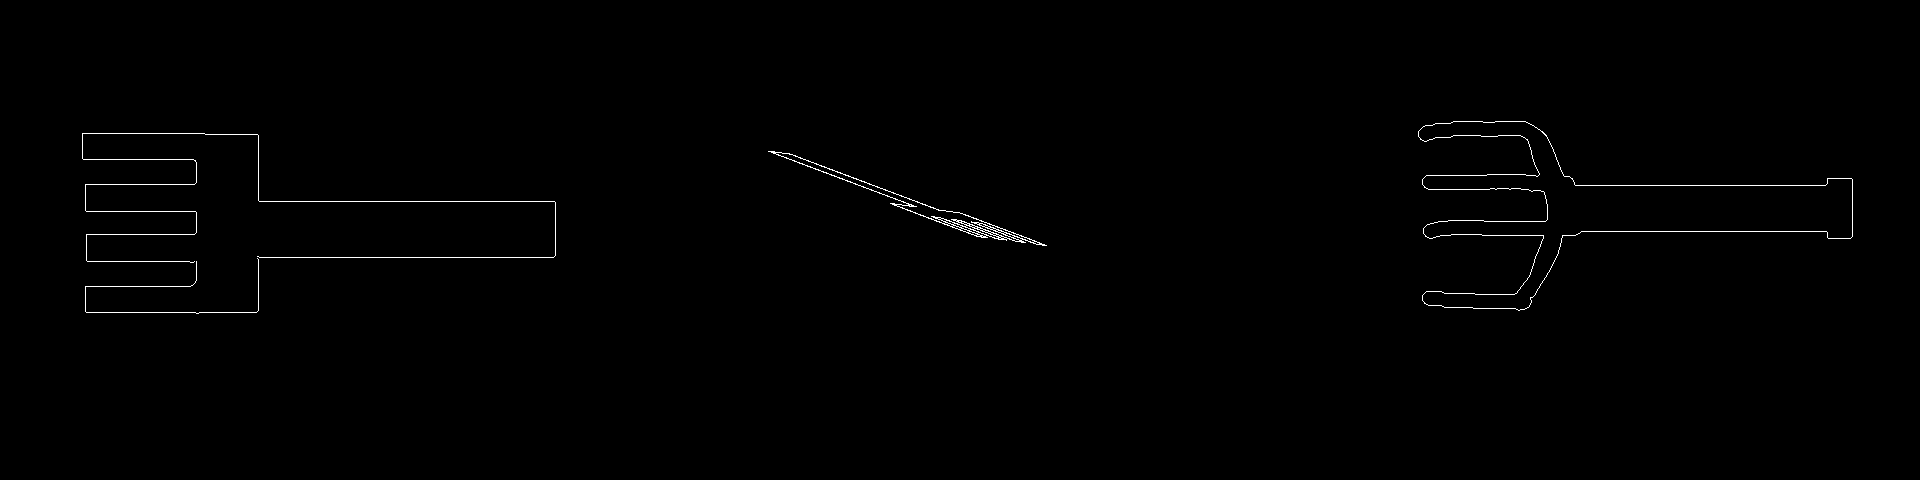

366.5835982624983


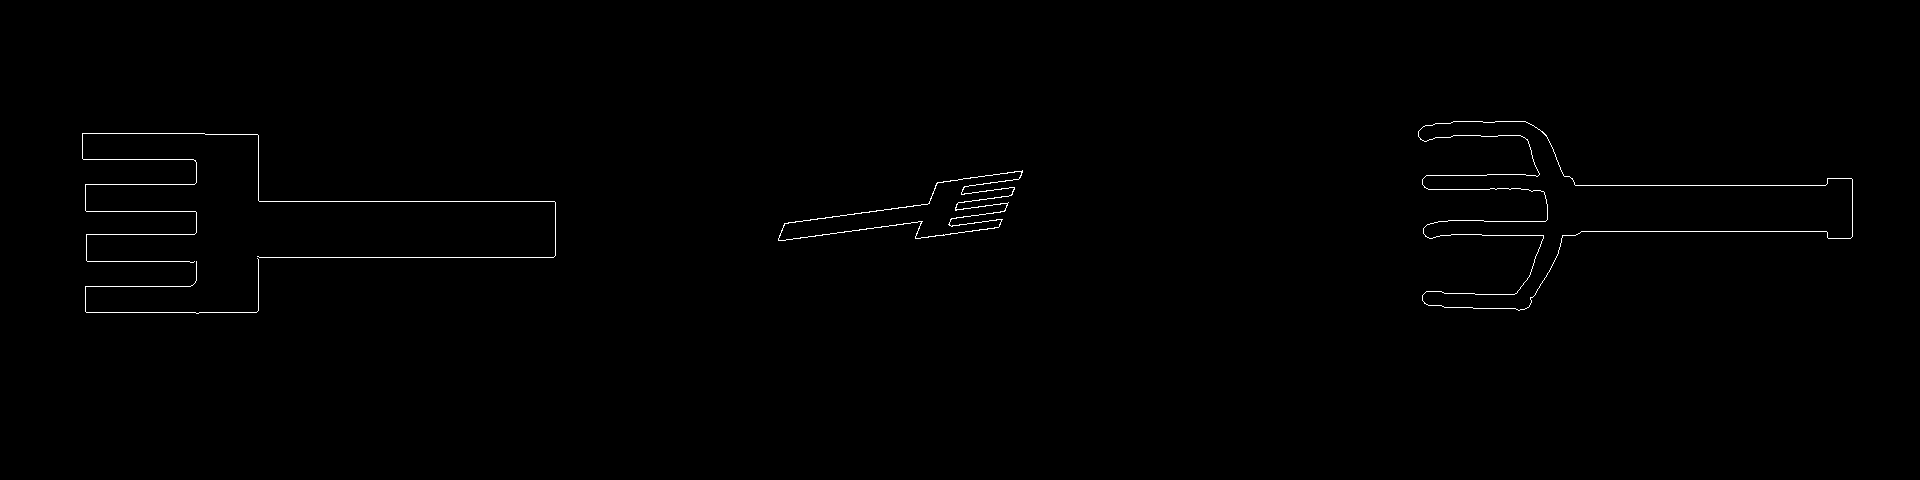

 80%|████████  | 20/25 [10:00<03:58, 47.66s/it]

Time for image 19 36.6694061756134
160.335552319079


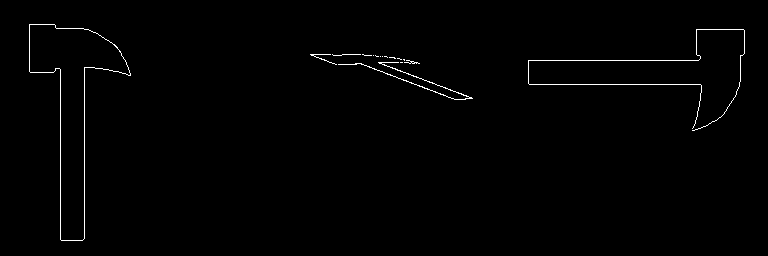

160.14851258198112


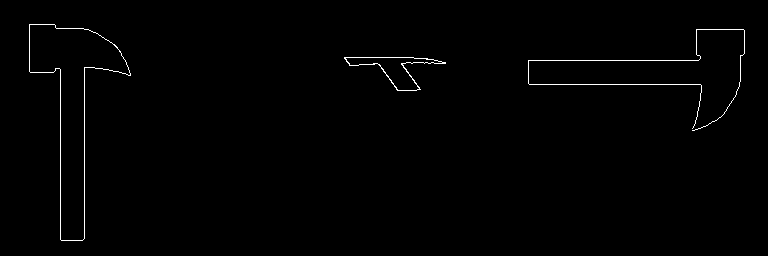

161.29938297538703


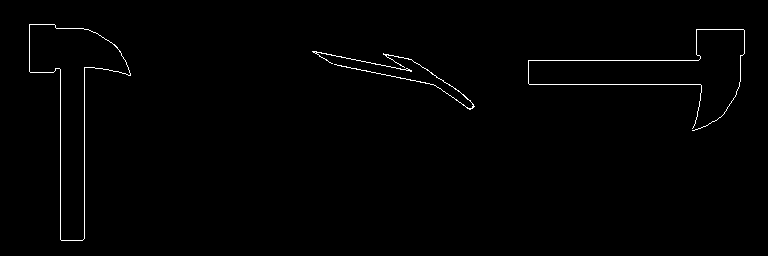

161.68090981157562


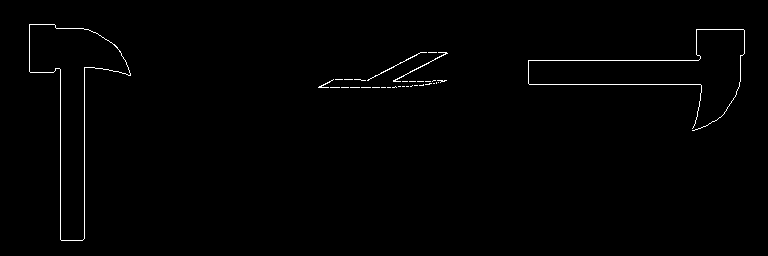

161.72456509245836


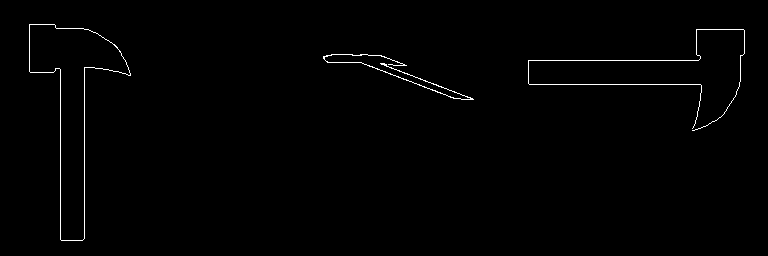

157.23859337341145


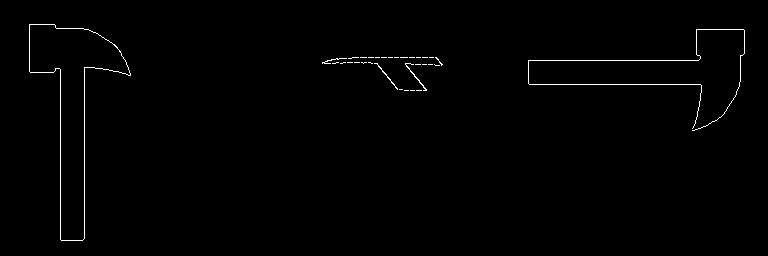

 84%|████████▍ | 21/25 [10:05<02:19, 34.91s/it]

Time for image 20 5.17633843421936
313.5221610239578


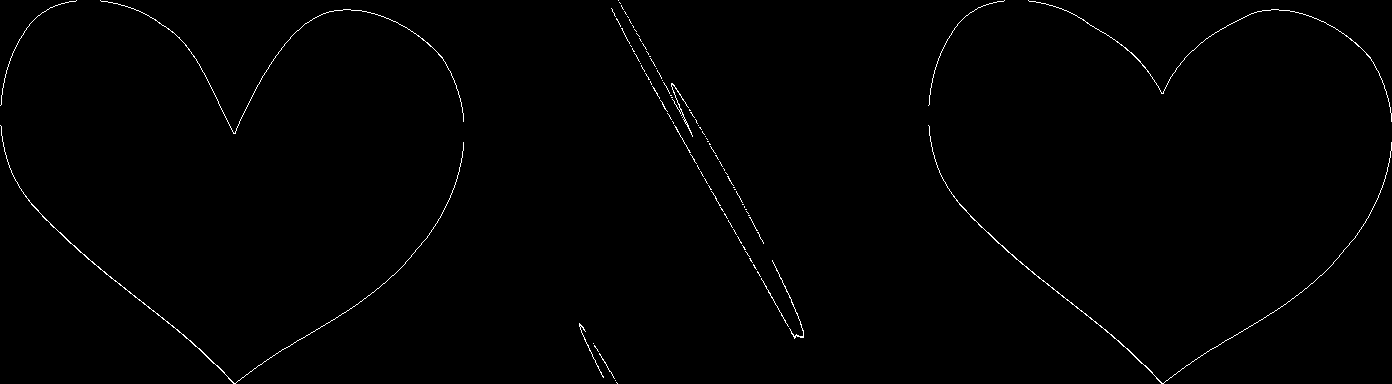

315.4258360788842


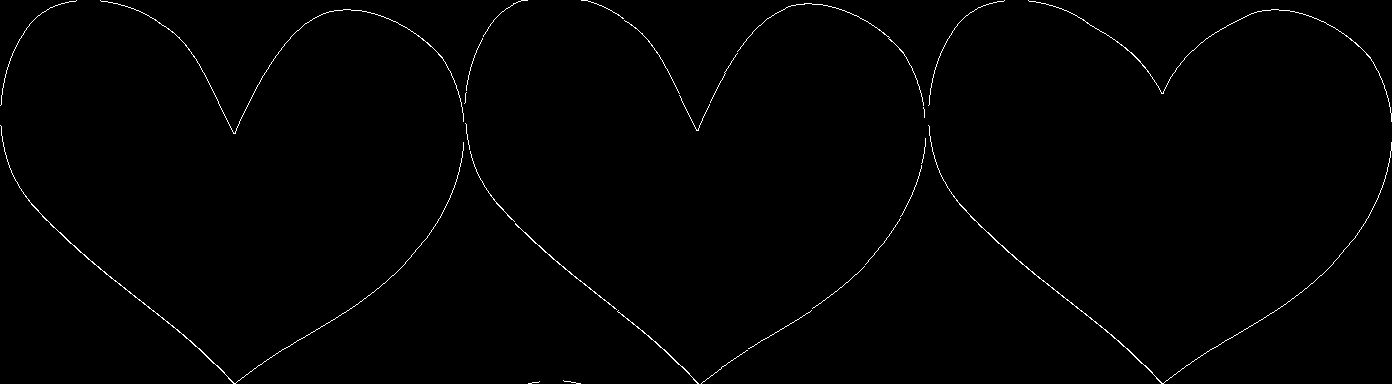

316.37273384558335


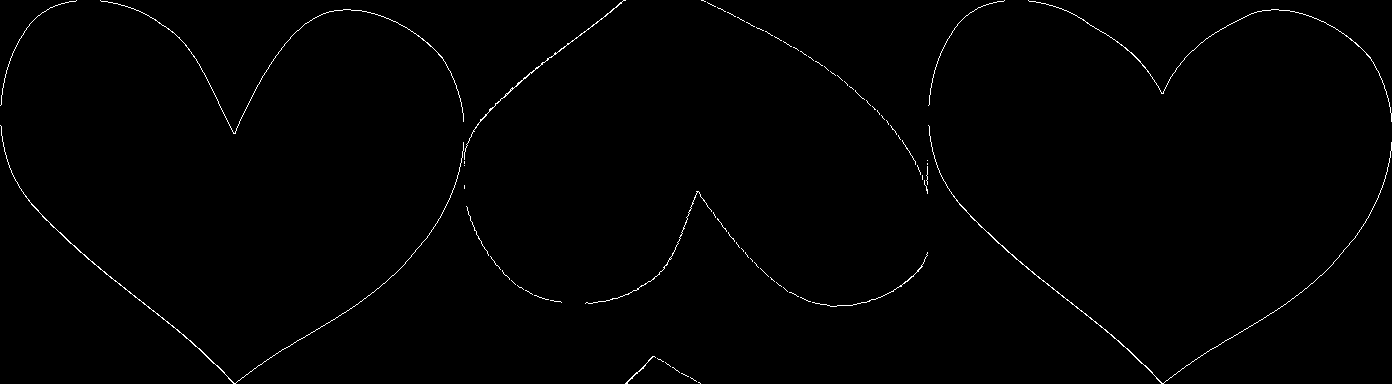

328.66586456578466


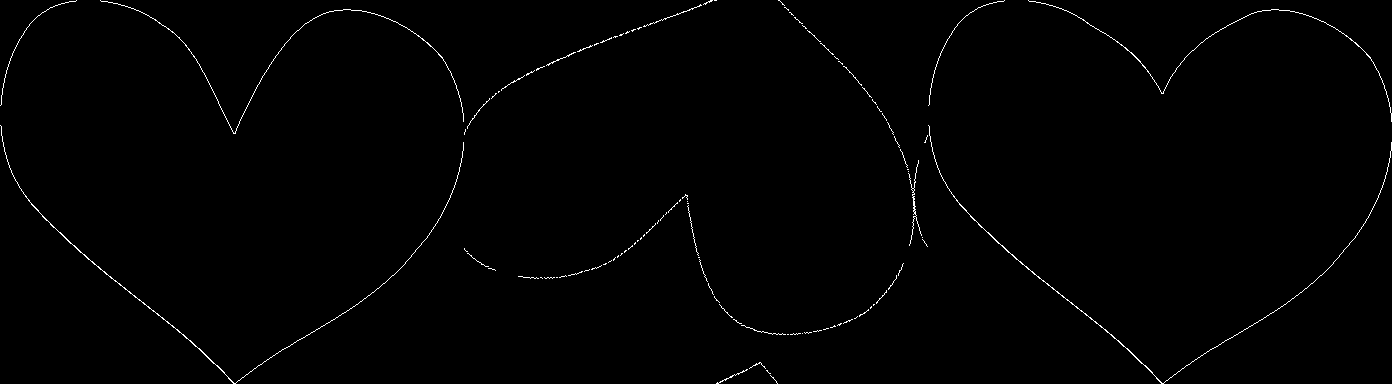

326.6068478339182


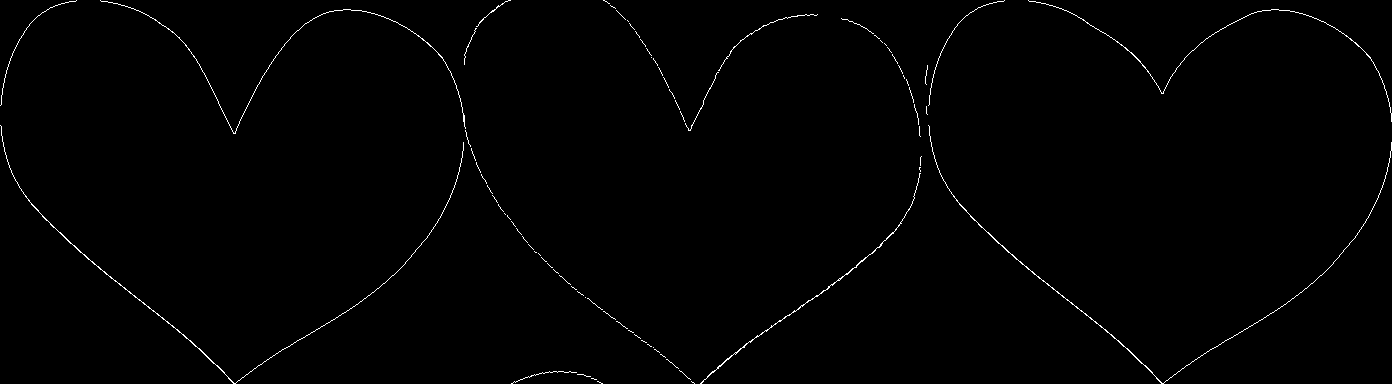

327.08339775736283


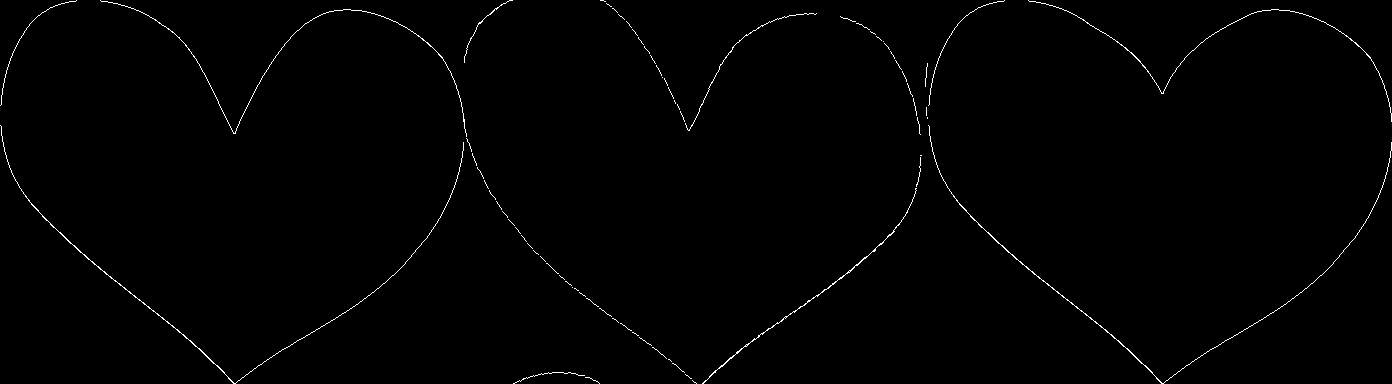

 88%|████████▊ | 22/25 [10:26<01:32, 30.89s/it]

Time for image 21 21.509673833847046
477.2010915269094


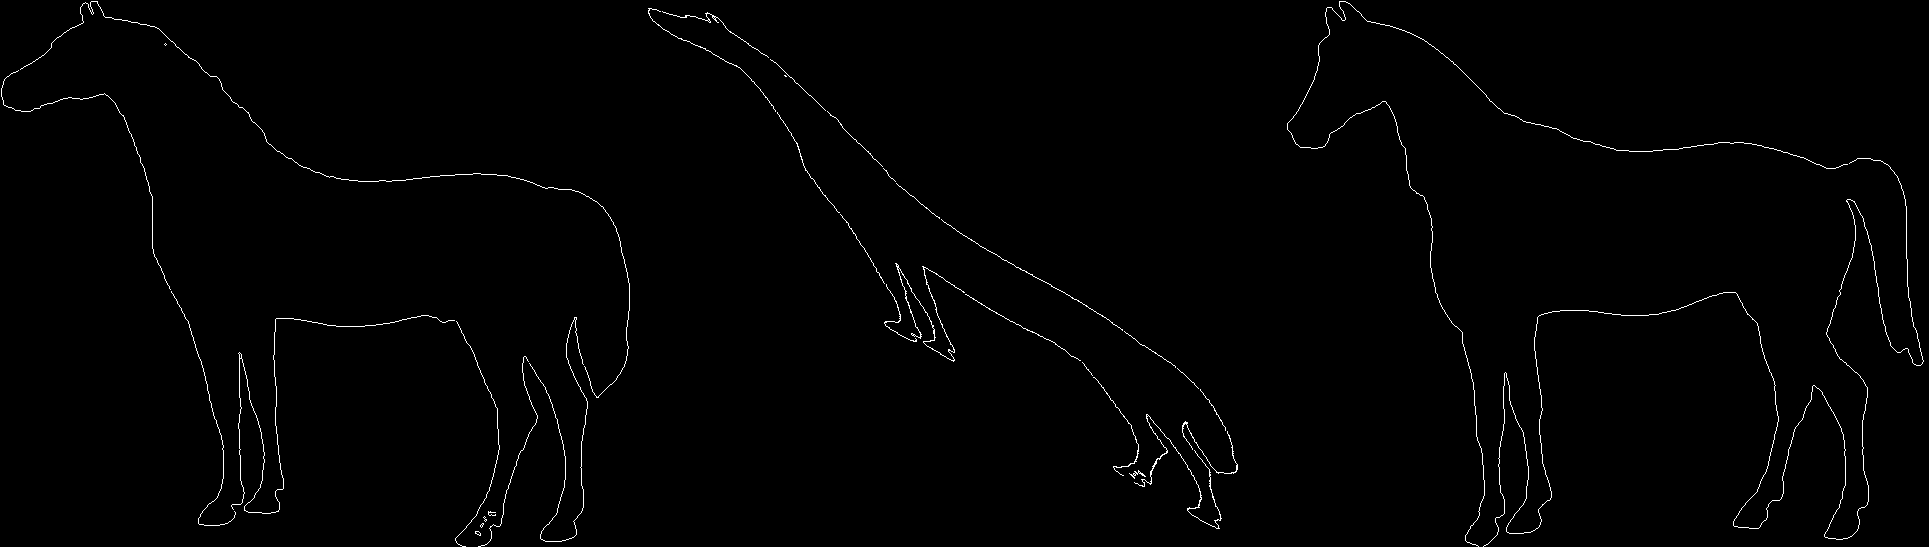

495.36819712291594


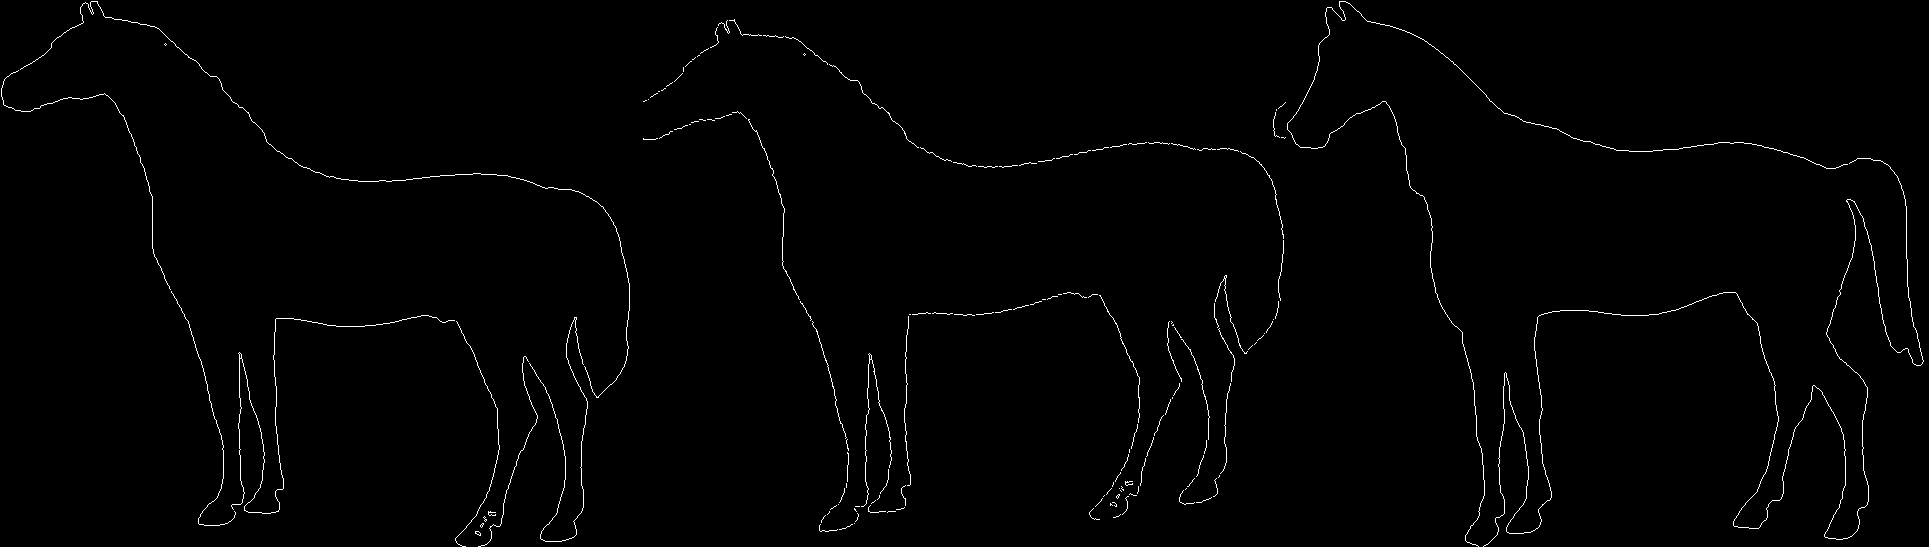

477.72050072938214


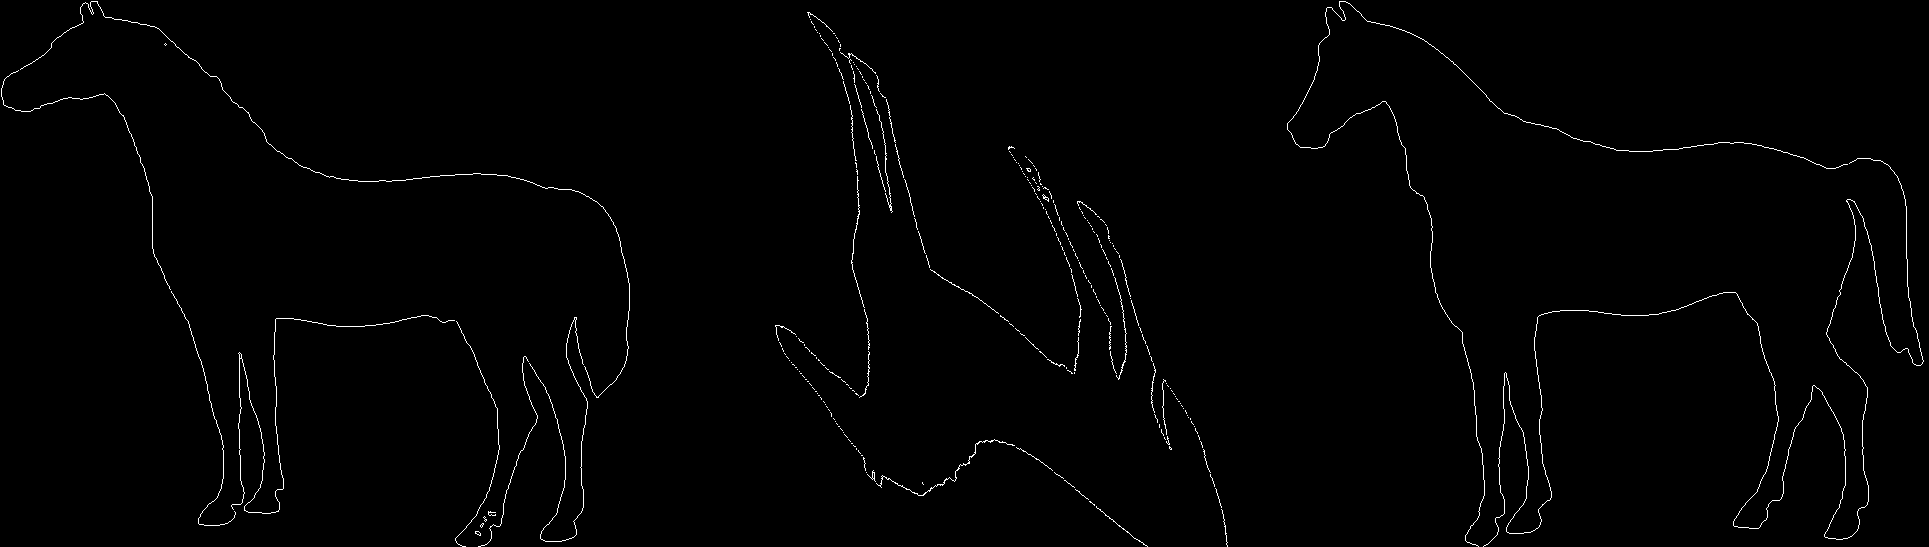

487.97569387152635


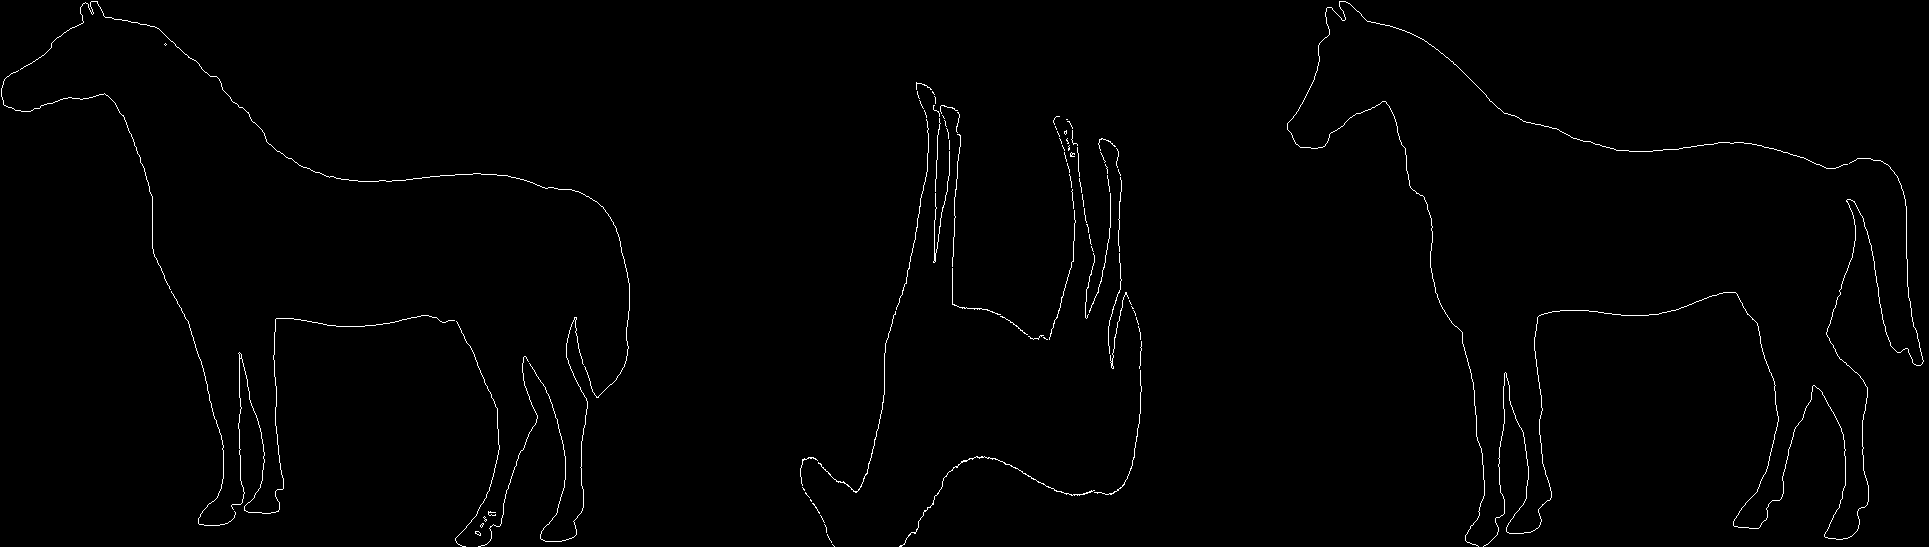

488.07563810621104


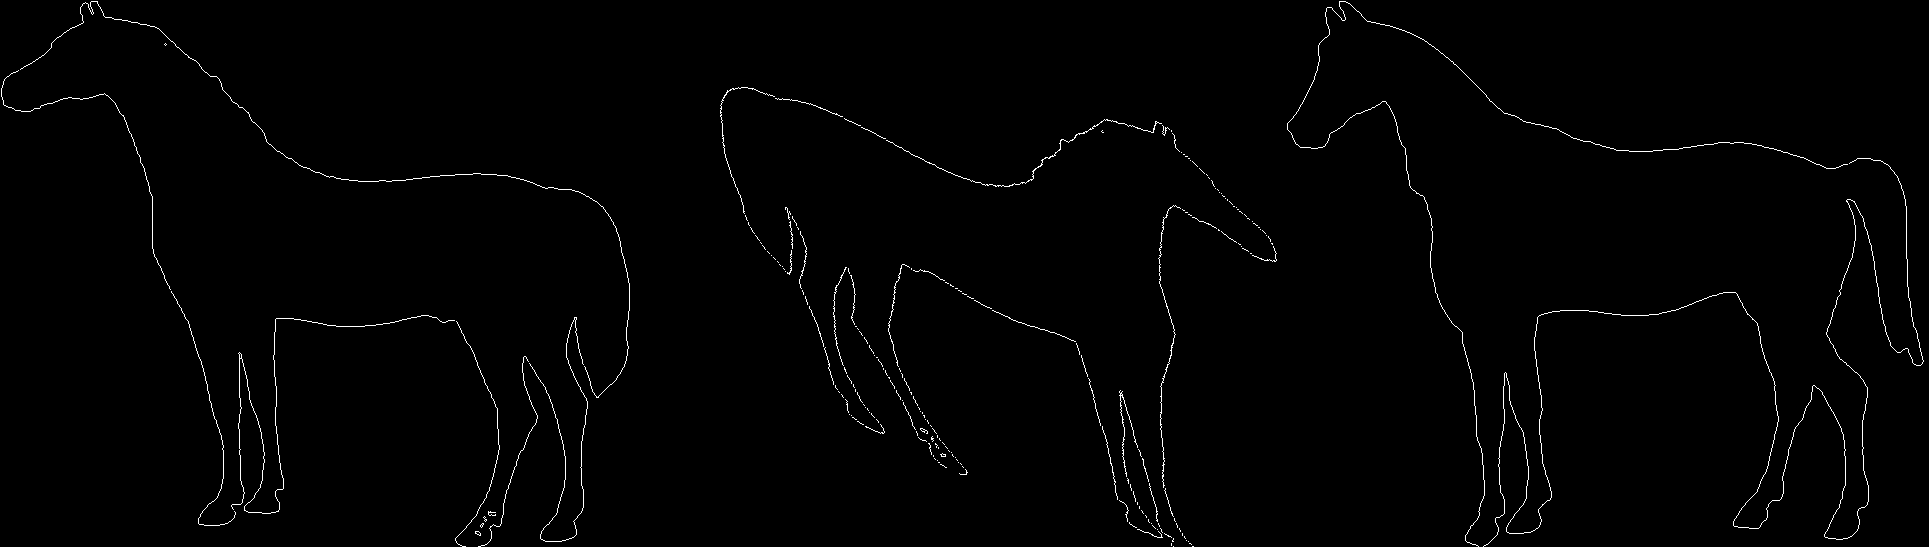

491.3100158610539


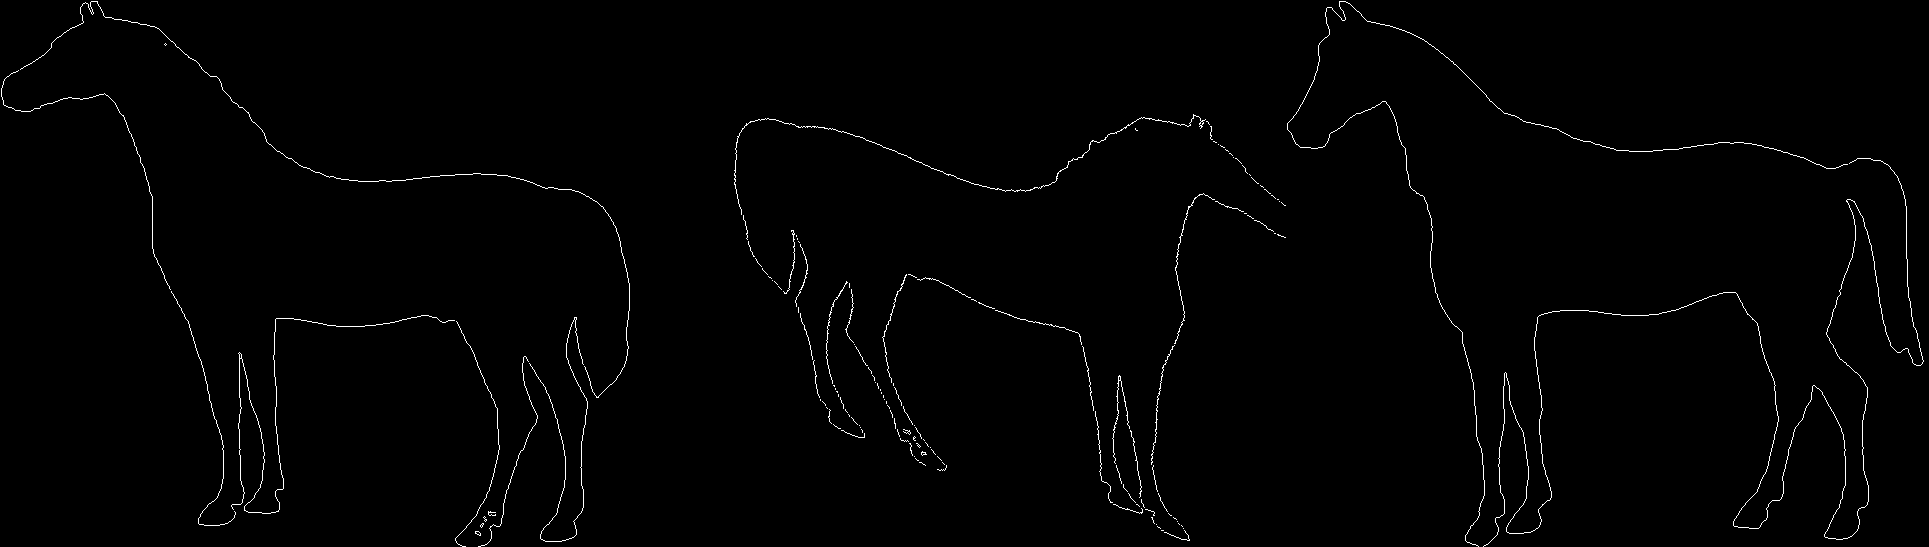

 92%|█████████▏| 23/25 [12:20<01:51, 55.60s/it]

Time for image 22 113.2432632446289
373.5750642162628


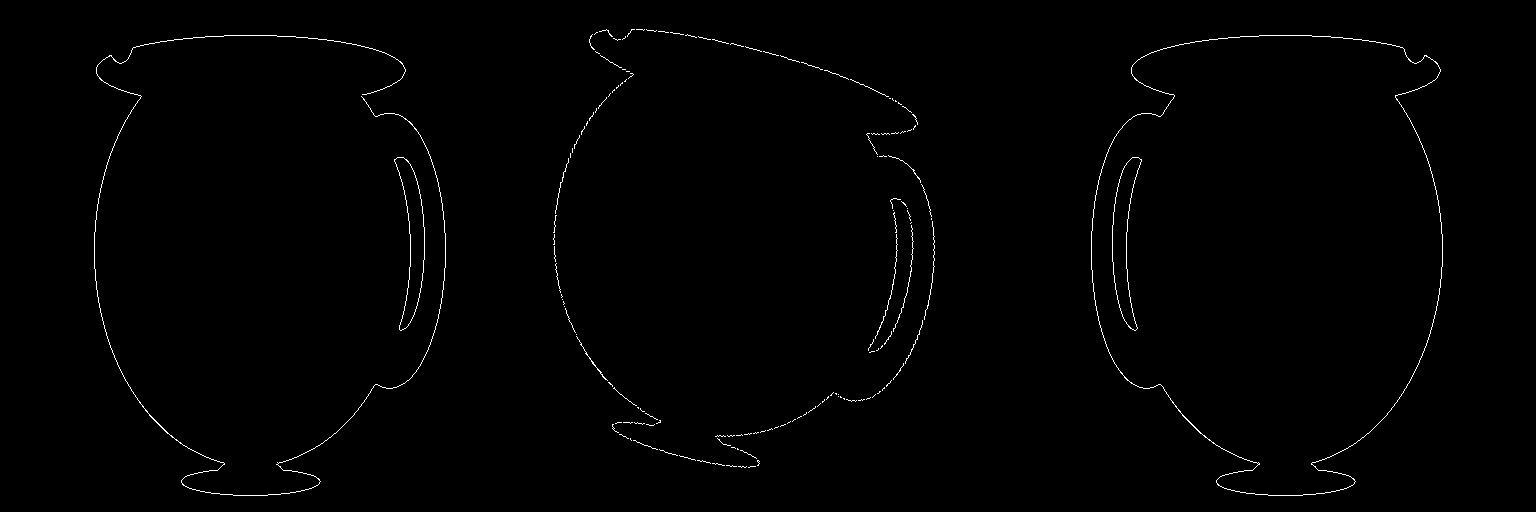

373.8741370015857


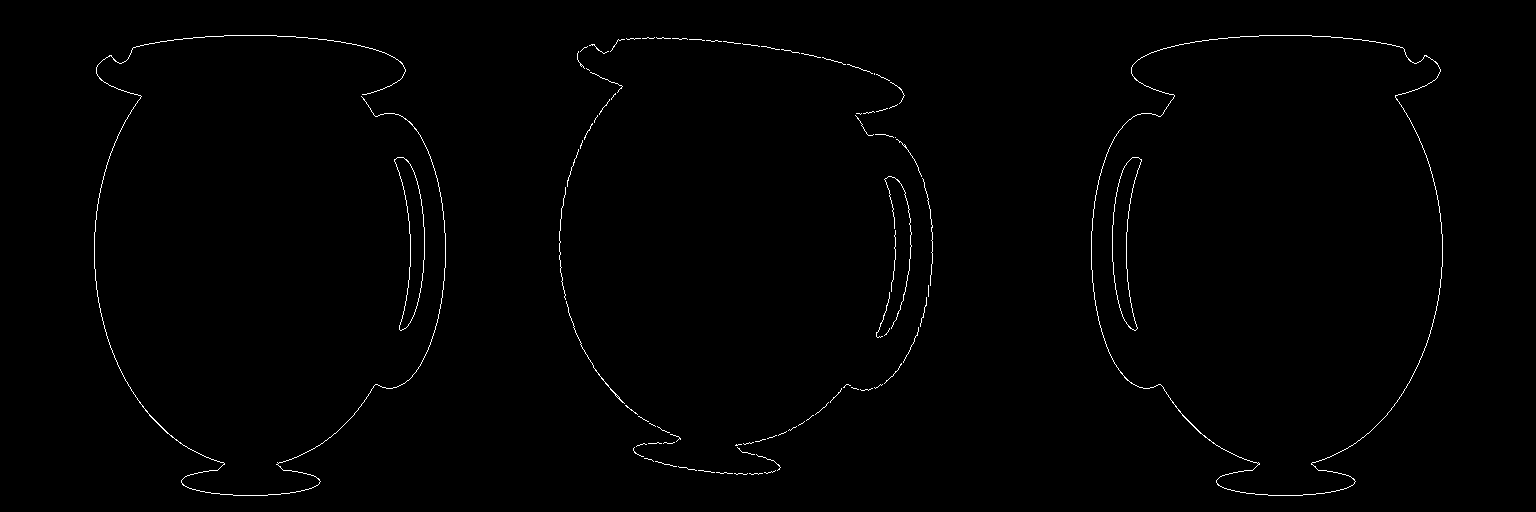

371.68898850934687


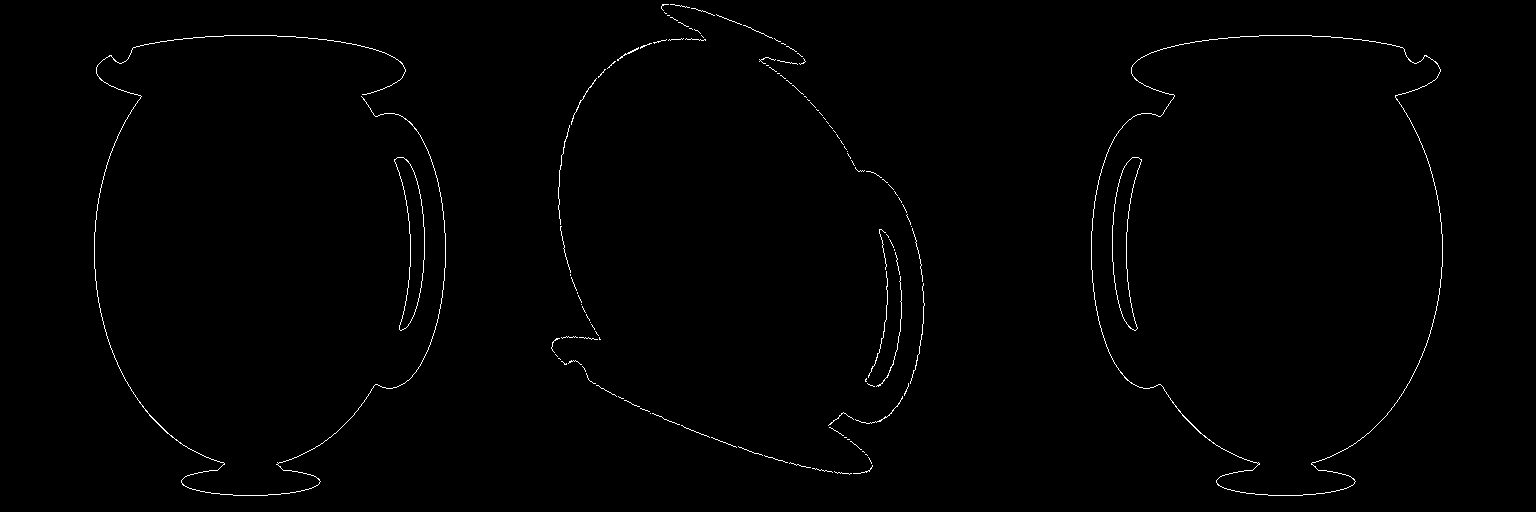

370.9895502886502


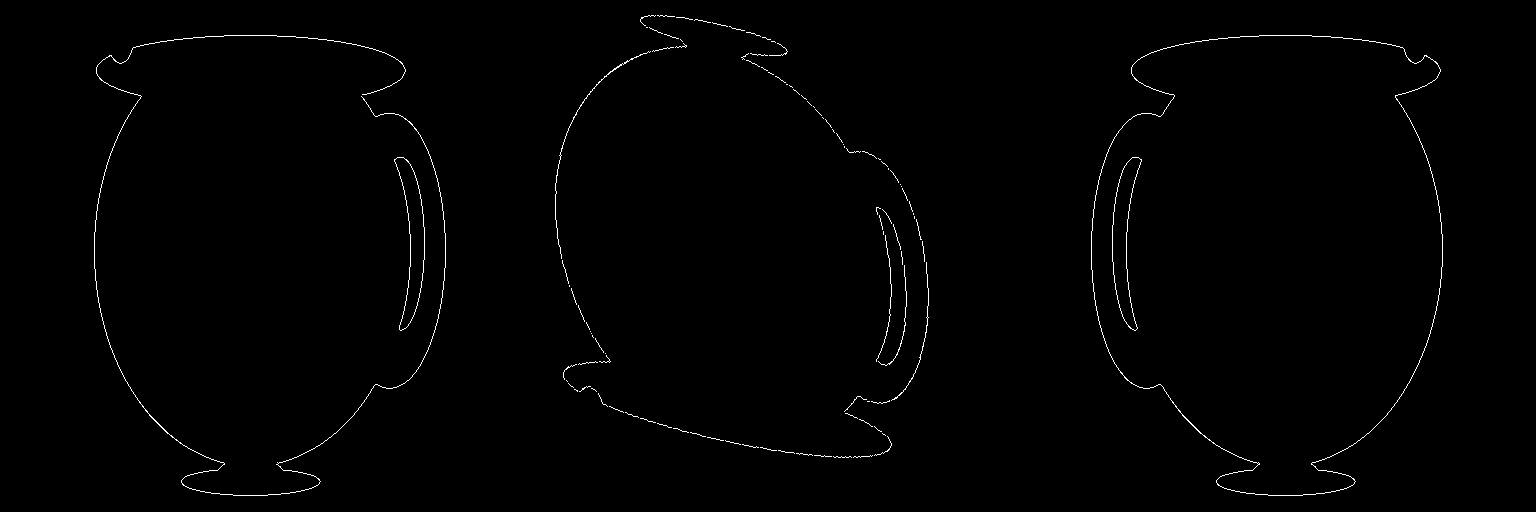

363.67307110744673


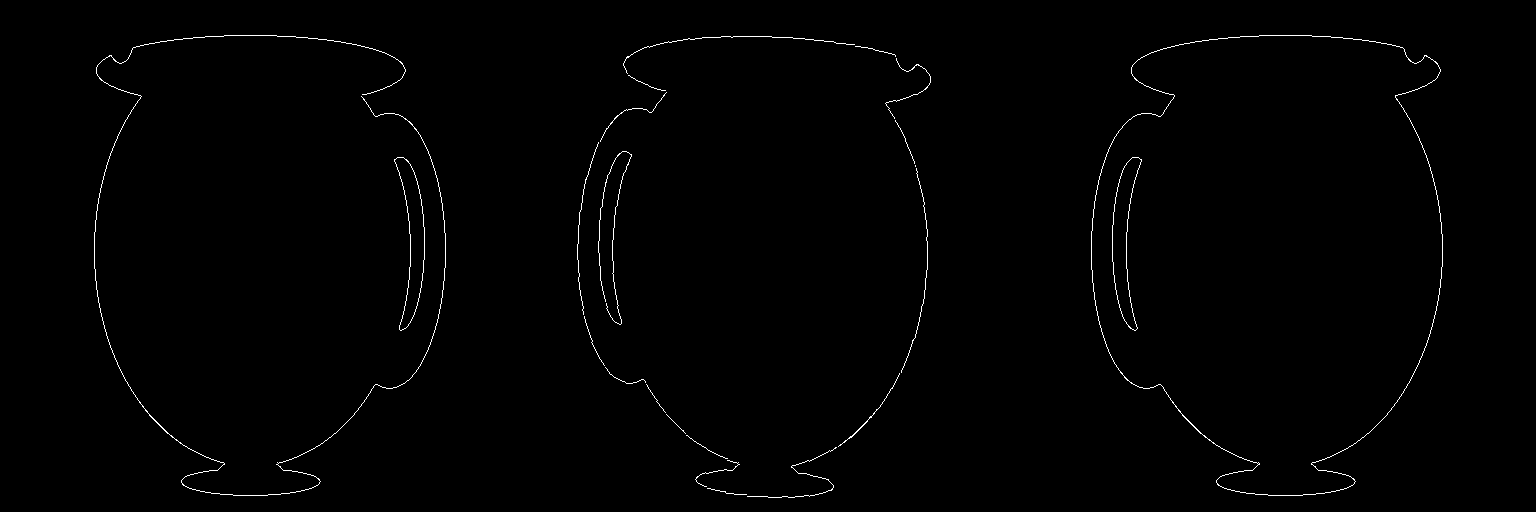

363.9902602773732


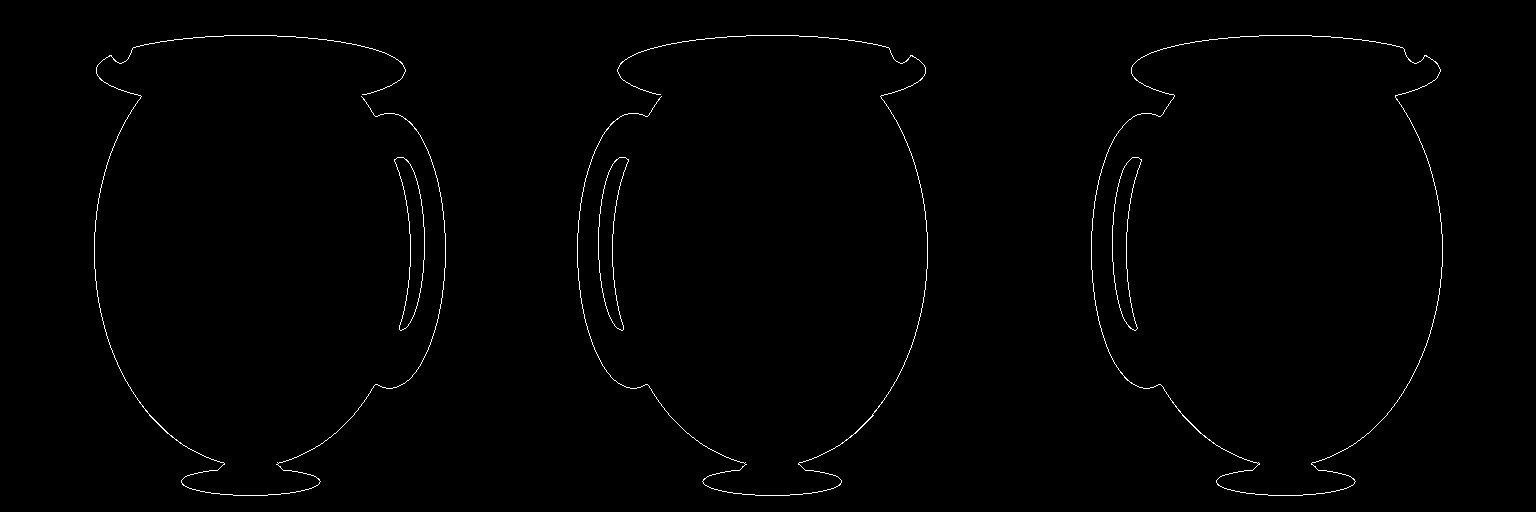

 96%|█████████▌| 24/25 [12:59<00:50, 50.58s/it]

Time for image 23 38.84038519859314
256.79827851105966


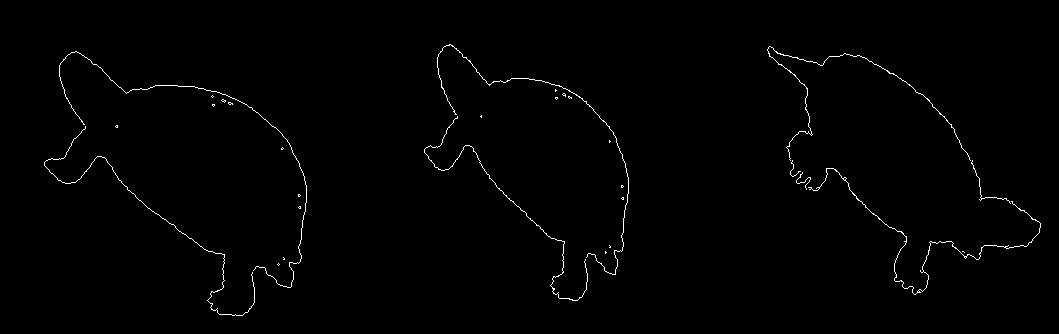

257.605876650936


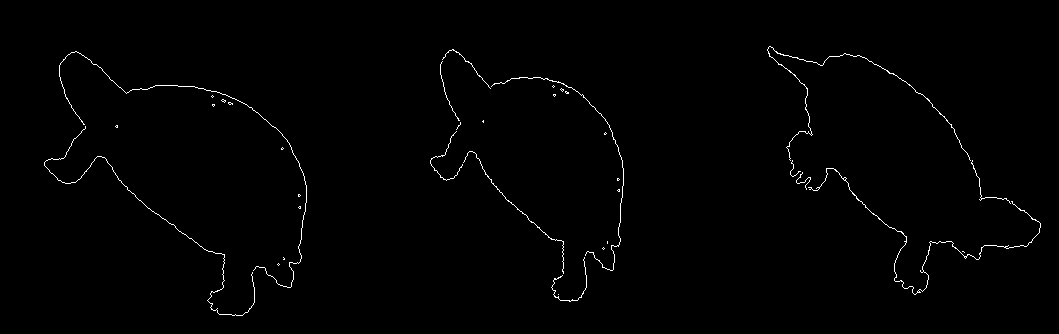

255.7578211940589


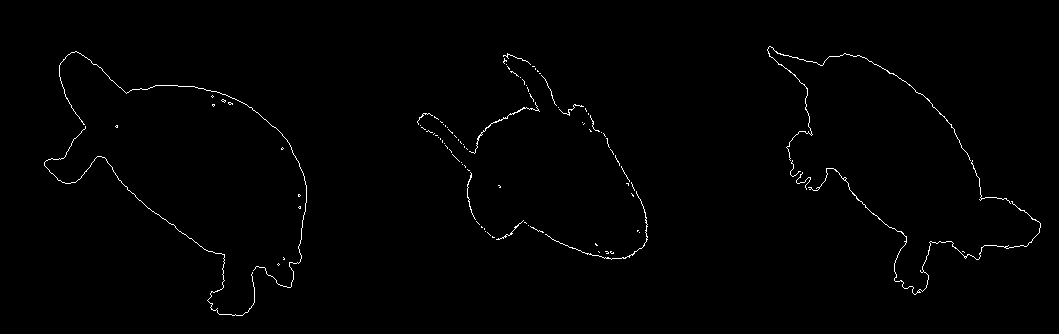

257.26599002458215


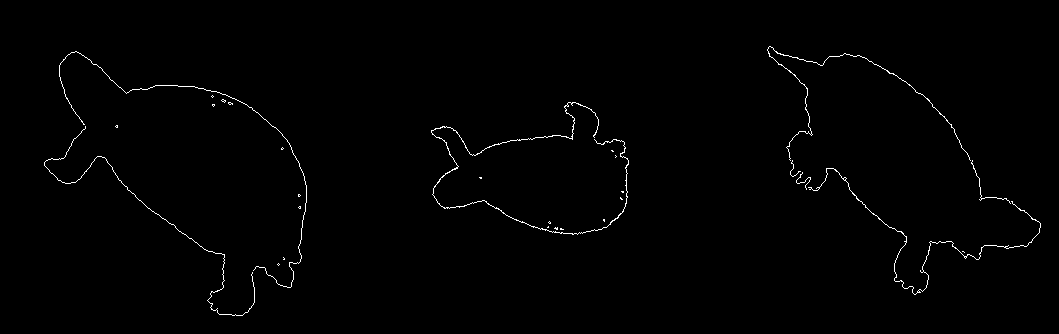

258.97676593891856


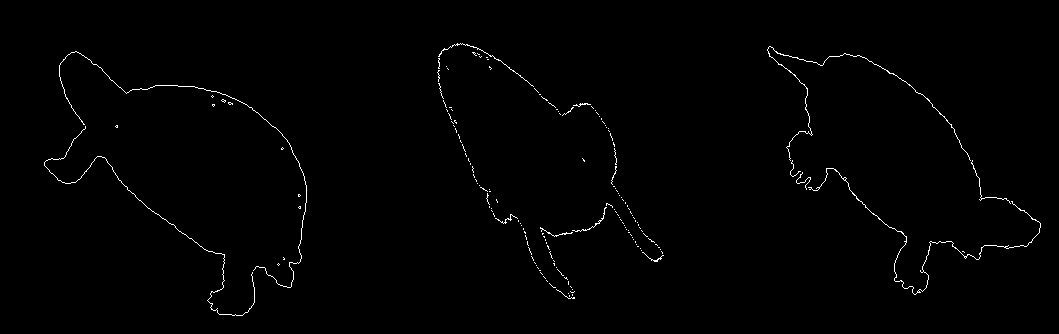

258.0933937177192


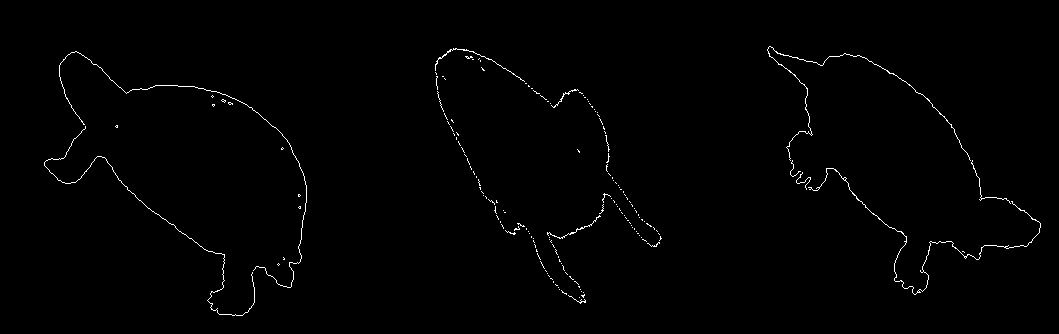

100%|██████████| 25/25 [13:13<00:00, 31.74s/it]

Time for image 24 14.509791135787964


In [24]:
from numpy.lib import delete
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import imutils
import time
from tqdm import tqdm
from google.colab.patches import cv2_imshow

def nearest_neighbor(input1, input2):
   
  
    matches = []
    centroid_1 = np.mean(input1, axis=0)
    centroid_2= np.mean(input2, axis=0)
    m1=input1-centroid_1
    m2=input2-centroid_2
    # m1=input1
    # m2=input2
    
    
    dists=np.zeros((input1.shape[0]))
    for i in range(input1.shape[0]):

        distances = np.sqrt((np.square(m1[i,:]-m2)).sum(axis = 1))
        
        ind_sorted = np.argsort(distances)
        dists[i]=distances[ind_sorted[0]]

        matches.append([i, ind_sorted[0]])
              

    return np.asarray(matches), dists



def getAffineTransform(p1,p2):
  
  total_points=p1.shape[0]
  A=np.array([0,0,0,0,0,0])
  
  for i in range(total_points):
   
    x_i=p1[i][0]
    y_i=p1[i][1]
    first=np.array([x_i,y_i,0,0,1,0])
    
    second=np.array([0,0,x_i,y_i,0,1])
    A=np.vstack((A,first))
    A=np.vstack((A,second))
  
  A=np.delete(A, (0), axis=0)   
 
  b=np.array([[0],[0]])
  for j in range(total_points):
    f1=p2[j][0]
    s1=p2[j][1]
    b=np.vstack((b,f1))
    b=np.vstack((b,s1))
  b=np.delete(b, (0), axis=0) 
  b=np.delete(b, (0), axis=0) 
  

  AffineRow=np.matmul(np.linalg.pinv(A), b)   
  
  
  R=AffineRow[:4,]
  R=R.reshape((2,2))
  T=AffineRow[4:6,]
  T=T.reshape((2,1))
  return R, T
def NextPoint(pstep,Rot1,Tran1):
 
  pnext=np.zeros((pstep.shape[0],2))
  for i in range(pstep.shape[0]):
    x1=pstep[i][0]
    y1=pstep[i][1]
    current_matrix=np.array([[x1],[y1]])
  
    
    points3=(Rot1 @ current_matrix +Tran1).T
    
   
    pnext[i,:]=points3
  return pnext  
def get_points(im1,im2):
  p1=np.argwhere(im1 >0)
  p2=np.argwhere(im2>0)
  return p1, p2

import math

def rotate(points_rot):
   
    px=points_rot[:,0]
    py=points_rot[:,1]

    

    qx =  math.cos(120) * (px) + math.sin(120) * (py)
    qy =  math.sin(120) * (px) + math.cos(120) * (py)
    qx2 =  math.cos(270) * (px) + math.sin(270) * (py)
    qy2 =  math.sin(270) * (px) + math.cos(270) * (py)
    a1=np.zeros((qx.shape[0],2))
    a1[:,0]=qx
    a1[:,1]=qy
    a2=np.zeros((qx2.shape[0],2))
    a2[:,0]=qx2
    a2[:,1]=qy2
    
    

    aot=[]
    aot.append(a1)
    aot.append(a2)
    return aot


def flip_points(pt1):
  flip_1=-1*pt1[:,0]
  flip_2=1*pt1[:,1]
  comb1=np.zeros((pt1.shape))
  comb1[:,0]=flip_1
  comb1[:,1]=flip_2
  flip_3=1*pt1[:,0]
  flip_4=-1*pt1[:,1]
  comb2=np.zeros((pt1.shape))
  comb2[:,0]=flip_3
  comb2[:,1]=flip_4
  my_points= [pt1,comb1,comb2]
  return my_points
  





def align_shape(pts, pts2,scale):

    

      c1 = np.mean(pts, axis=0)
      c2= np.mean(pts2, axis=0)
      
      
      xt=c2[0]-c1[0]
      yt=c2[1]-c1[1]
      src=pts.copy()+[xt,yt]
      dst=pts2.copy()
      T= np.array([[scale,0,c2[0]-c1[0]],
                        [0,scale,c2[1]-c1[1]],
                        [0,0,1]])
      
      R_i=np.array([[T[0][0],T[0][1]],
                    [T[1][0],T[1][1]]])
      T_i=np.array([[T[0][1]],[T[1][1]]])
      src=NextPoint(src,R_i,T_i)
    

      for i in range(15):
        
        indices2,d2=nearest_neighbor(src,dst)
      
        match_loop1=src[indices2[:,0]]
        
        match_loop2=dst[indices2[:,1]]
        R1,T1=getAffineTransform(match_loop1,match_loop2)
      
        src=NextPoint(match_loop1,R1,T1)
   
  
 
      return src

    
  
  

 
 
 
imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)




def run_iter(im_1,im_2):
    
    pout1,pout2=get_points(im_1,im_2)
    my_points=flip_points(pout1)
    for p in my_points:
       arot=rotate(p)
       for p1 in arot:
    
      
          a=align_shape(p1,pout2,1)


          aligned1=np.zeros((im_1.shape))
          

          for el in a:
            x1,y1=el
            if x1<im_1.shape[0] and y1<im_1.shape[1]:
              aligned1[int(x1),int(y1)]=255
          err= evalAlignment(aligned1, im_2)  
          print(err)  
         

          cv2_imshow(displayAlignment(im_1, im_2, aligned1, thick=False))



for i in tqdm(range(len(objList))):
  start = time.time()
  imagePath1= imgPath + objList[i]+"_1.png"
  imagePath2= imgPath + objList[i]+"_2.png" 
  im_1= cv2.imread(imagePath1, 0)
  im_2= cv2.imread(imagePath2, 0)
  run_iter(im_1,im_2)
  end=time.time()
  print("Time for image" ,i, end-start)




  

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






1. Here we are using Affine tranformation
2. We find features points where intensity is greater than zero. We intialiaze the Transformation matrix using scaling and rotation. For rotation components we use variance and for translation we use mean difference.

3. Then we find the intial points in the source image.
4. Then we match the points in source image to the points in destination image. Here we use knn algorithm.
5. Then we find new transformation matrix using constarined equation of the Affine transformations.
6. Then multiply this with source image points and repeat the process. \
Furthermore we rotate the images in different direction using imutils functions. Also for mirroring the image we multiply the points (x,y) feature points by -1. \
Finally, the results are shown for every possible rotation.


# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [2]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 86.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 16.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 75.0MB/s]


## Code (10 pts)

In [3]:



import numpy as np
import cv2
from scipy.io import loadmat
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')



## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']

Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

Frame1=Frame1.T


Frame2=Frame2.T

key_pts1=Frame1
key_pts2=Frame2



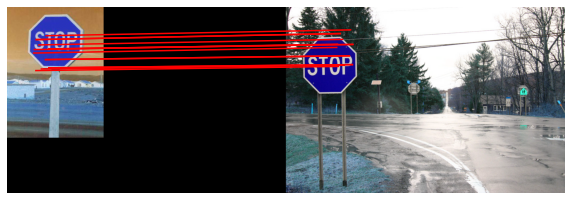

In [28]:
f1=Descriptor1.T
f2=Descriptor2.T
from skimage.feature import plot_matches
import matplotlib.pyplot as plt


def match_features(im1_features, im2_features):
  # create the the list of matches
    matches = []
    #Loop over all the features
    for i in range(im1_features.shape[0]):
        #Find the L2 distance between the images
        distances = np.sqrt(((im1_features[i,:]-im2_features)**2).sum(axis = 1))
        #Get the indices
        ind = np.argsort(distances)
        #Apply threshholding
        #Here the the tuning parameter is set at 0.78
        #As we go on tuning this parameter we will get better results
        #Furthermore smaller the parameter better the results.
        if (distances[ind[0]] < 0.78* distances[ind[1]]) :
       
          matches.append([i, ind[0]])
              

    return np.asarray(matches)

a=match_features(f1,f2)



matches1=key_pts1[a[:,0]]


matches2=key_pts2[a[:,1]]

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.axis('off')
#plot_points
plot_matches(ax, img1, img2, key_pts1, key_pts2,a,
                     keypoints_color='g',only_matches=True, matches_color='r')


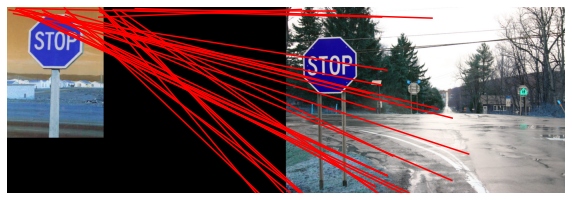

In [102]:
f1=Descriptor1.T
f2=Descriptor2.T
from skimage.feature import plot_matches
import matplotlib.pyplot as plt


def match_features(im1_features, im2_features):
    matches = []
    sorting=dict()
    #subtract the mean to center the features near zero
    m2=np.mean(im2_features,axis=1)
    m2=np.array([m2])
    m2=m2.T
    im1_features=np.array(im1_features,dtype=np.float64)
    im2_features=np.array(im2_features,dtype=np.float64)
    im2_features-=(m2)
    
    for i in range(im1_features.shape[0]):
        mean1=np.mean(im1_features[i,:])
        im1_features[i,:]-=mean1
        #Find the distances
        distances = np.sqrt(((im1_features[i,:]-im2_features)**2).sum(axis = 1))
        
        
        ind_sorted = np.argsort(distances)
      
       
       
        matches.append([i, ind_sorted[0]])
        sorting[(i, ind_sorted[0])]=distances[ind_sorted[0]]
      
              

    return np.asarray(matches), sorting




matches,sorting=match_features(f1,f2)
key_pts=collections.OrderedDict((sorted(sorting.items())))

out = dict(itertools.islice(key_pts.items(),30))   

#Taking first 30 points
new_matches=[]
for key,value in out.items():
    i,j=key
    new_matches.append([i,j])

 
new_matches=np.asarray(new_matches) 
matches1=key_pts1[new_matches[:,0]]


matches2=key_pts2[new_matches[:,1]]

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.axis('off')
plot_matches(ax, img1, img2, key_pts1, key_pts2,new_matches,
                     keypoints_color='r',only_matches=True, matches_color='r')


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

1. The nearest neighbor distances algorithm will give very bad results. Since it is merely looking for 1st neighbor. In other words this algorithm will not consider any other nearest neigbor and hence it will be a bad macth. You can clearly see in the image that the thresholding distance ratio provides better results.
2. The thresholding of the distances includes the second nearest neighbor. Hence tends to give better results.
Furthermore we can look at this problem as a KNN problem. The popular KNN algorithm will tends to give bad accuray if you train the data with 1 nearest neighbor.